In [1]:
import casadi as ca
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy.spatial import ConvexHull
from scipy.linalg import sqrtm, inv

In [2]:
nu = 2
N_Sam = 10

In [3]:
random_vals = np.random.uniform(-1, 1, size=(nu,N_Sam))
print(random_vals)

[[-0.33654936 -0.70176672  0.17928488  0.23154807 -0.64798899  0.39202695
  -0.11860815 -0.70516406 -0.09425468  0.14602501]
 [-0.12224328  0.28447596  0.4930021   0.36672092 -0.9282272   0.59603014
   0.744175   -0.31118386  0.62257737 -0.74018311]]


In [4]:
data_id = "28"
background_filepath = f"./inD-dataset-v1.1/data/{data_id}_background.png"
recordingMeta_filepath = f"./inD-dataset-v1.1/data/{data_id}_recordingMeta.csv"
tracks_filepath = f"./inD-dataset-v1.1/data/{data_id}_tracks.csv"
tracksMeta_filepath = f"./inD-dataset-v1.1/data/{data_id}_tracksMeta.csv"
tracks_data = pd.read_csv(tracks_filepath)
filtered_data = tracks_data[tracks_data['trackId'] == 79]
xAcc = filtered_data['xAcceleration'].to_numpy()
yAcc = filtered_data['yAcceleration'].to_numpy()
random_vals = np.vstack((xAcc,yAcc))
print(random_vals.shape)
N_Sam = random_vals.shape[1]

(2, 297)


In [5]:
def opti_SDP_ca():   
    opti = ca.Opti()

    A = opti.variable(nu,nu)
    b = opti.variable(nu,1)

    samples = opti.parameter(nu,N_Sam)

    opti.minimize(ca.log(ca.det(ca.inv(A))))

    for i in range(N_Sam):
        opti.subject_to(ca.norm_2(A@samples[:,i]+b)**2<=1)

    opts = {"ipopt.print_level": 0, "print_time": False}
    opti.solver('ipopt', opts)

    return opti.to_function('f',[samples],[A,b])

In [6]:
def opti_SDP(nu,N_Sam,samples):
    A = cp.Variable((nu, nu), PSD=True)
    b = cp.Variable((nu, 1))
    constraints = [A - 1e-8*np.eye(nu) >> 0]
    for i in range(N_Sam):
        constraints += [cp.norm(A@cp.reshape(samples[:,i], (2, 1)) + b, 2) <= 1]
    objective = cp.Maximize(cp.log_det(A))

    problem = cp.Problem(objective, constraints)
    problem.solve(solver = cp.SCS) # verbose=True

    return A.value, b.value

In [7]:
A_hat, b_hat = opti_SDP(nu,N_Sam,random_vals)
print(A_hat)
print(b_hat)

/Users/qdzhou/CourseWork/FYP/fyp_env/lib/python3.12/site-packages/cvxpy/atoms/affine/reshape.py:68: FutureWarning: 
    You didn't specify the order of the reshape expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  warnings.warn(reshape_order_warning, FutureWarning)


[[0.64382644 0.06306197]
 [0.06306197 0.97944547]]
[[ 0.47248487]
 [-0.35987626]]


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


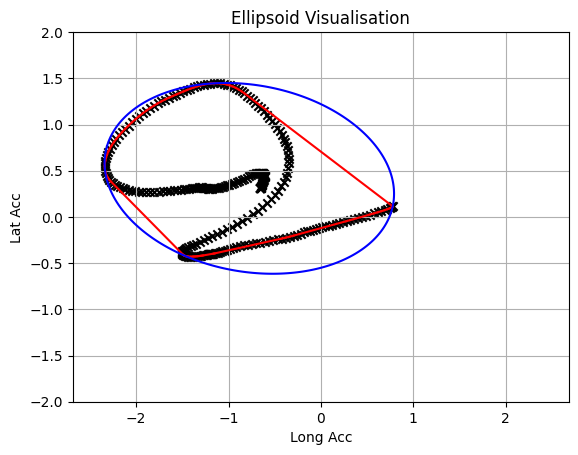

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define the matrix A and vector b for the 2D ellipsoid
A = A_hat
b = b_hat

# Create a grid of points (u, v) in the plane
u_range = np.linspace(-3, 5, 400)
v_range = np.linspace(-3, 5, 400)
u, v = np.meshgrid(u_range, v_range)

# Vectorize u and v to apply the transformation
uv = np.vstack([u.flatten(), v.flatten()]).T

# Apply the transformation A*u + b
transformed_uv = np.dot(uv, A.T) + b.T

# Compute the quadratic form ||A*u + b||^2
quad_form = np.sum(transformed_uv**2, axis=1)

# Reshape to match the grid shape
quad_form = quad_form.reshape(u.shape)

points = random_vals.T
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'r-')

# Plot the 2D ellipsoid using contour plot
plt.contour(u, v, quad_form, levels=[1], colors='b')  # Level set at 1
plt.scatter(random_vals[0,:],random_vals[1,:],marker='x',color = 'black')
plt.title("Ellipsoid Visualisation")
plt.xlabel('Long Acc')
plt.ylabel('Lat Acc')
plt.axis('equal')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True)
plt.show()


In [9]:
def opti_SDP_lemma1(nu, sample, A_pre, b_pre):
    # Define variables
    B = cp.Variable((nu, nu), PSD=True)
    b_tilde = cp.Variable((nu, 1))
    tau1 = cp.Variable((1, 1))
    tau2 = cp.Variable((1, 1))
    tau = [tau1, tau2]

    # Parameters
    A = A_pre
    b = b_pre
    sample = cp.reshape(sample, (2, 1))

    # Define G, g, and c
    G1 = A.T @ A
    g1 = (A @ b).T
    c1 = b.T @ b - 1
    G2 = np.identity(2)
    g2 = -sample.T
    c2 = (sample.T @ sample) - 1e-8
    G = [G1, G2]
    g = [g1, g2]
    c = [c1, c2]

    # Constraints for tau
    constraints = [tau1 >= 0, tau2 >= 0]

    # Loop to create the block matrix constraints
    for i in range(2):
        tmp1 = cp.reshape(B - tau[i] * G[i], (2, 2), order='C')  # Specify order 'C' to suppress the warning
        tmp2 = cp.reshape(b_tilde - tau[i] * (g[i].T), (2, 1), order='C')
        tmp3 = cp.reshape(-1 - tau[i] - c[i], (1, 1), order='C')
        zeros = cp.Constant(np.zeros((2, 2)))  # Explicit constant for zeros

        # Construct the block matrix using cp.bmat
        tmp_matrix = cp.bmat([
            [tmp1, tmp2, zeros],
            [tmp2.T, tmp3, b_tilde.T],
            [zeros, b_tilde, -B],
        ])
        
        # Add the semidefinite constraint
        constraints += [tmp_matrix << 0]

    # Objective function
    objective = cp.Maximize(cp.log_det(B))

    # Solve the problem
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS)

    return B.value, b_tilde.value

In [10]:
def opti_SDP_lemma(nu, A_last, b_last, c_last, u_last): 
    B         = cp.Variable((nu, nu), PSD=True) # B = A**2
    tau       = cp.Variable( )
    tau_u     = cp.Variable( )
    b_tilde   = cp.Variable((nu, 1)) # b_tilde = A@b

    A_u = np.eye(nu)
    b_u = -u_last.reshape(2, 1)
    c_u = u_last.T@u_last - 1e-8

    zero_block = np.zeros((nu, nu))
    
    M  = cp.bmat([[B - tau * A_last, b_tilde - tau * b_last, zero_block],
                    [(b_tilde - tau * b_last).T, cp.reshape(-1 - tau * c_last, (1, 1)), b_tilde.T],
                    [zero_block, b_tilde, -B]])
    Mu = cp.bmat([[B - tau_u * A_u, b_tilde - tau_u * b_u, zero_block],
                    [(b_tilde - tau_u * b_u).T, cp.reshape(-1 - tau_u * c_u, (1, 1)), b_tilde.T],
                    [zero_block, b_tilde, -B]])
    
    constraints = [tau >= 0, tau_u >= 0, -M >> 0, -Mu >> 0, B - 1e-8*np.eye(nu) >> 0]  
    objective   = cp.Maximize(cp.log_det(B))
    problem     = cp.Problem(objective, constraints)
    #problem.solve(solver = cp.MOSEK)
    problem.solve(solver=cp.SCS)
    if problem.status == cp.OPTIMAL:
        print("Optimal solution found!")
    elif problem.status == cp.OPTIMAL_INACCURATE:
        print("Optimal solution found, but it may be inaccurate.")
    elif problem.status == cp.INFEASIBLE:
        print("The problem is infeasible (no solution exists).")
    elif problem.status == cp.UNBOUNDED:
        print("The problem is unbounded (objective can go to infinity).")
    else:
        print(f"Solver status: {problem.status}")

    return B.value, b_tilde.value

In [11]:
def plot_el(A,b,i):
    u_range = np.linspace(-3, 5, 400)
    v_range = np.linspace(-3, 5, 400)
    u, v = np.meshgrid(u_range, v_range)

    # Vectorize u and v to apply the transformation
    uv = np.vstack([u.flatten(), v.flatten()]).T

    # Apply the transformation A*u + b
    transformed_uv = np.dot(uv, A.T) + b.T

    # Compute the quadratic form ||A*u + b||^2
    quad_form = np.sum(transformed_uv**2, axis=1)

    # Reshape to match the grid shape
    quad_form = quad_form.reshape(u.shape)

    # Plot the 2D ellipsoid using contour plot
    plt.contour(u, v, quad_form, levels=[1], colors='b')  # Level set at 1
    plt.scatter(random_vals[0,:i],random_vals[1,:i],marker='x',color = 'black')
    plt.title("Ellipsoid Visualisation")
    plt.xlabel('Long Acc')
    plt.ylabel('Lat Acc')
    plt.axis('equal')
    plt.grid(True)
    plt.show()

In [12]:
A_init = np.array([[1, 0], 
              [0, 1]])
b_init = np.array([[0], 
              [0]]) 
c_init = b_init.T@b_init-1

Optimal solution found!
Optimal solution found!


/Users/qdzhou/CourseWork/FYP/fyp_env/lib/python3.12/site-packages/cvxpy/atoms/affine/reshape.py:68: FutureWarning: 
    You didn't specify the order of the reshape expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  warnings.warn(reshape_order_warning, FutureWarning)


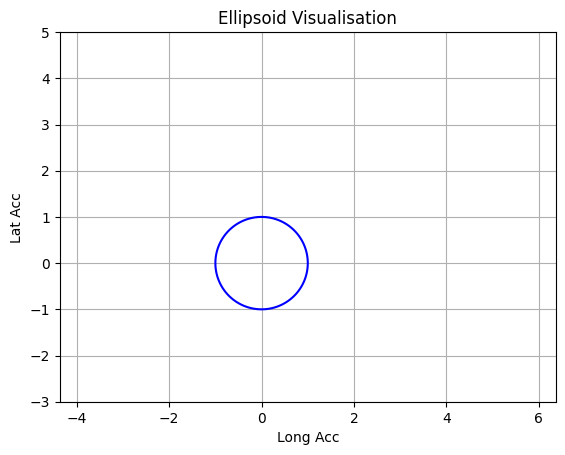

Optimal solution found!


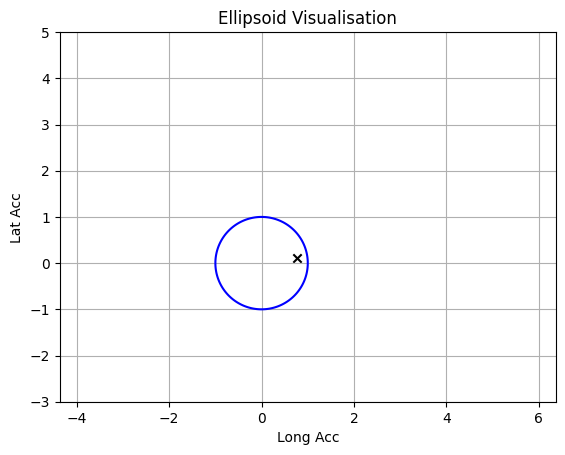

Optimal solution found!


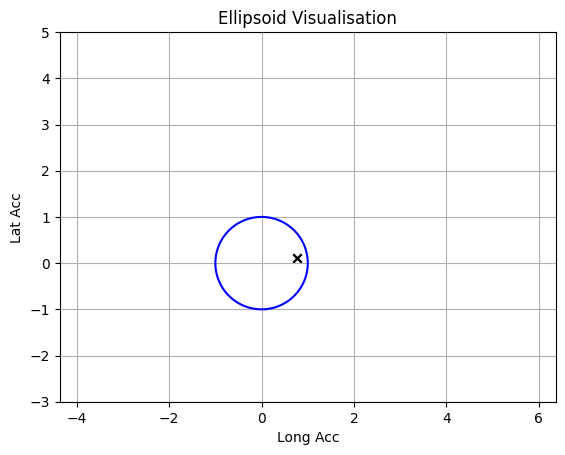

Optimal solution found!


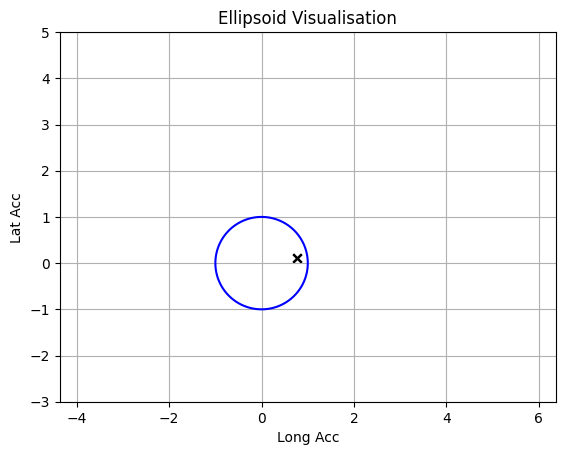

Optimal solution found!


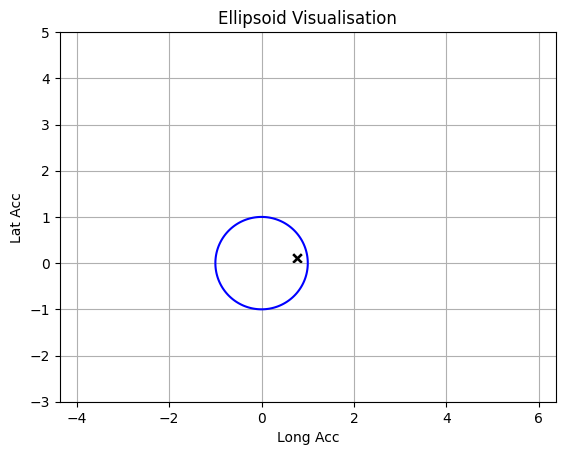

Optimal solution found!


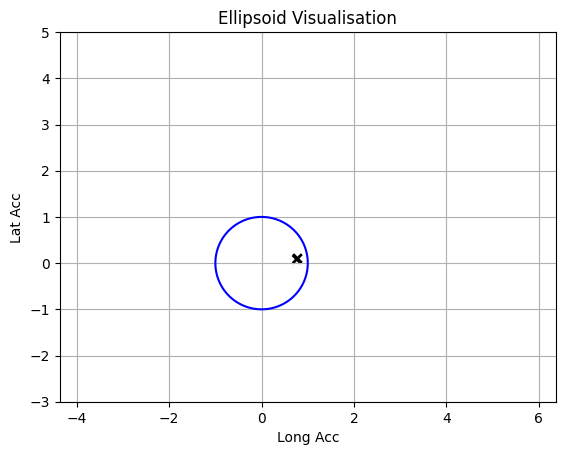

Optimal solution found!


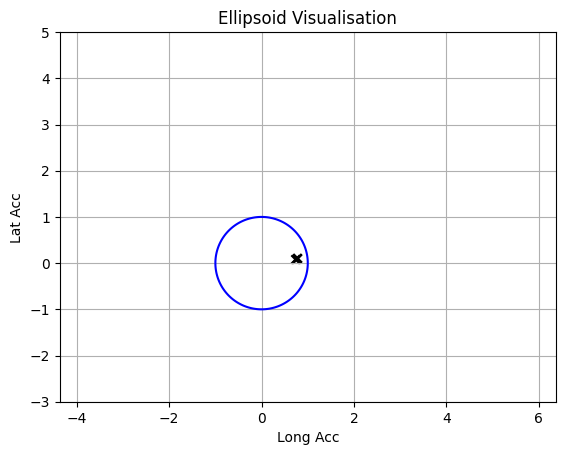

Optimal solution found!


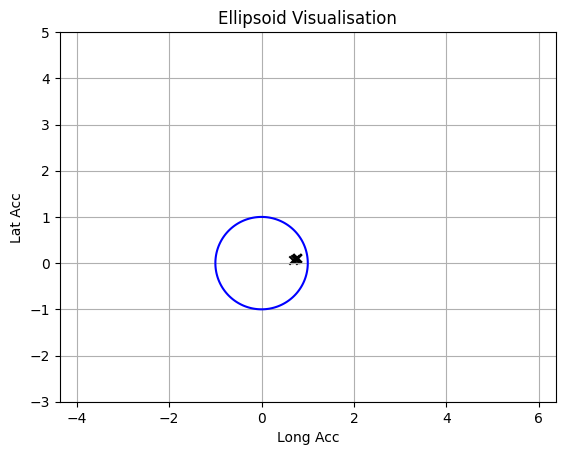

Optimal solution found!


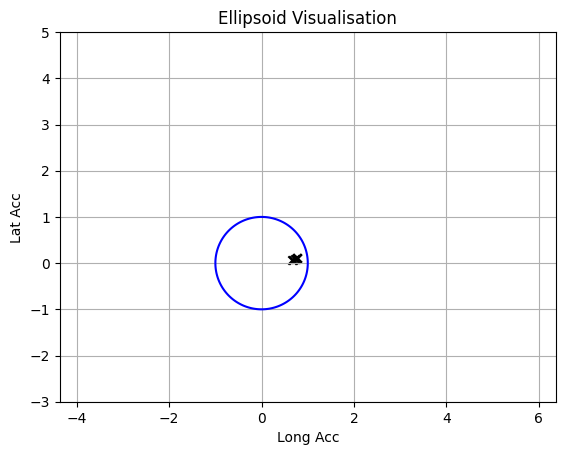

Optimal solution found!


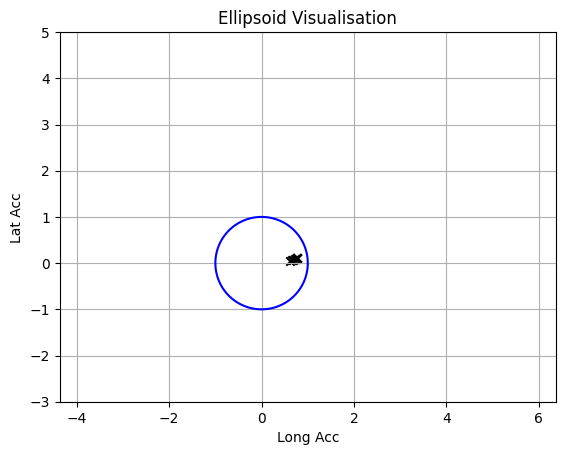

Optimal solution found!


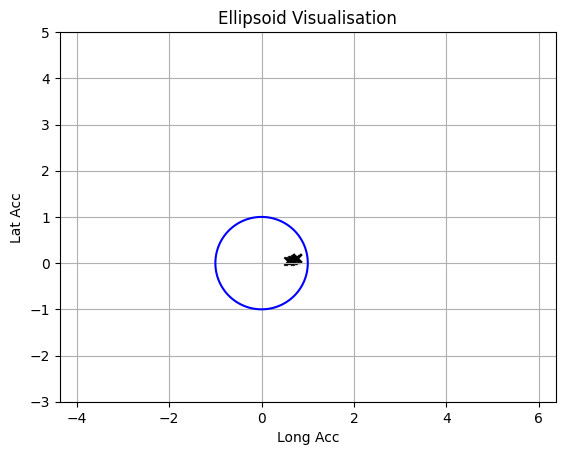

Optimal solution found!


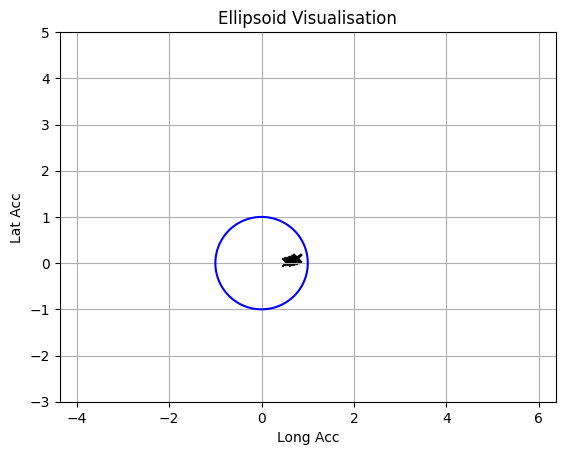

Optimal solution found!


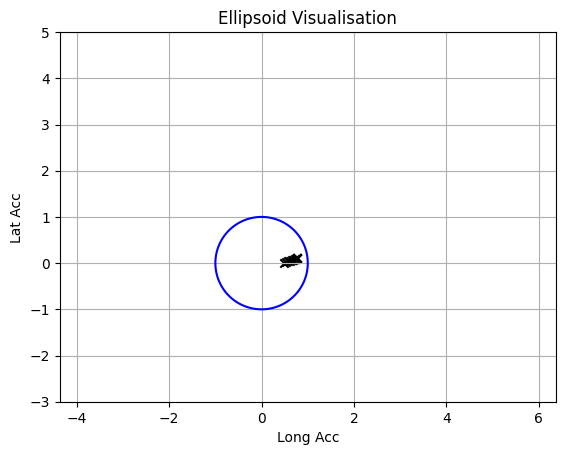

Optimal solution found!


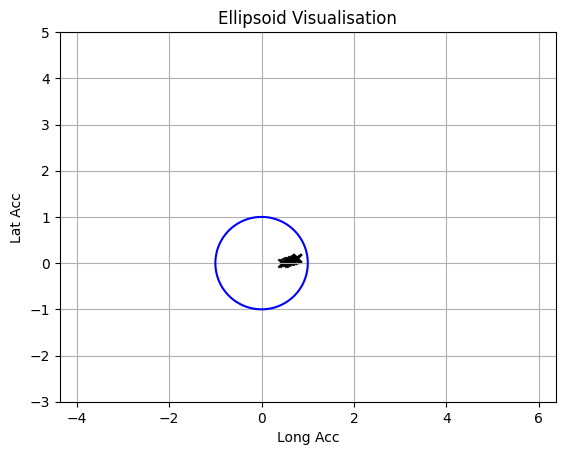

Optimal solution found!


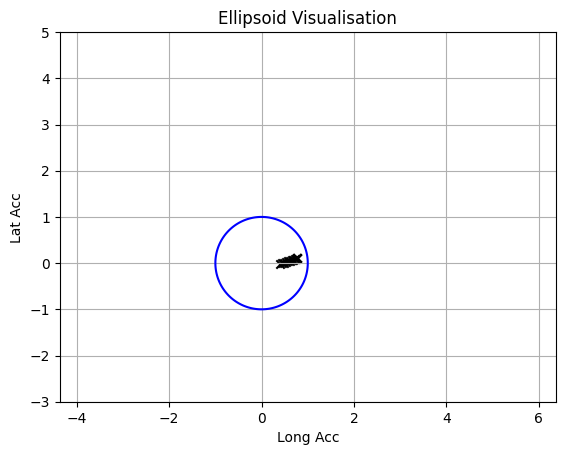

Optimal solution found!


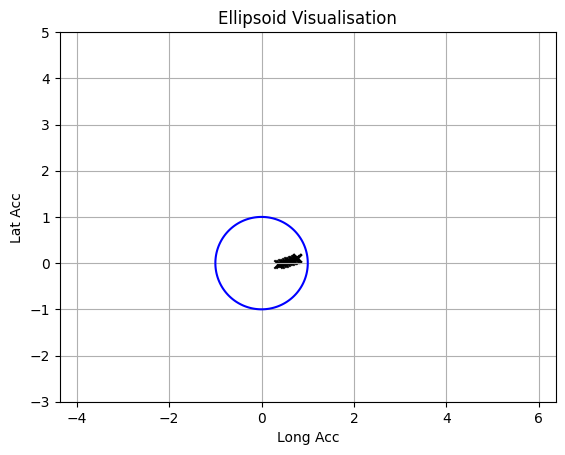

Optimal solution found!


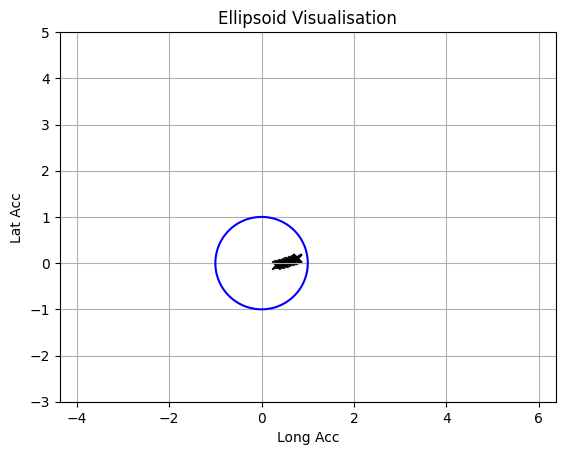

Optimal solution found!


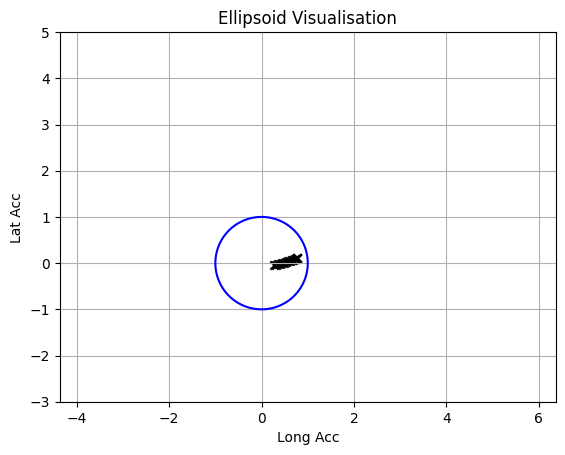

Optimal solution found!


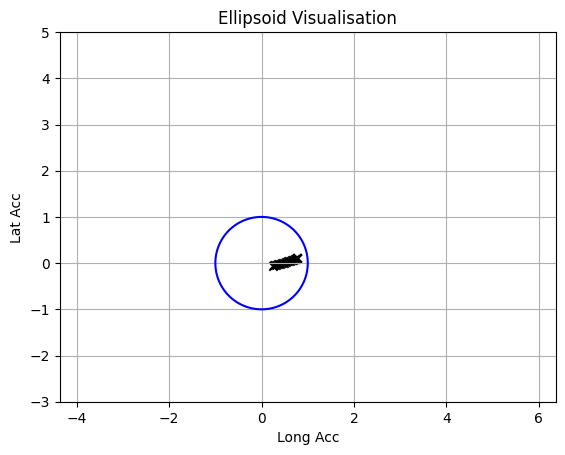

Optimal solution found!


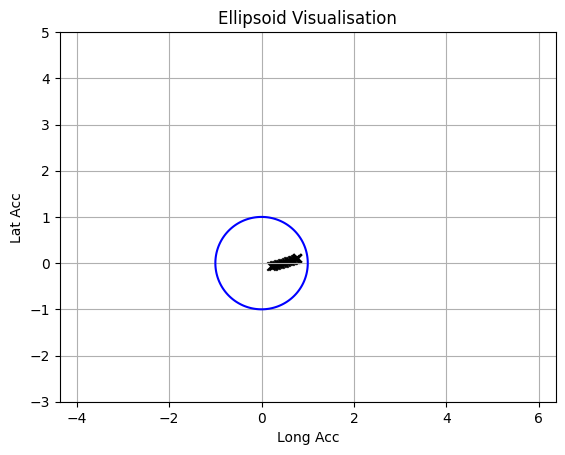

Optimal solution found!


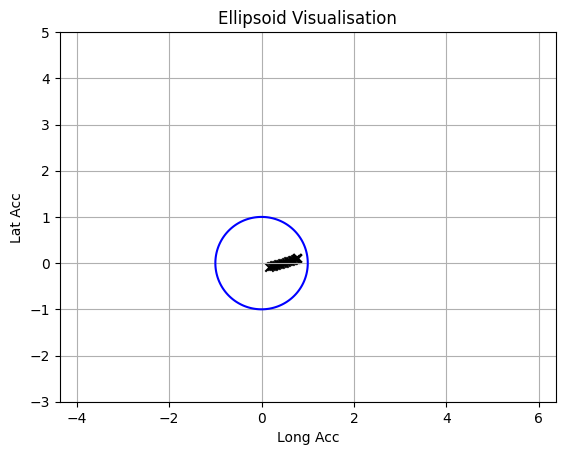

Optimal solution found!


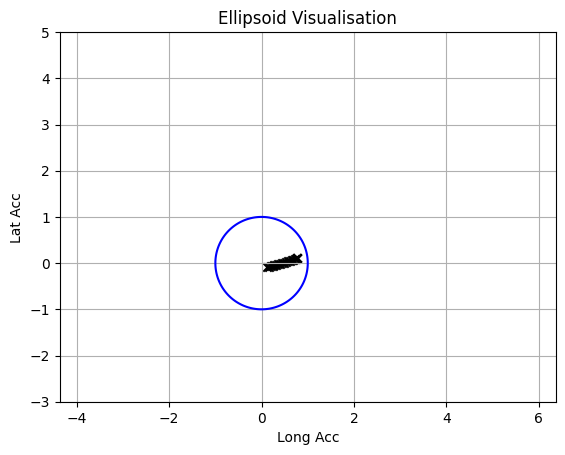

Optimal solution found!


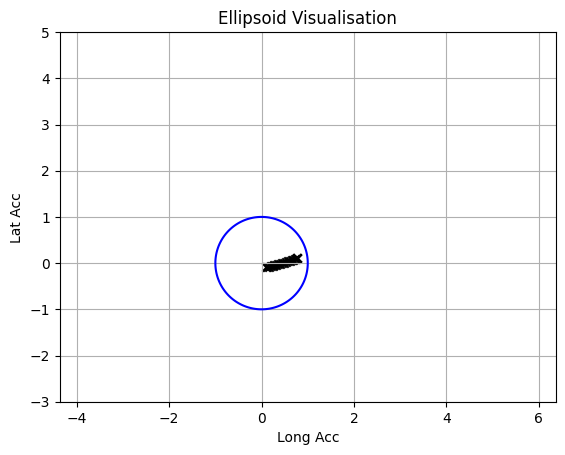

Optimal solution found!


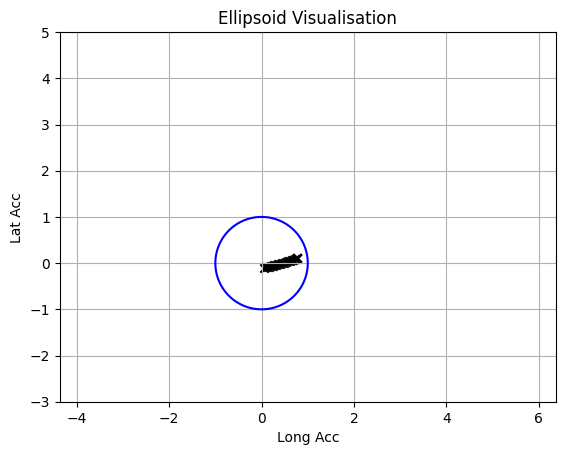

Optimal solution found!


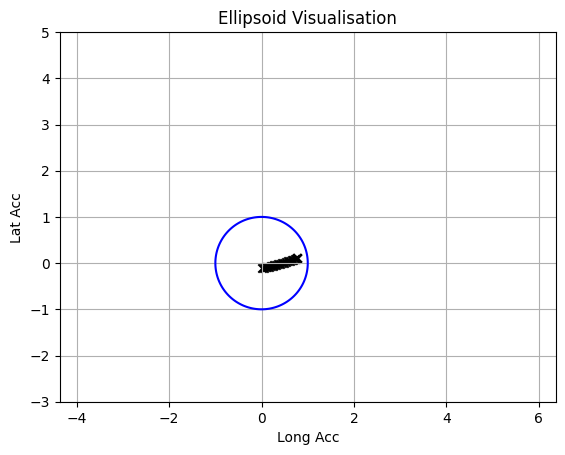

Optimal solution found!


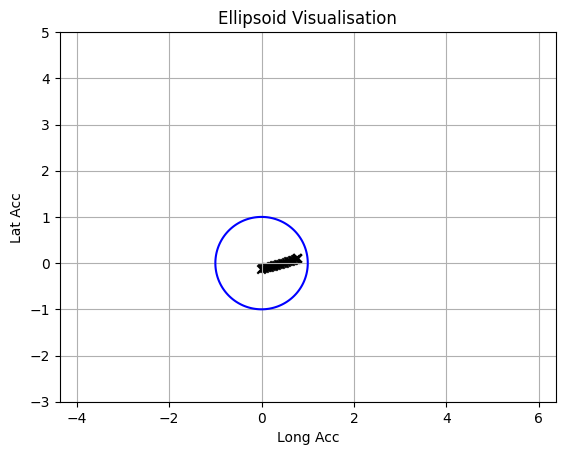

Optimal solution found!


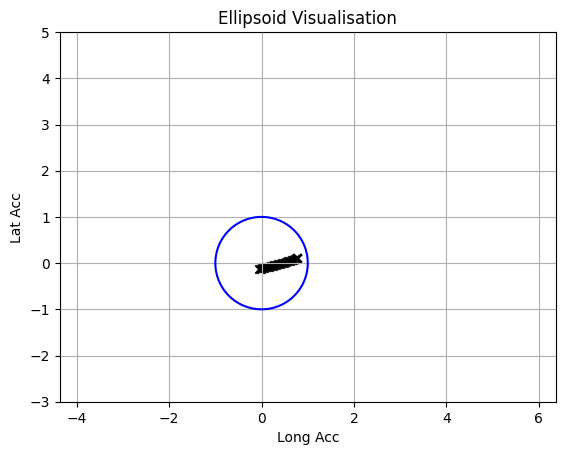

Optimal solution found!


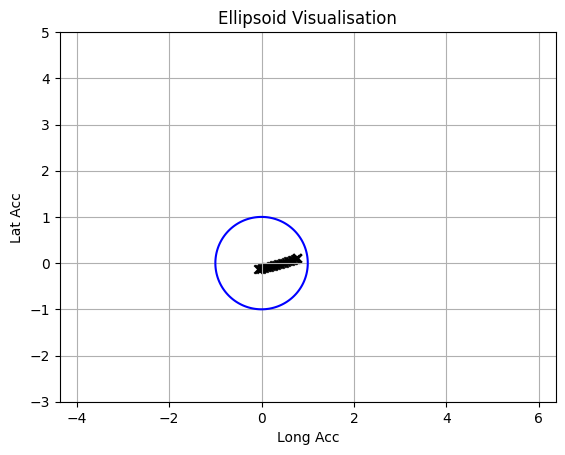

Optimal solution found!


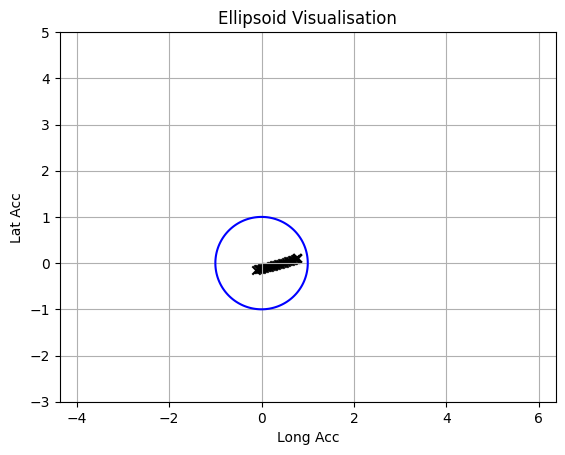

Optimal solution found!


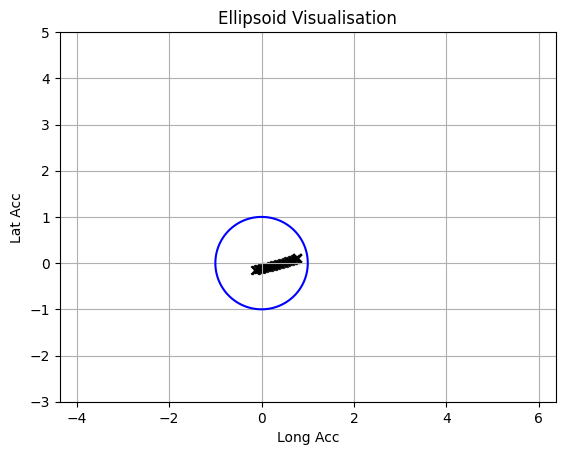

Optimal solution found!


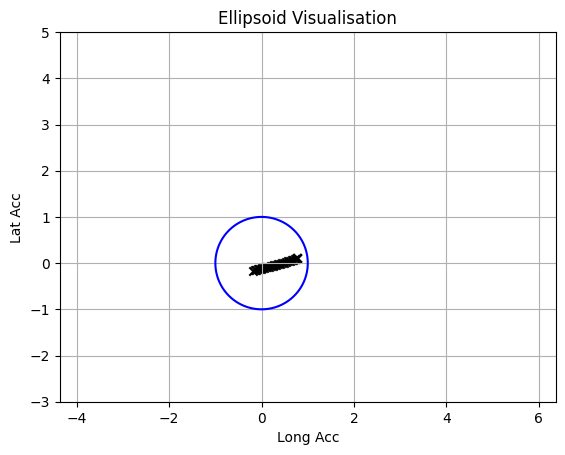

Optimal solution found!


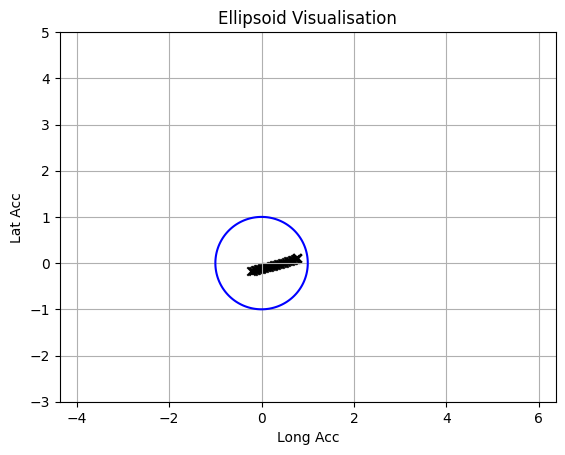

Optimal solution found!


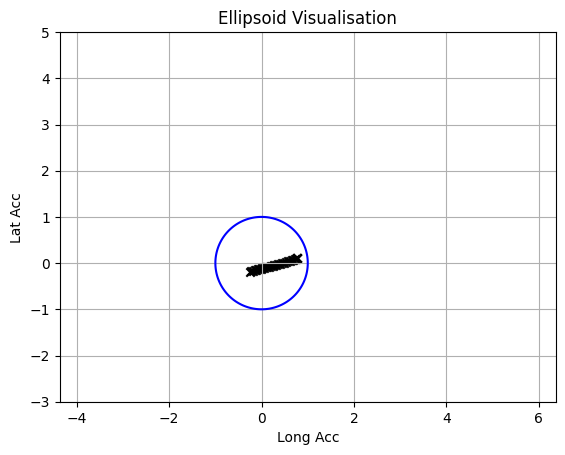

Optimal solution found!


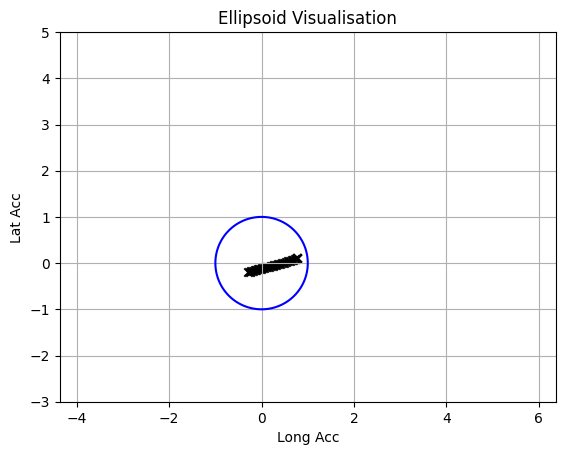

Optimal solution found!


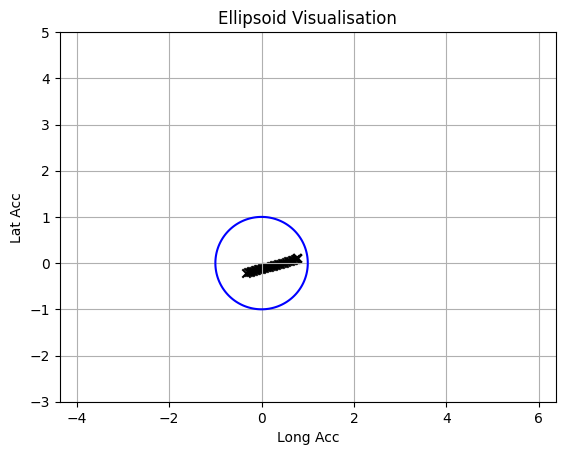

Optimal solution found!


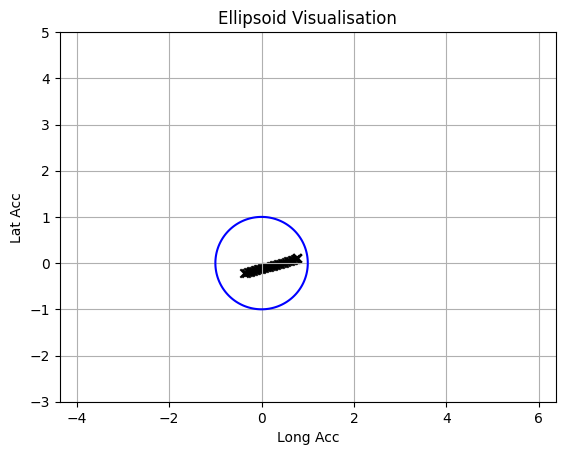

Optimal solution found!


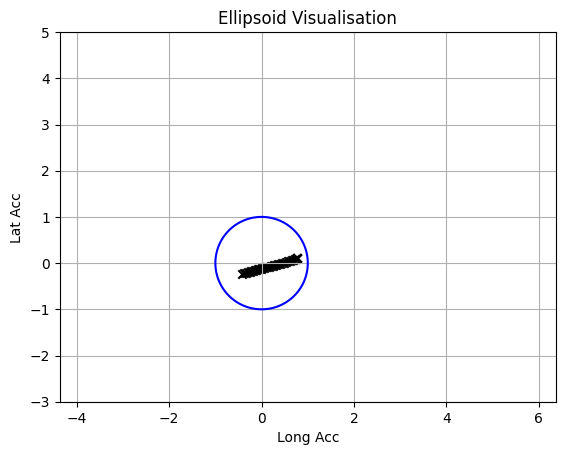

Optimal solution found!


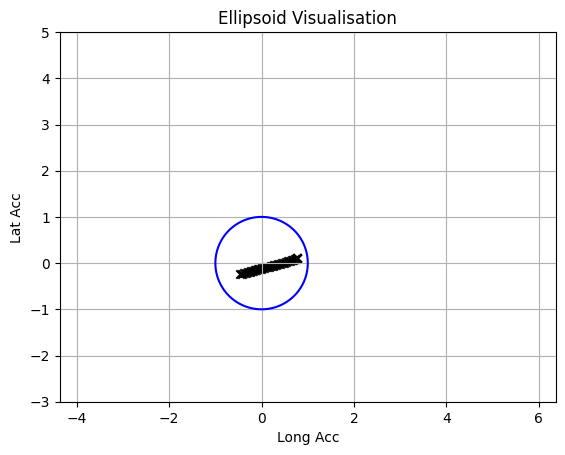

Optimal solution found!


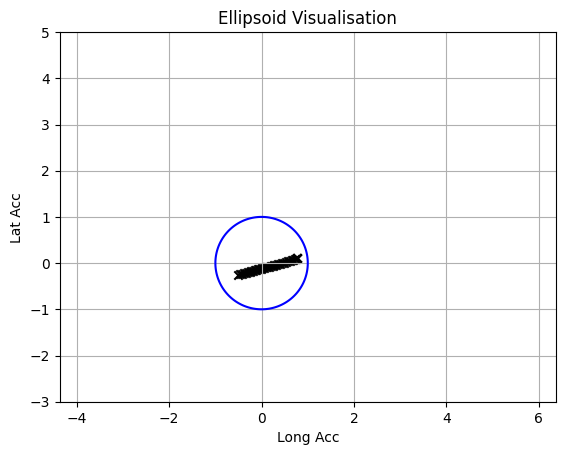

Optimal solution found!


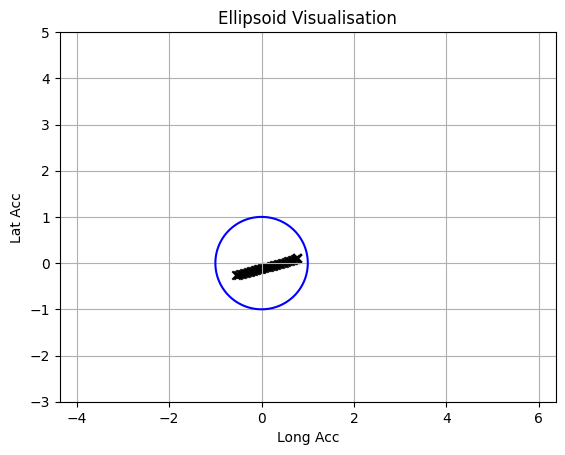

Optimal solution found!


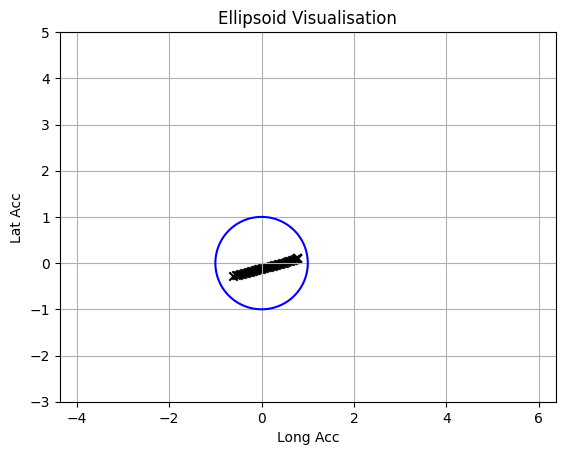

Optimal solution found!


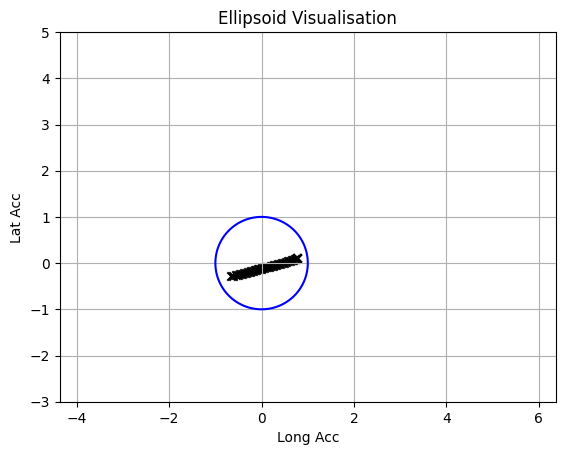

Optimal solution found!


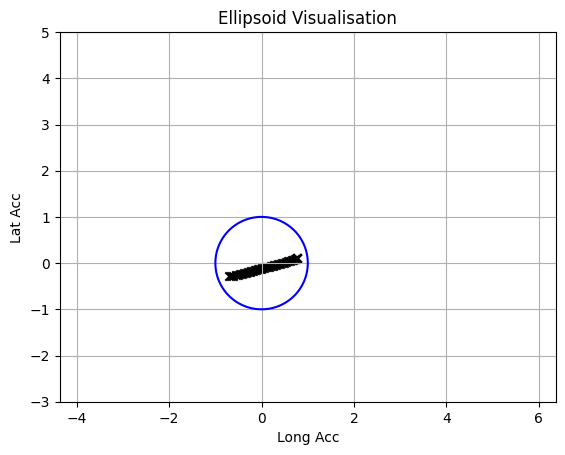

Optimal solution found!


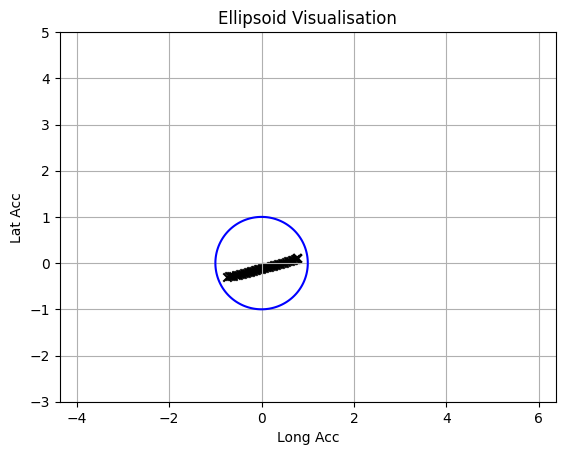

Optimal solution found!


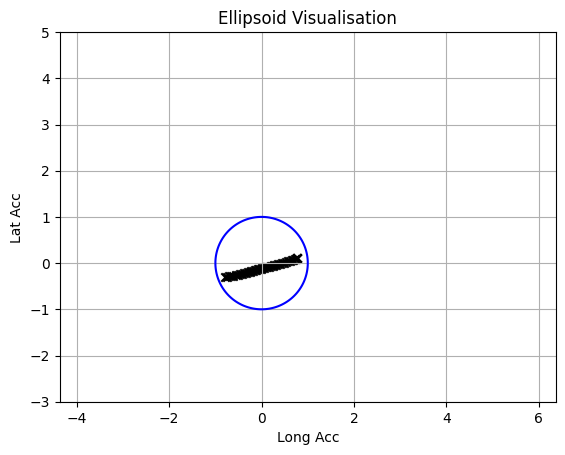

Optimal solution found!


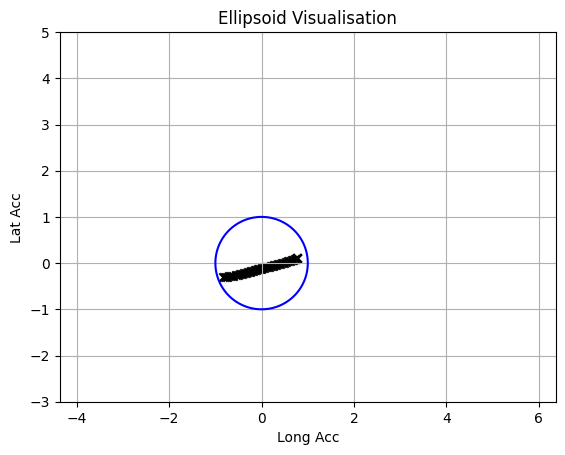

Optimal solution found!


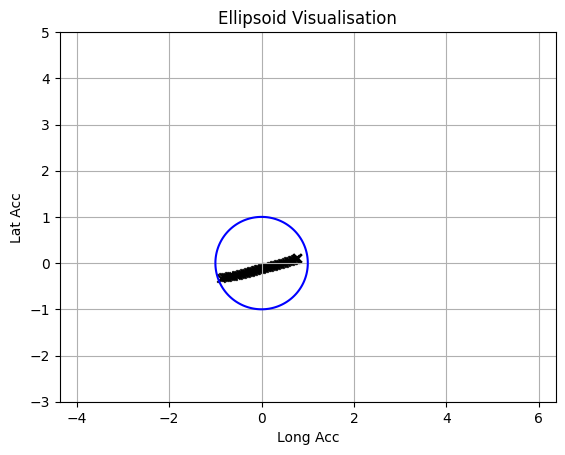

Optimal solution found!


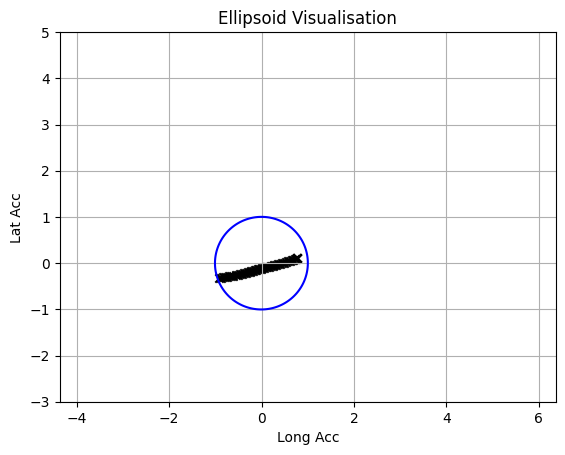

Optimal solution found!


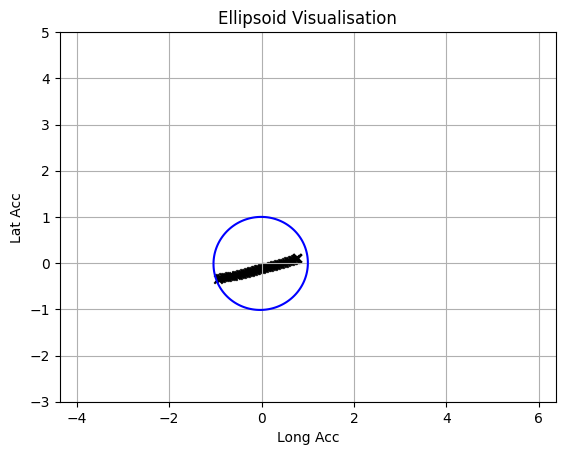

Optimal solution found!


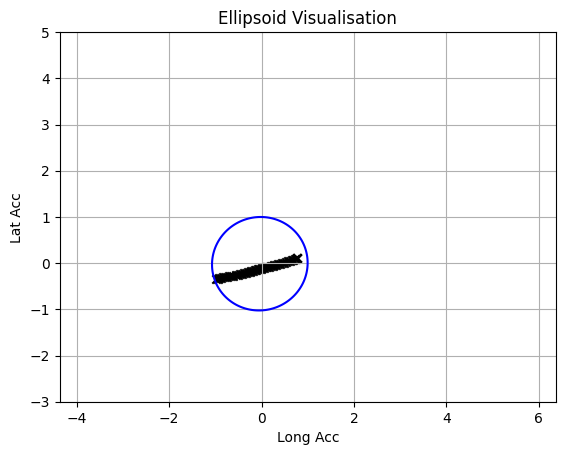

Optimal solution found!


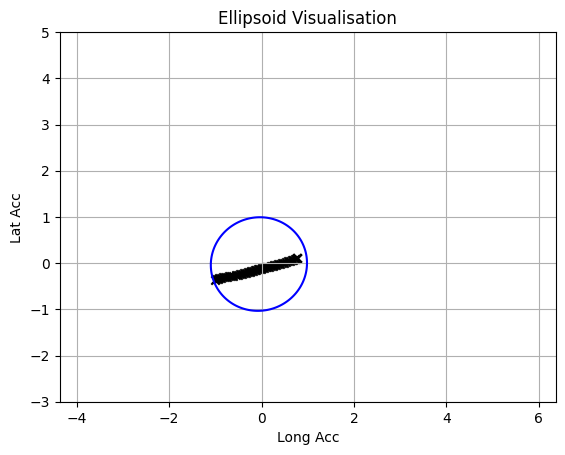

Optimal solution found!


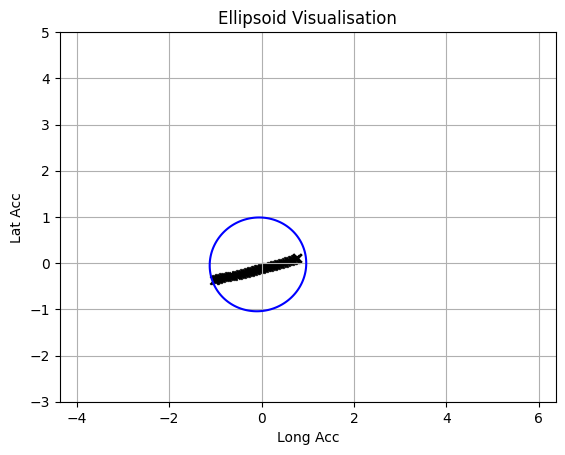

Optimal solution found!


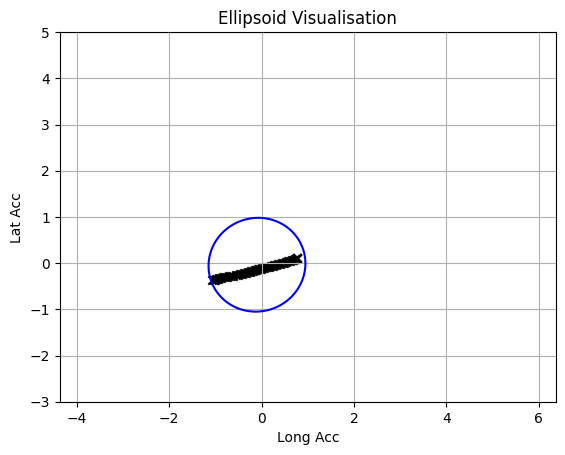

Optimal solution found!


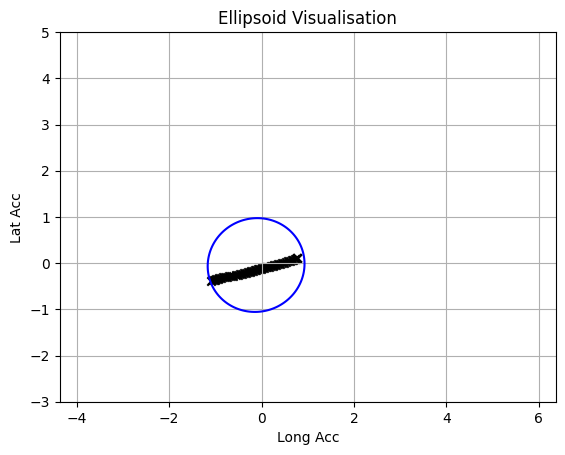

Optimal solution found!


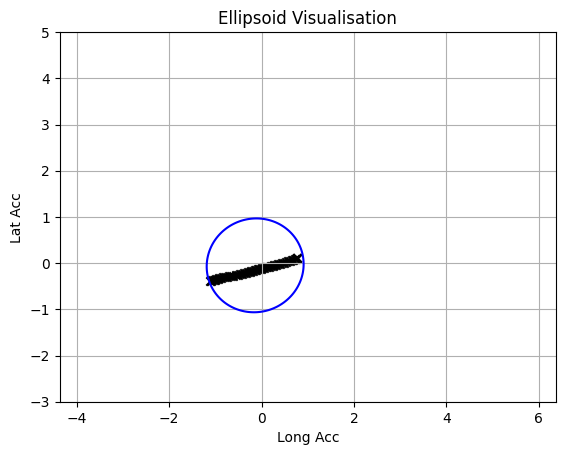

Optimal solution found!


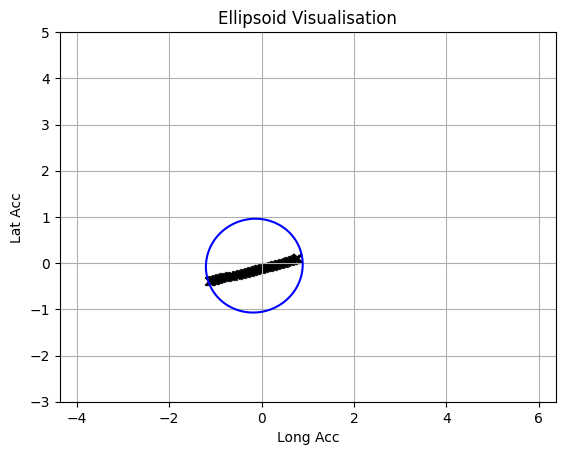

Optimal solution found!


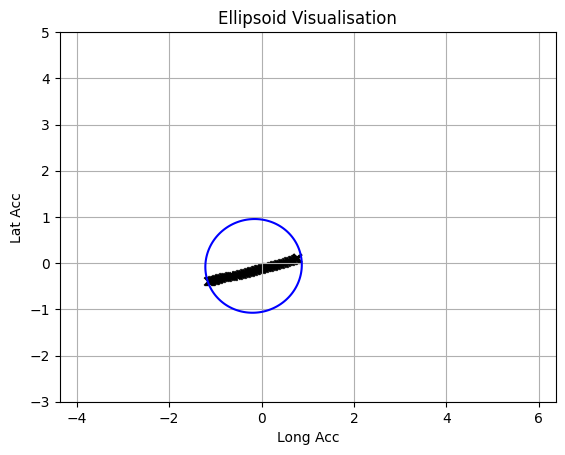

Optimal solution found!


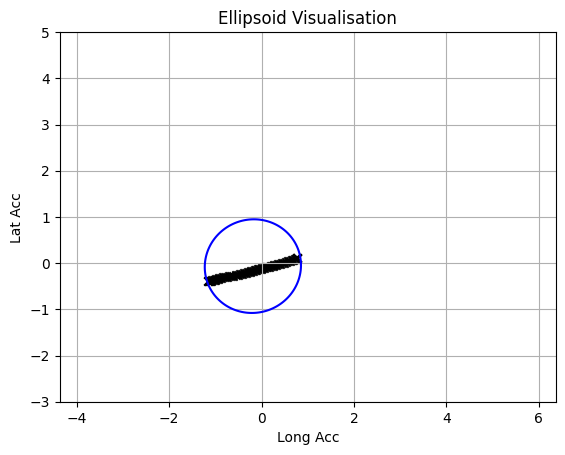

Optimal solution found!


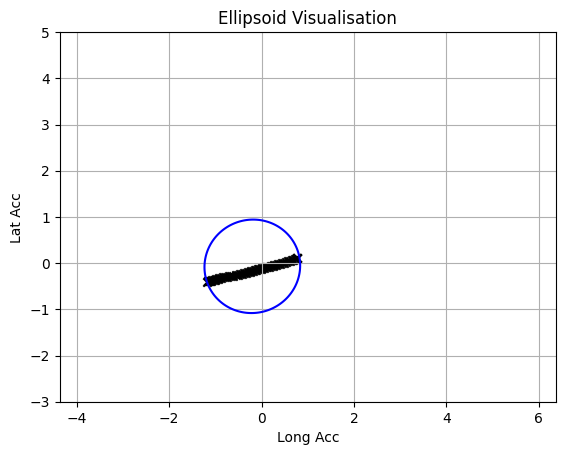

Optimal solution found!


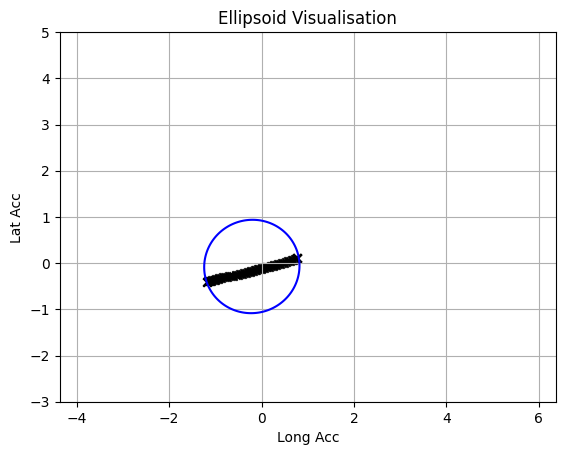

Optimal solution found!


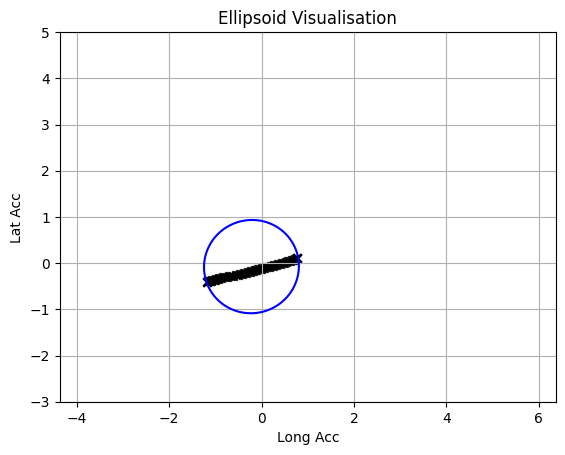

Optimal solution found!


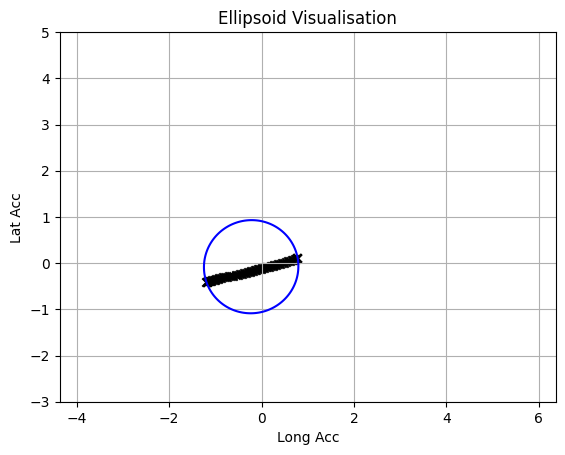

Optimal solution found!


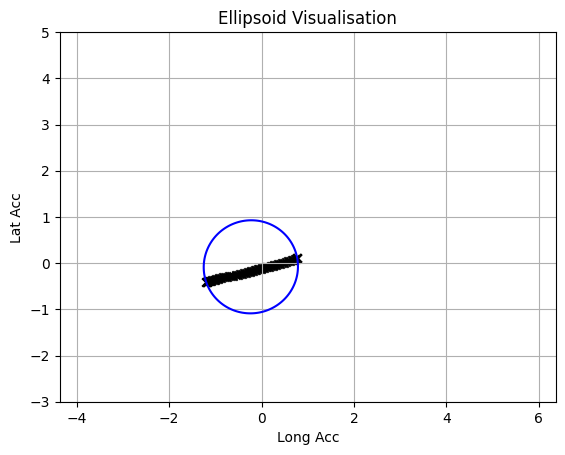

Optimal solution found!


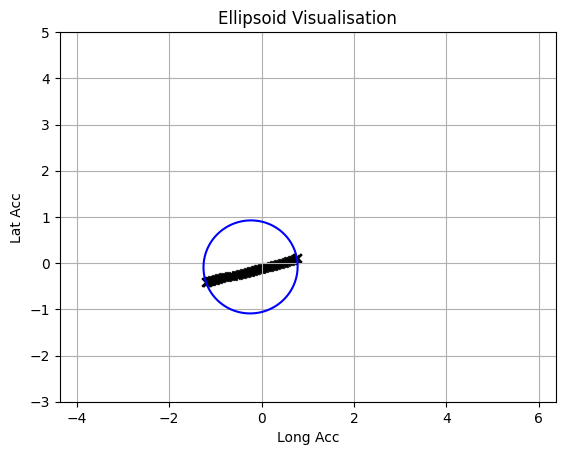

Optimal solution found!


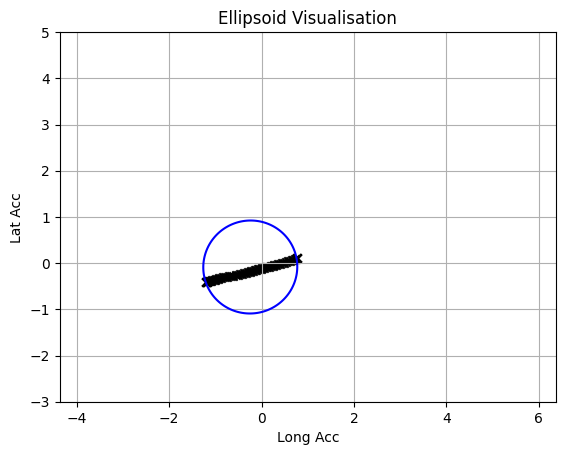

Optimal solution found!


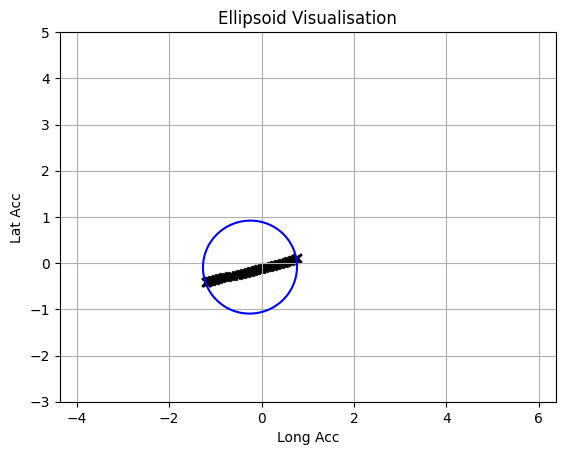

Optimal solution found!


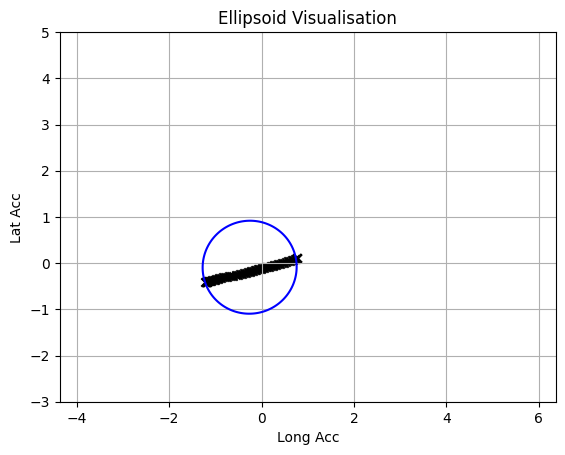

Optimal solution found!


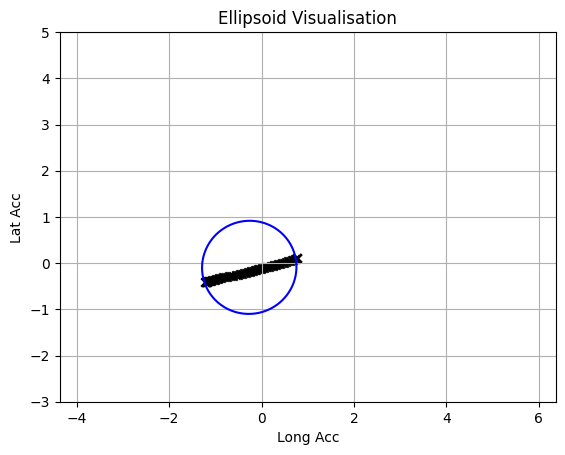

Optimal solution found!


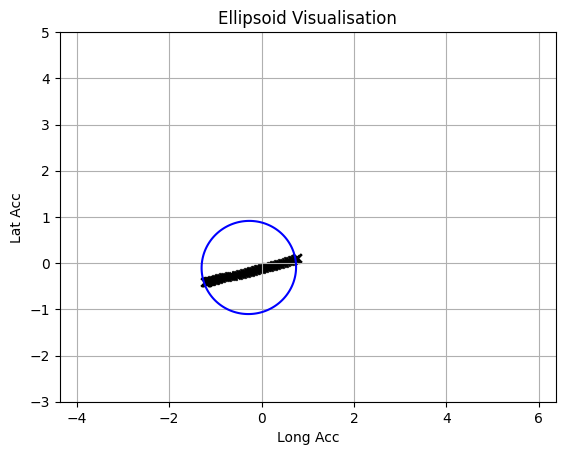

Optimal solution found!


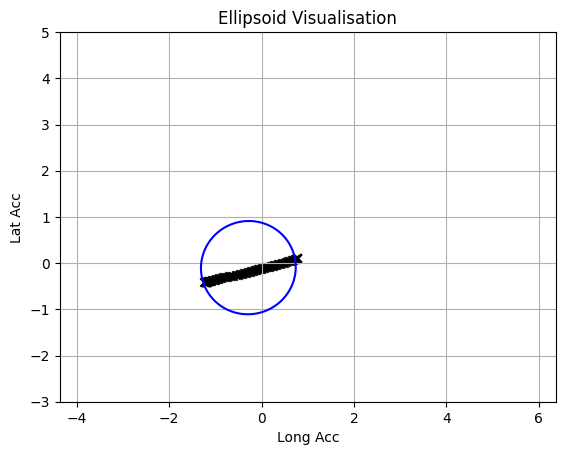

Optimal solution found!


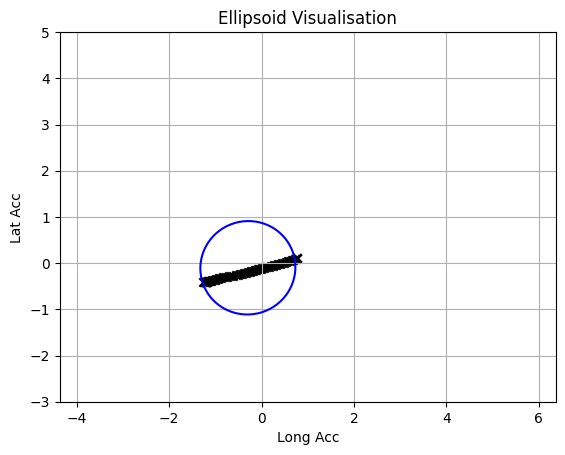

Optimal solution found!


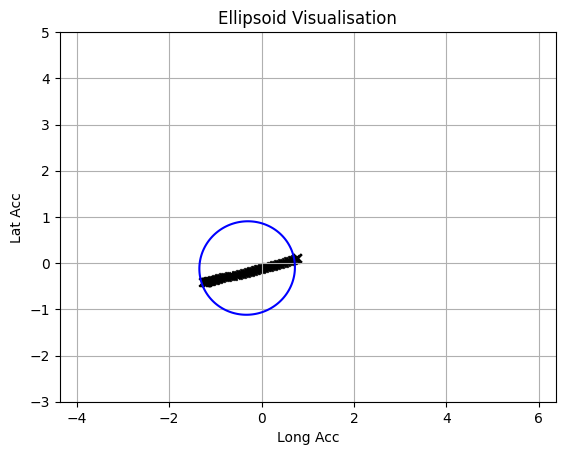

Optimal solution found!


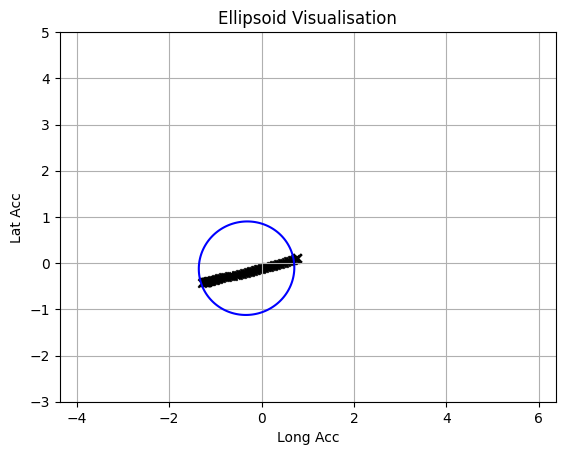

Optimal solution found!


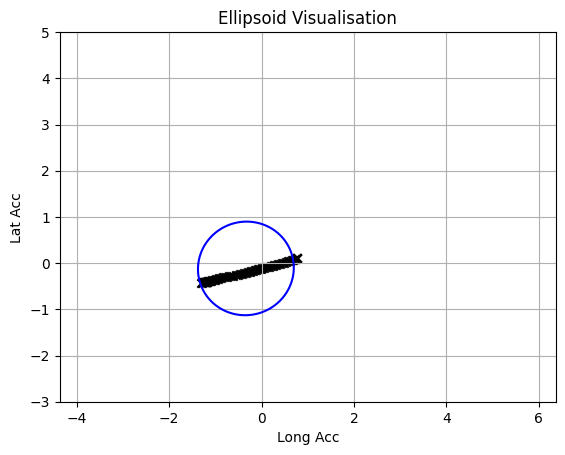

Optimal solution found!


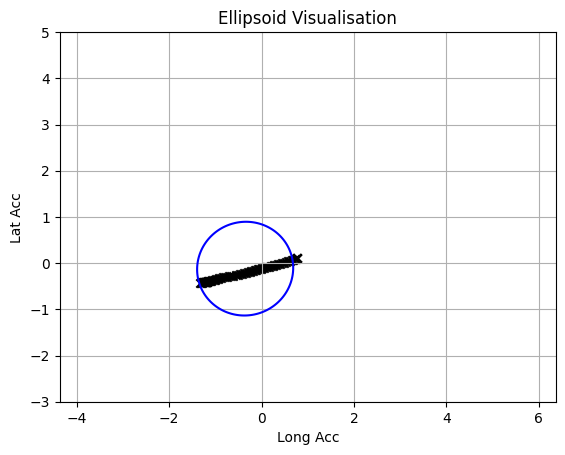

Optimal solution found!


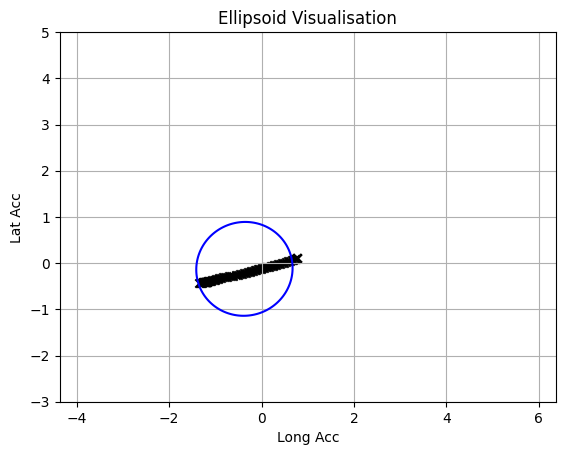

Optimal solution found!


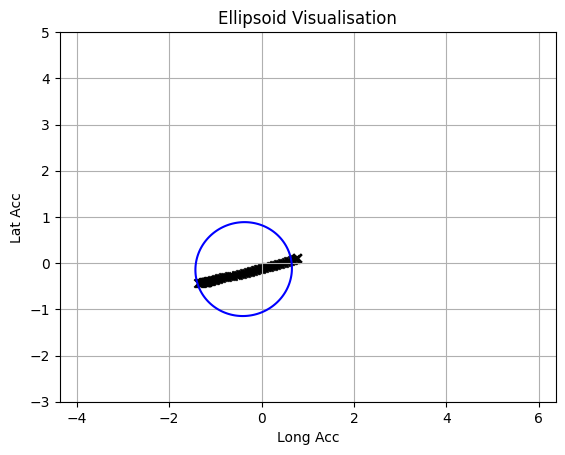

Optimal solution found!


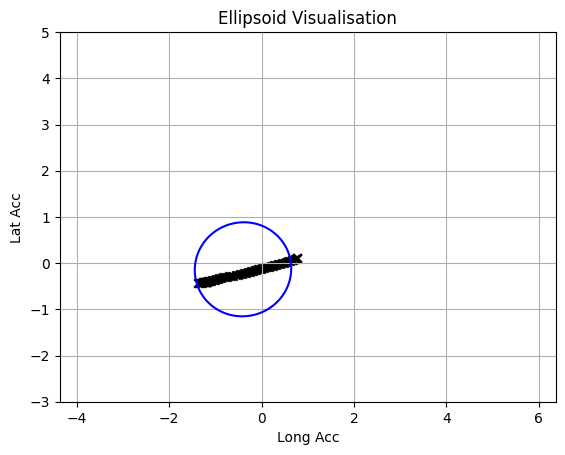

Optimal solution found!


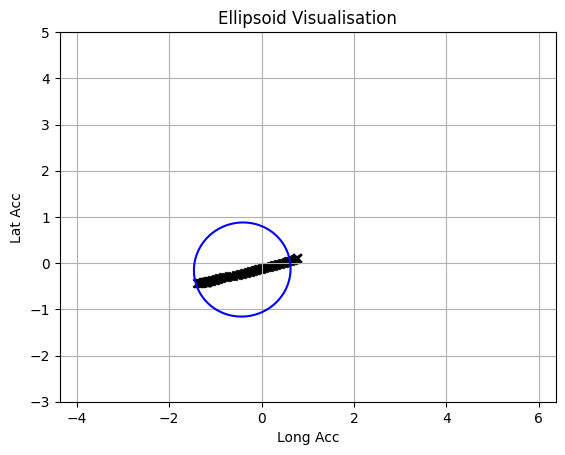

Optimal solution found!


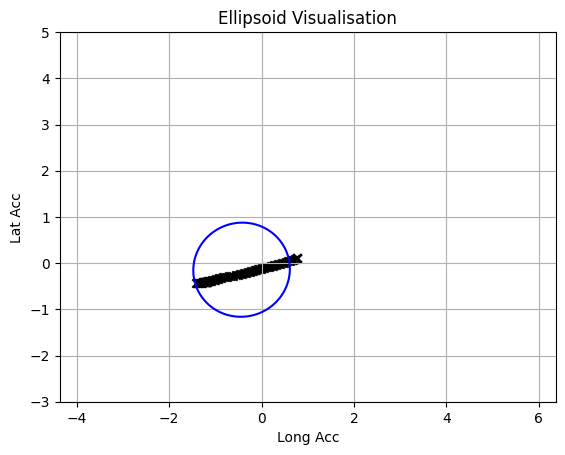

Optimal solution found!


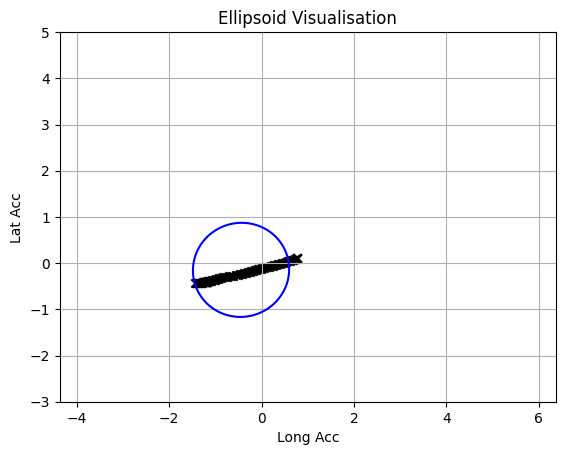

Optimal solution found!


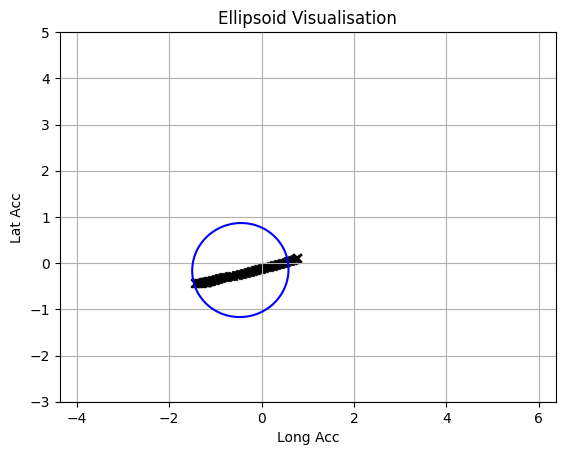

Optimal solution found!


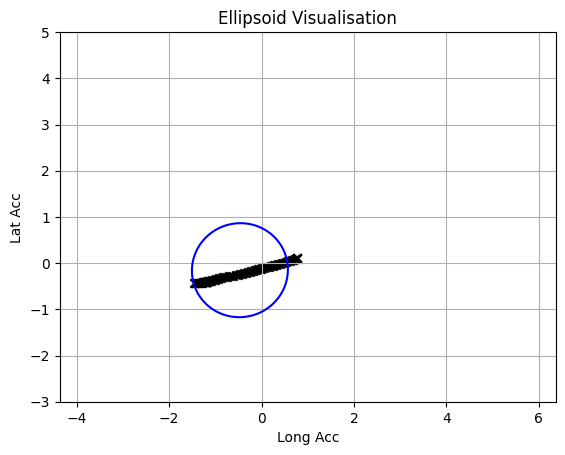

Optimal solution found!


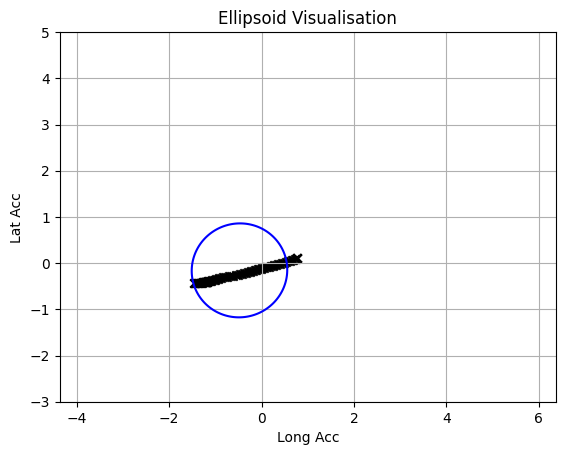

Optimal solution found!


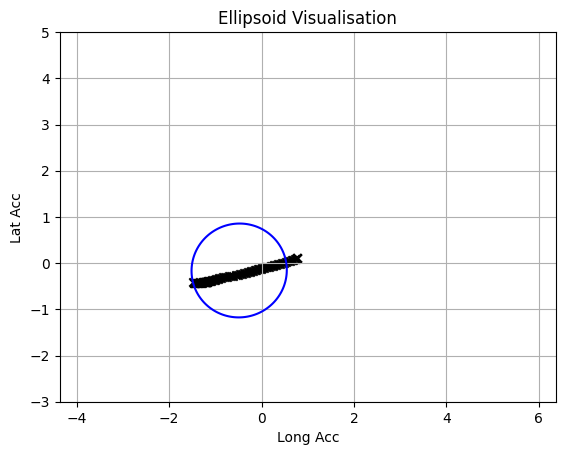

Optimal solution found!


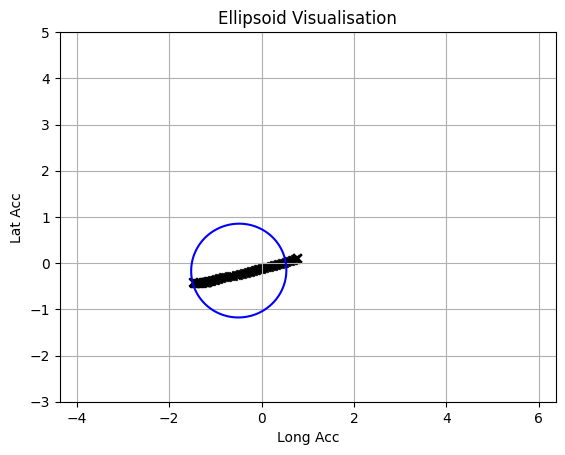

Optimal solution found!


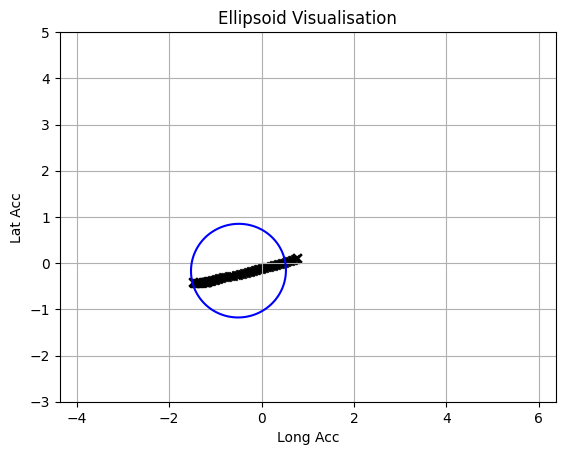

Optimal solution found!


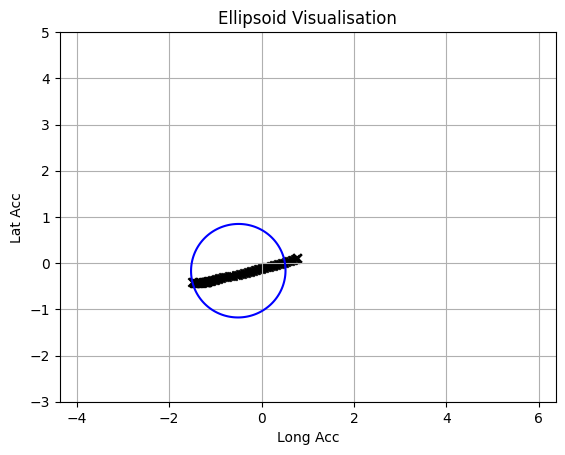

Optimal solution found!


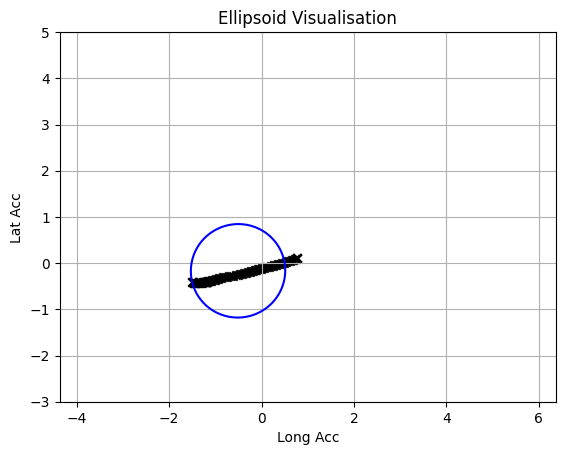

Optimal solution found!


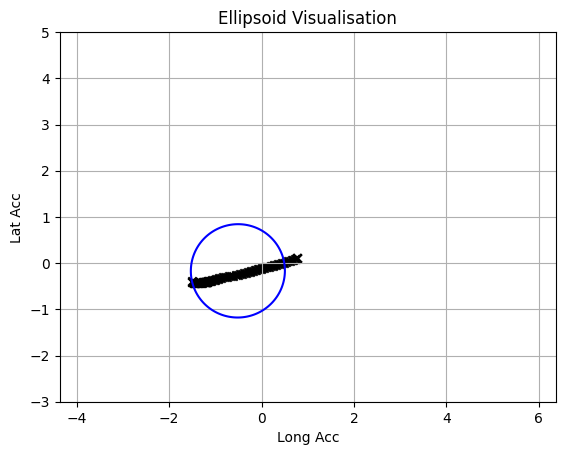

Optimal solution found!


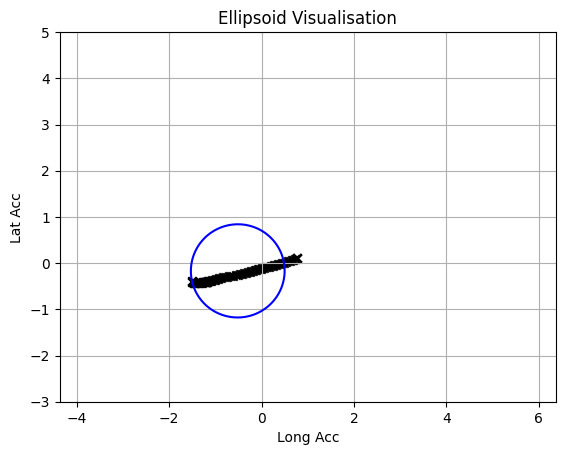

Optimal solution found!


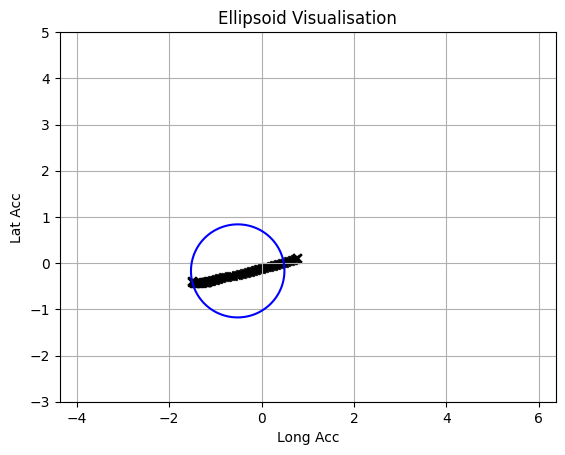

Optimal solution found!


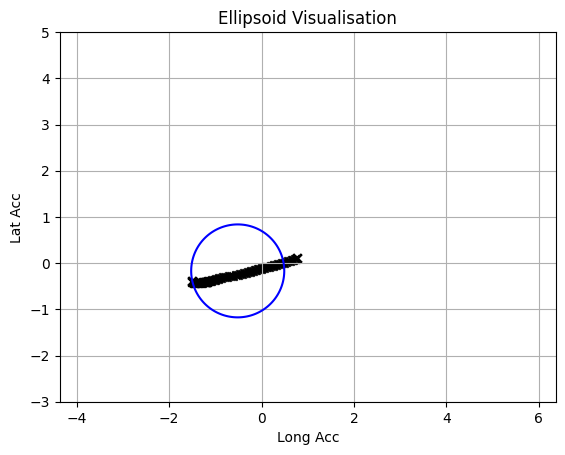

Optimal solution found!


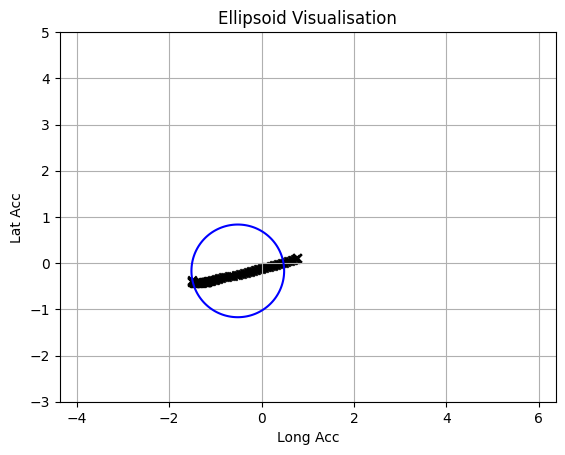

Optimal solution found!


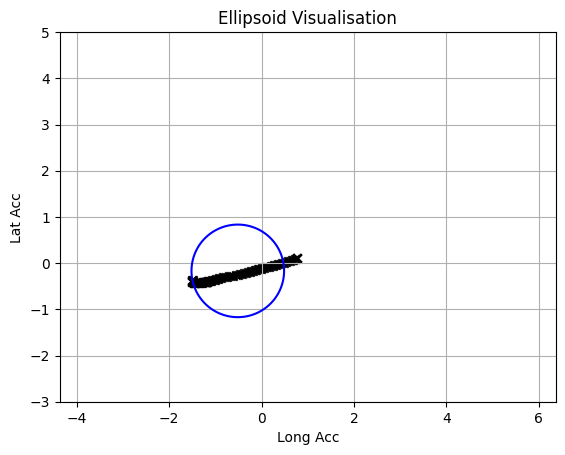

Optimal solution found!


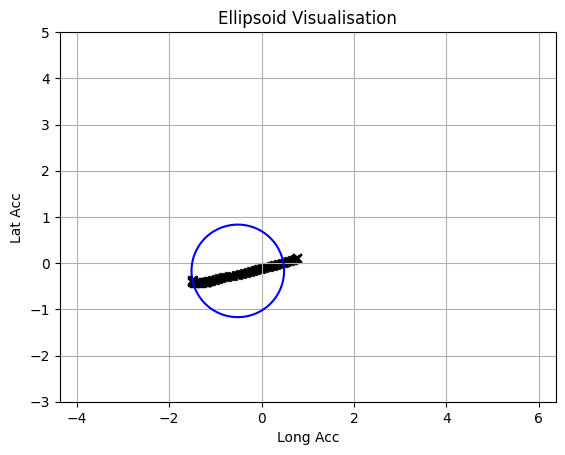

Optimal solution found!


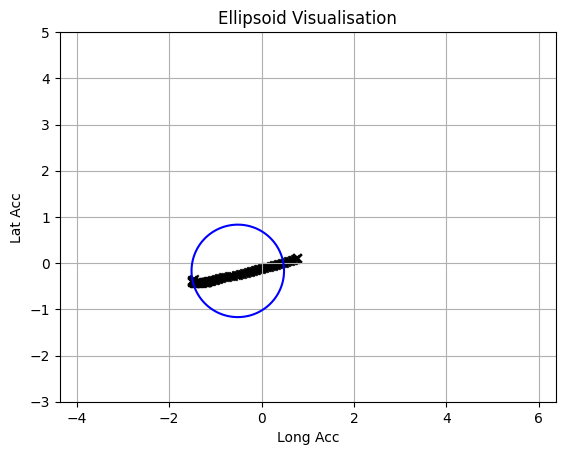

Optimal solution found!


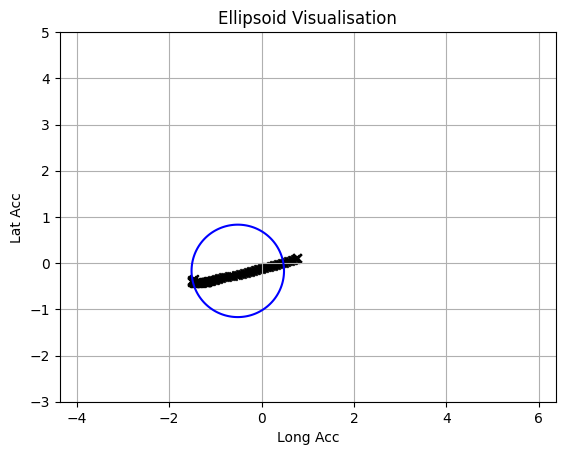

Optimal solution found!


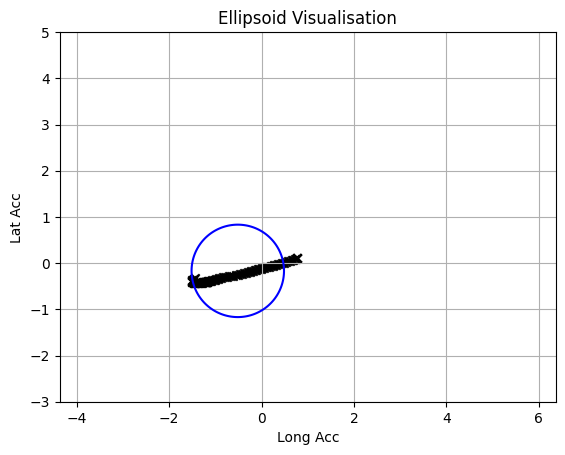

Optimal solution found!


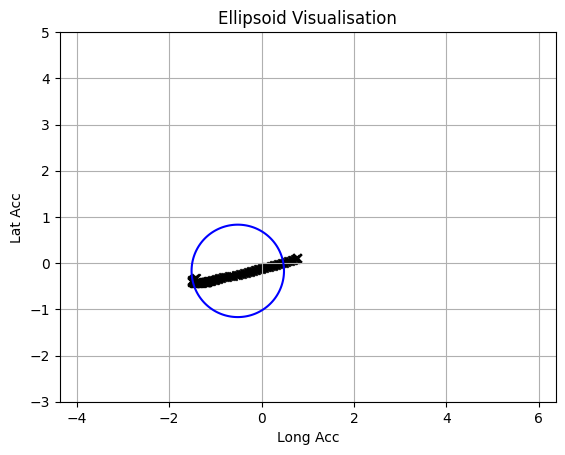

Optimal solution found!


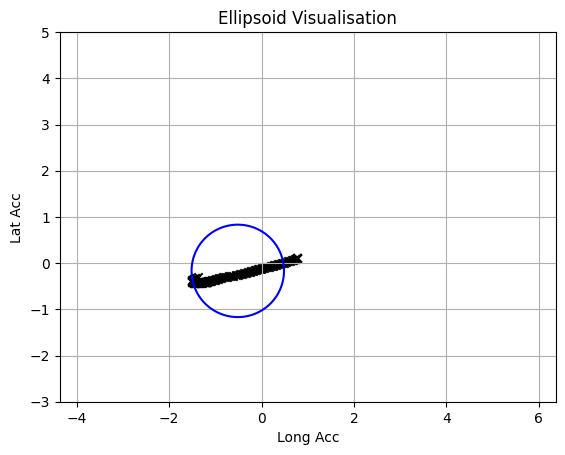

Optimal solution found!


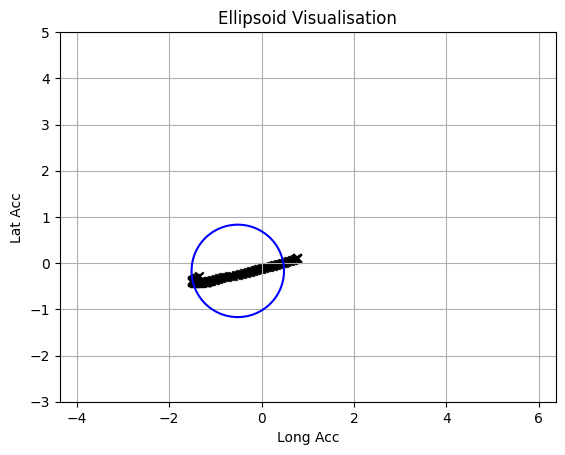

Optimal solution found!


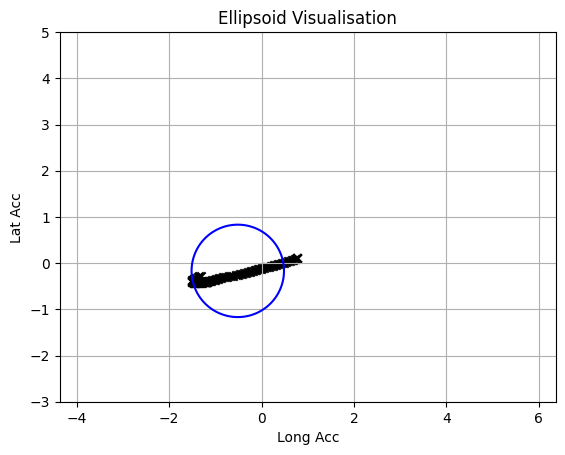

Optimal solution found!


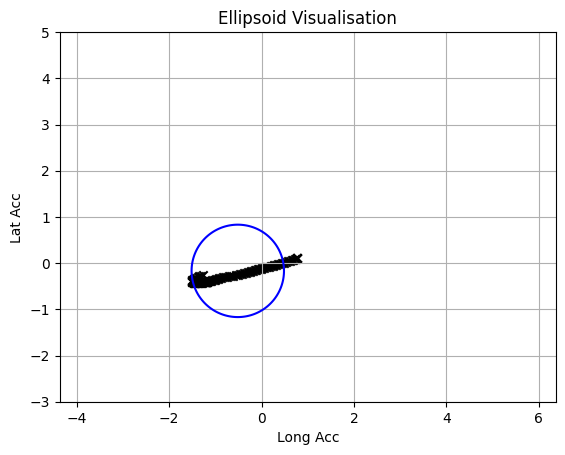

Optimal solution found!


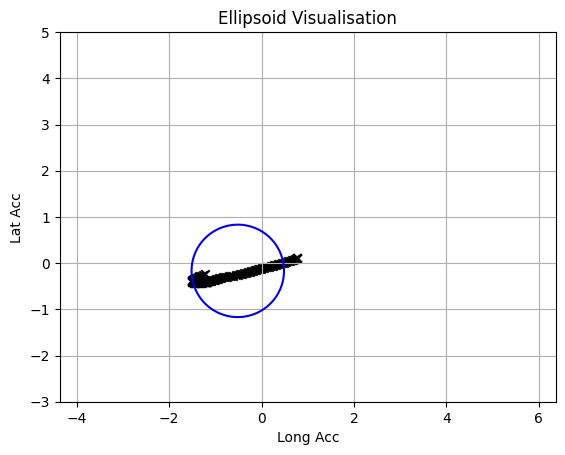

Optimal solution found!


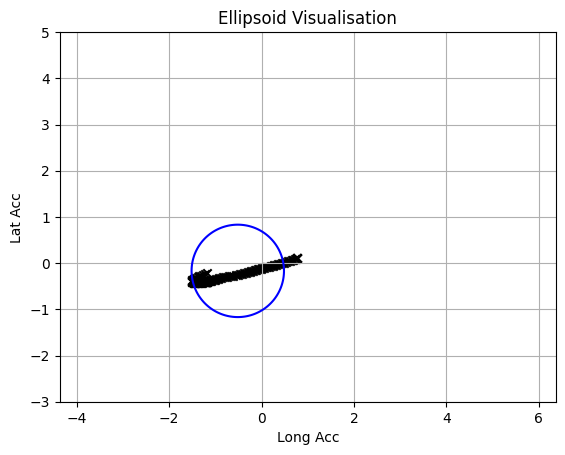

Optimal solution found!


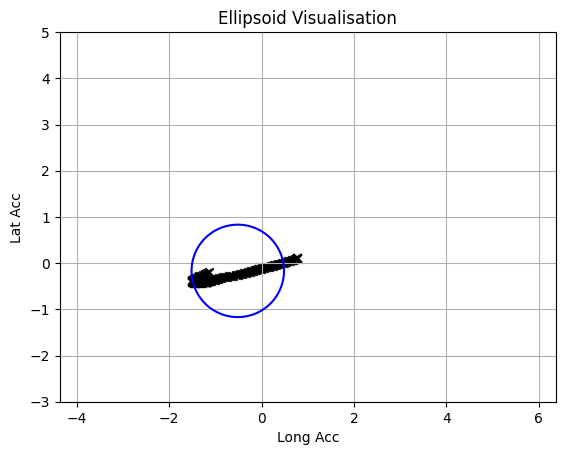

Optimal solution found!


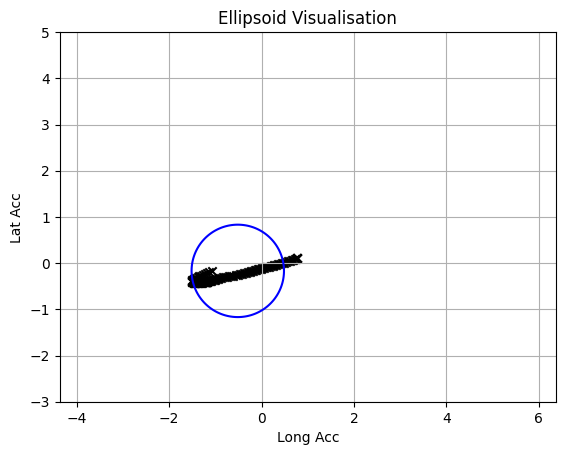

Optimal solution found!


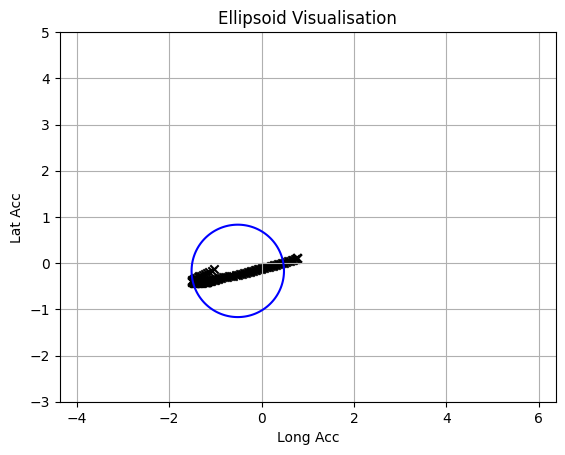

Optimal solution found!


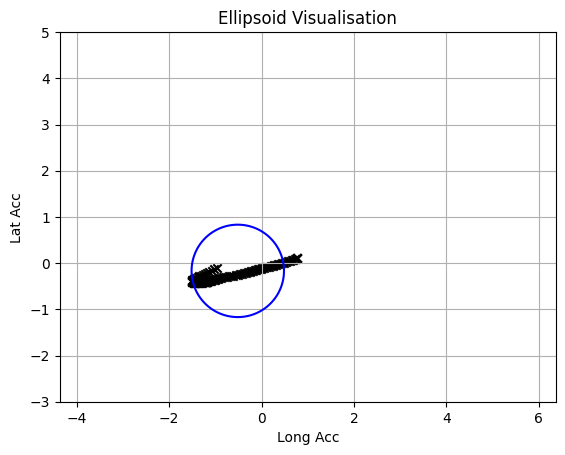

Optimal solution found!


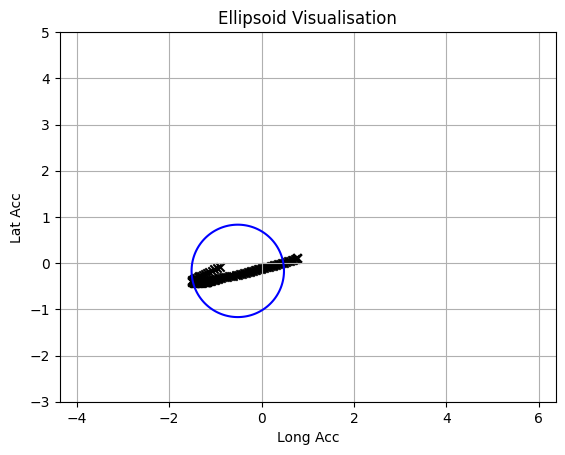

Optimal solution found!


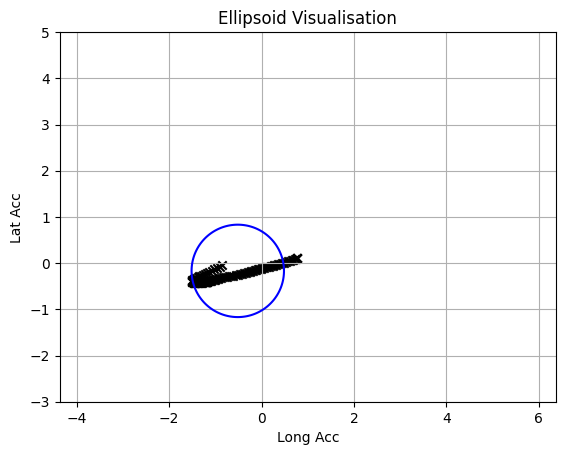

Optimal solution found!


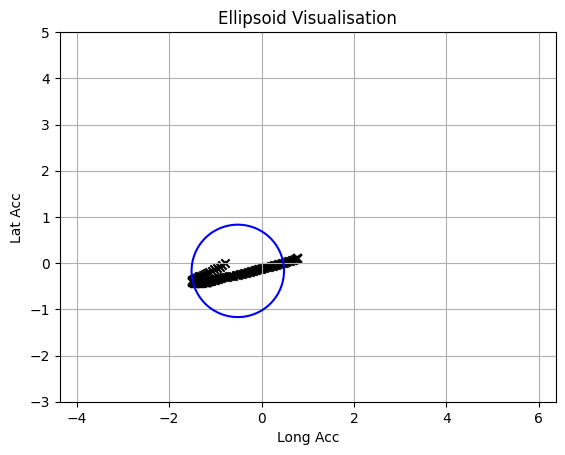

Optimal solution found!


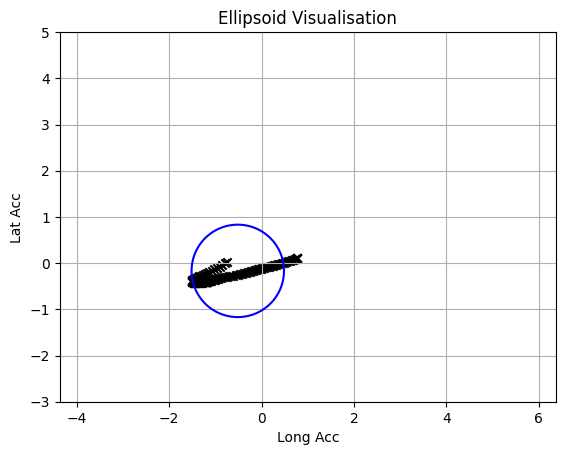

Optimal solution found!


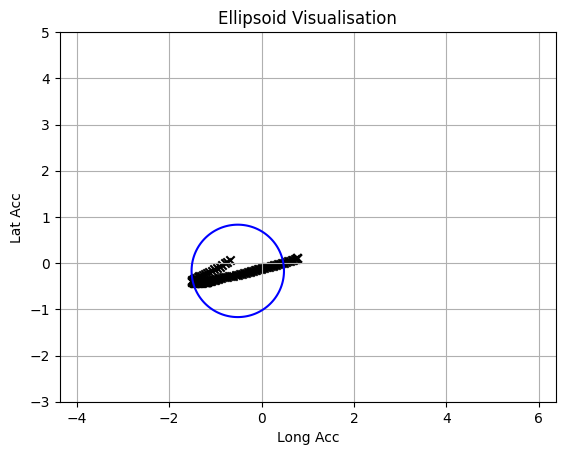

Optimal solution found!


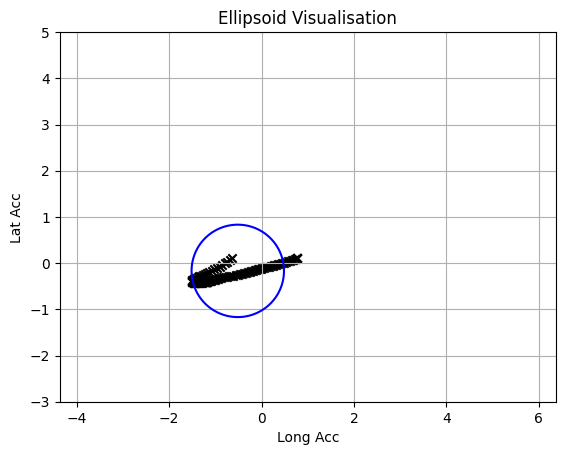

Optimal solution found!


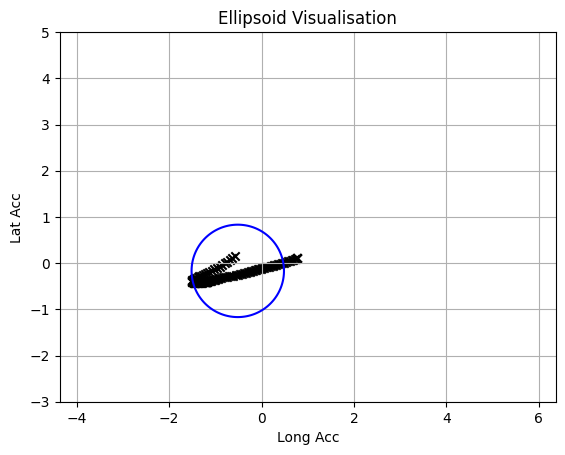

Optimal solution found!


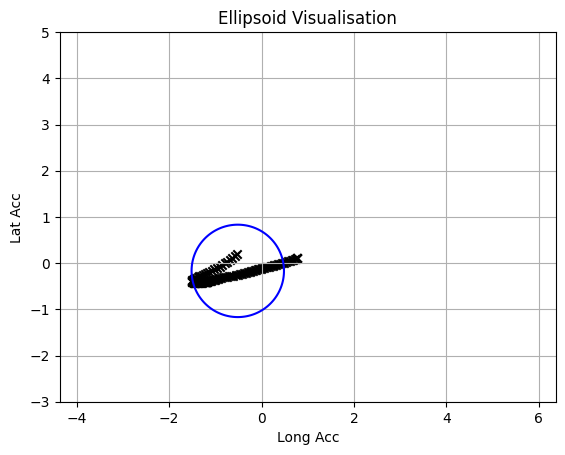

Optimal solution found!


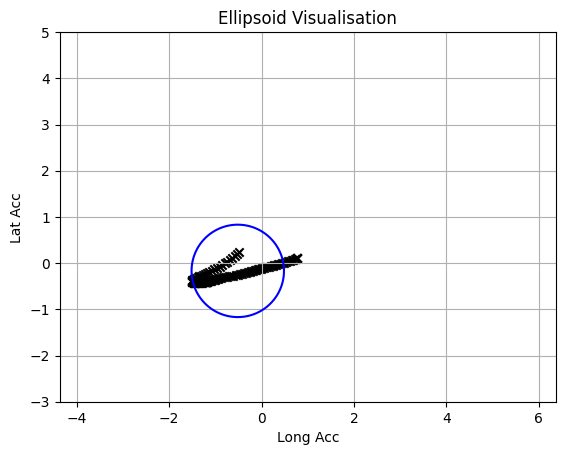

Optimal solution found!


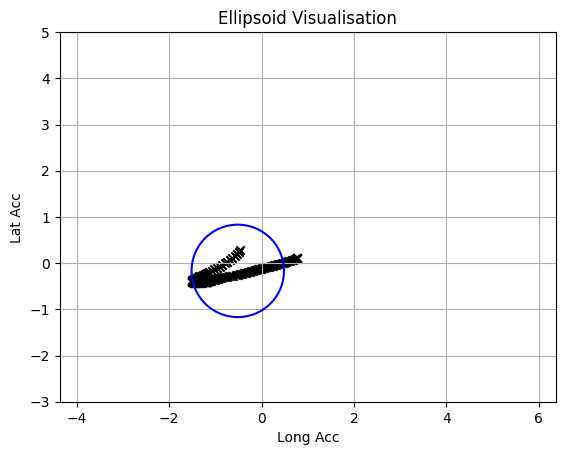

Optimal solution found!


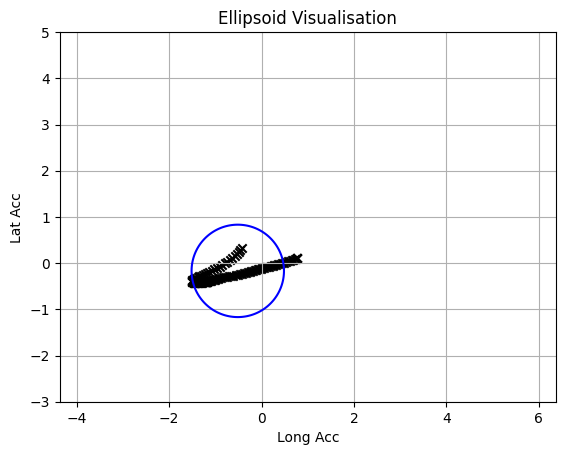

Optimal solution found!


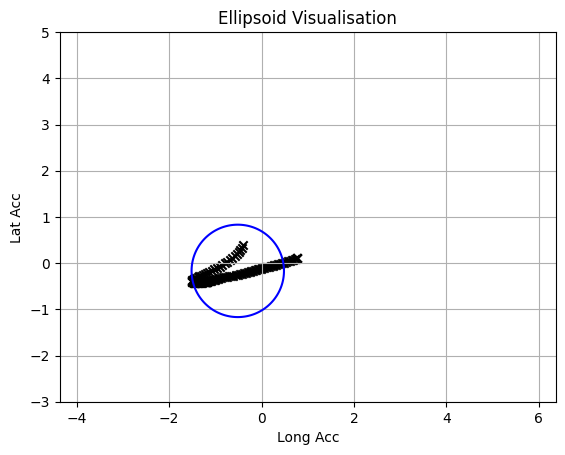

Optimal solution found!


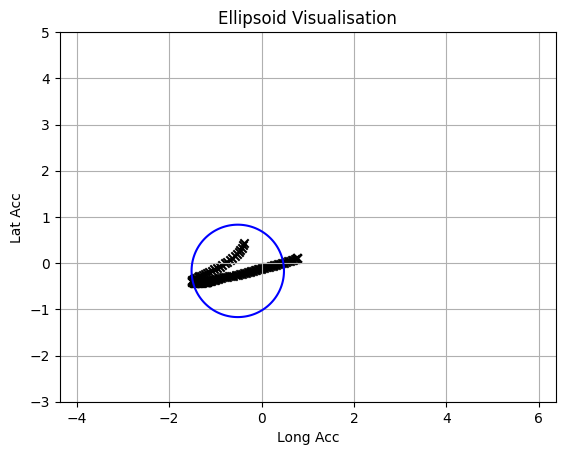

Optimal solution found!


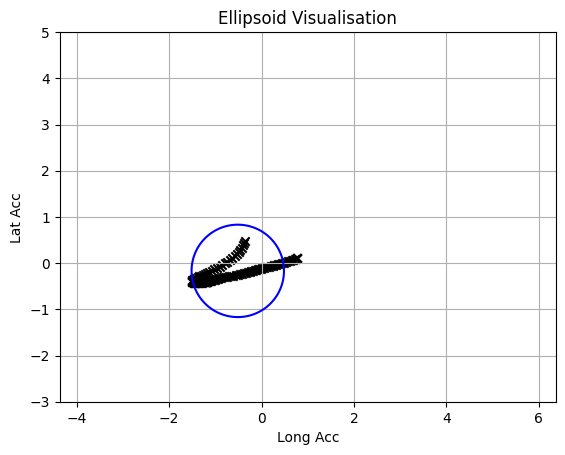

Optimal solution found!


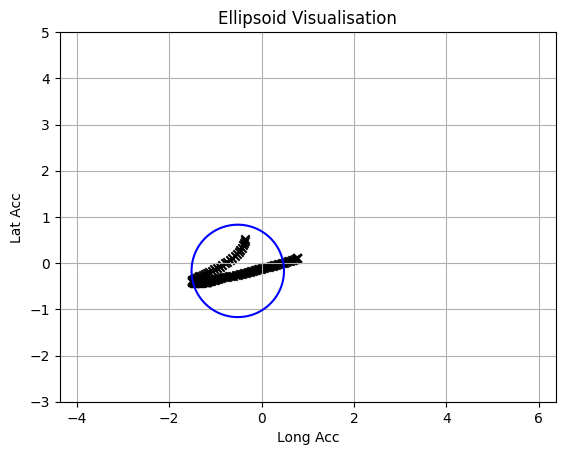

Optimal solution found!


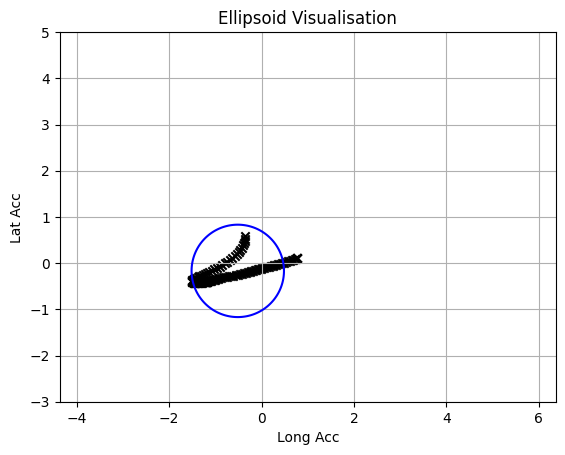

Optimal solution found!


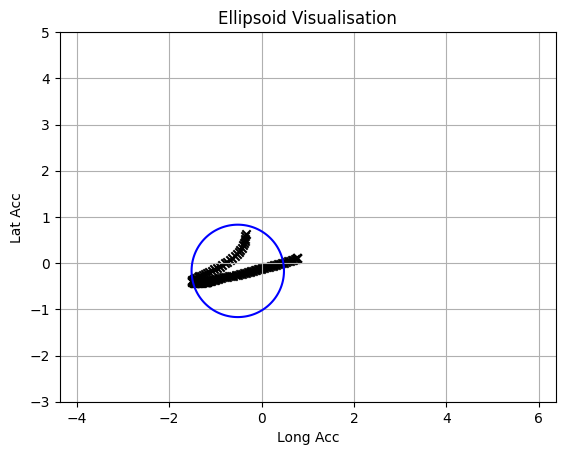

Optimal solution found!


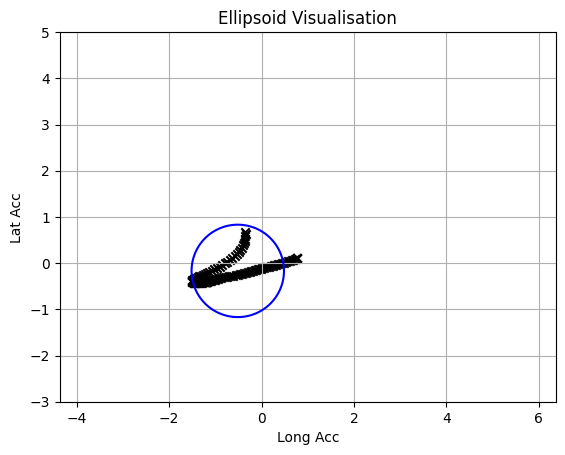

Optimal solution found!


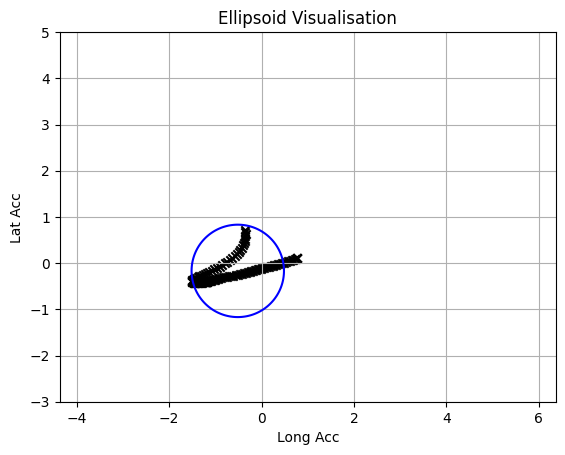

Optimal solution found!


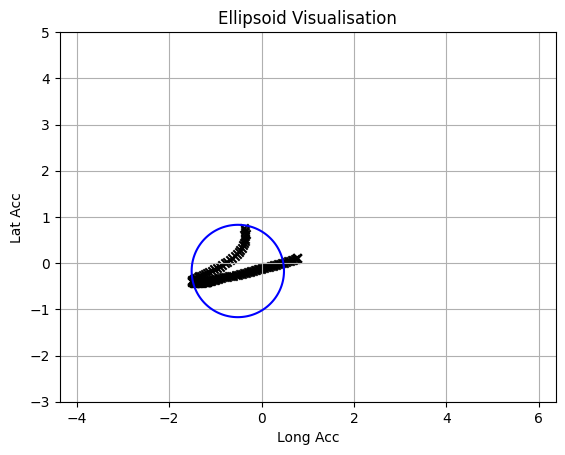

Optimal solution found!


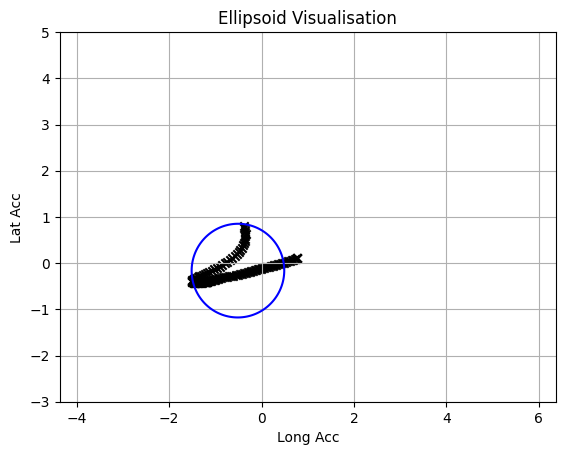

Optimal solution found!


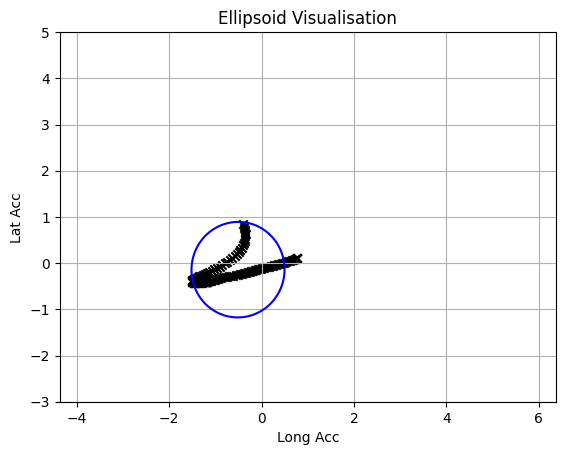

Optimal solution found!


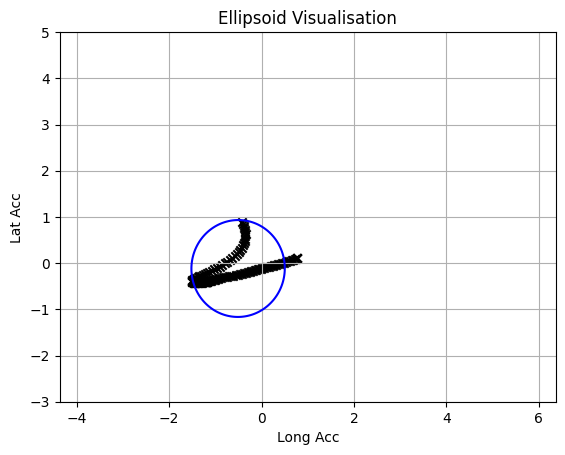

Optimal solution found!


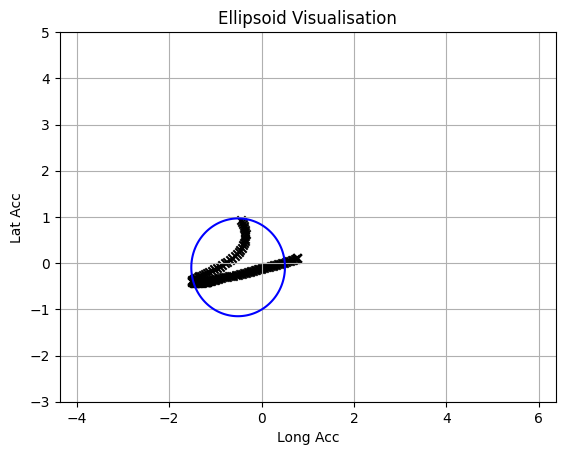

Optimal solution found!


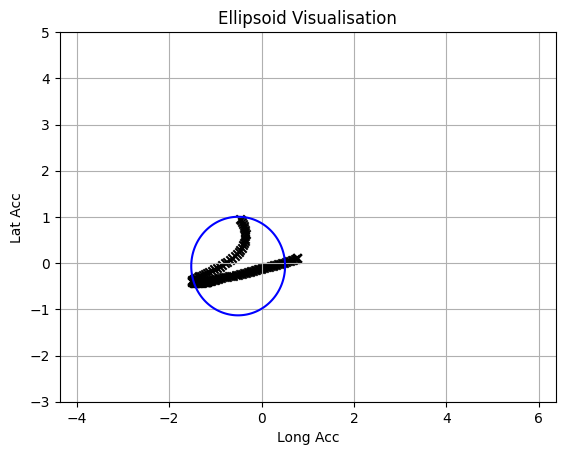

Optimal solution found!


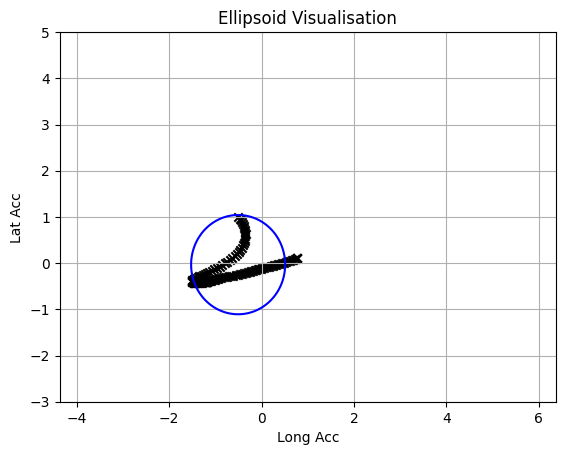

Optimal solution found!


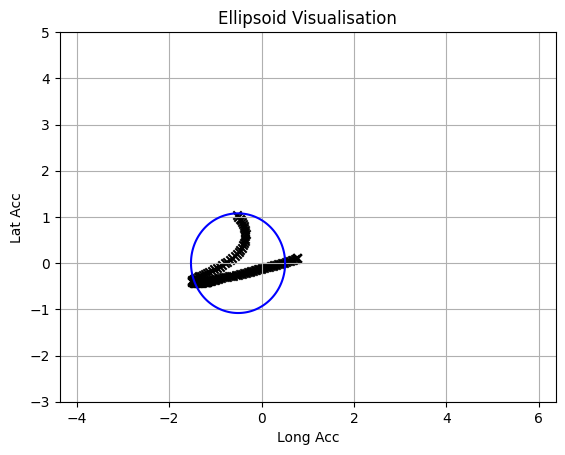

Optimal solution found!


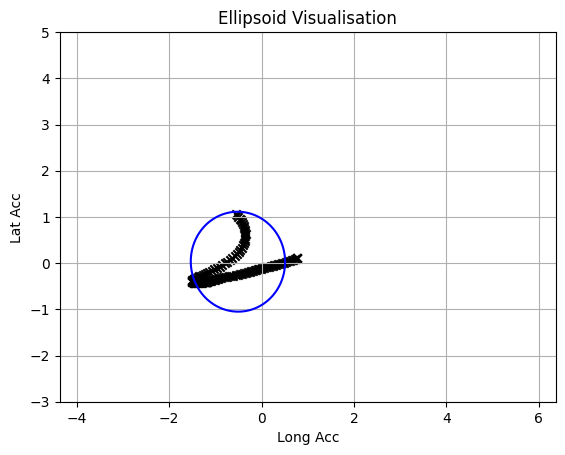

Optimal solution found!


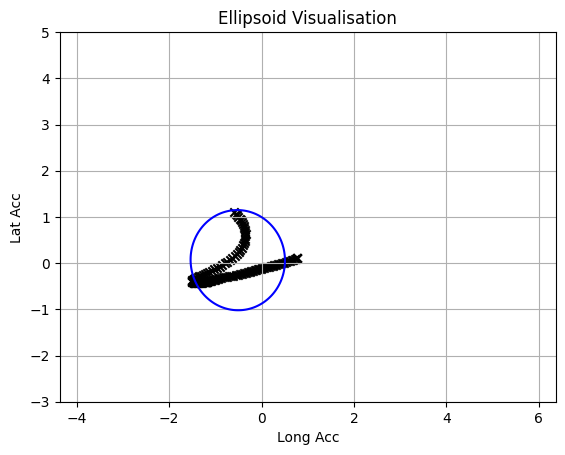

Optimal solution found!


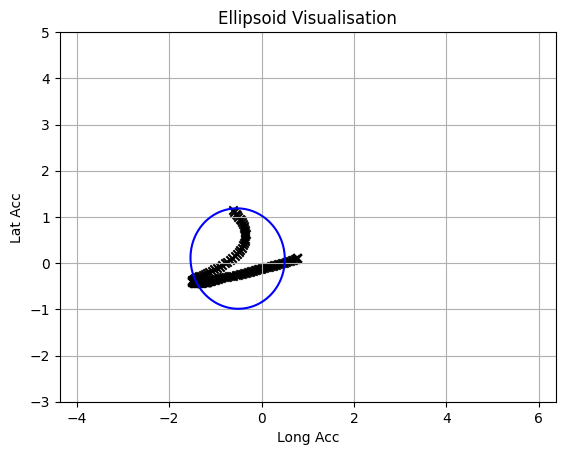

Optimal solution found!


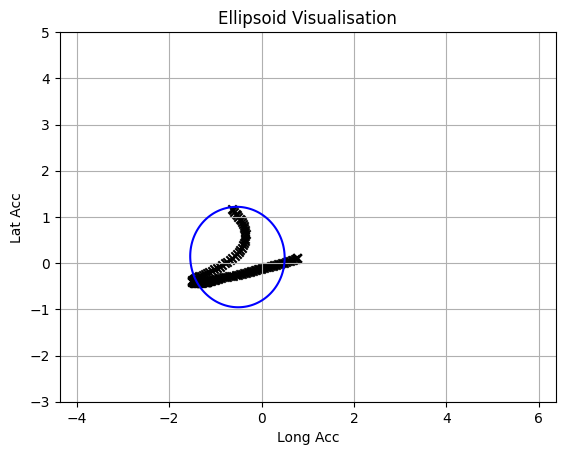

Optimal solution found!


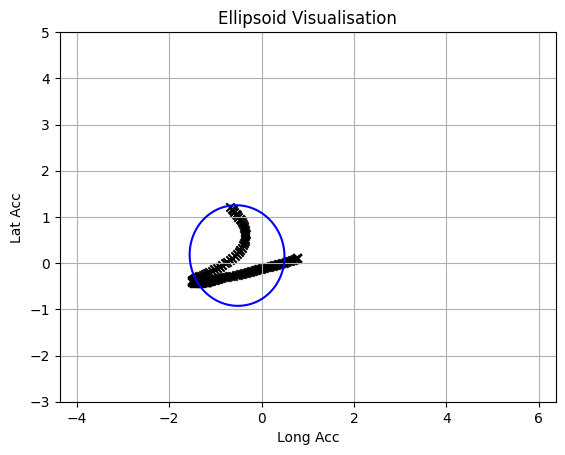

Optimal solution found!


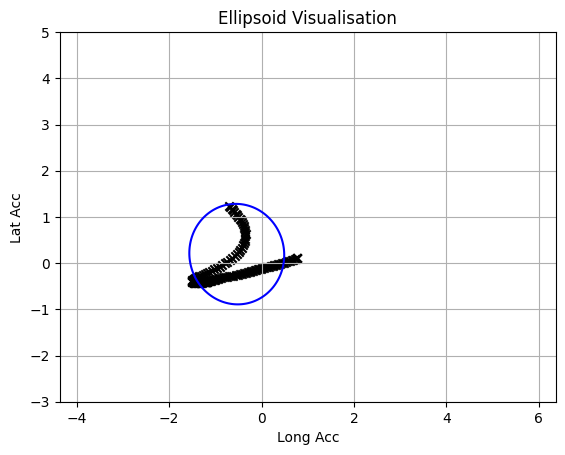

Optimal solution found!


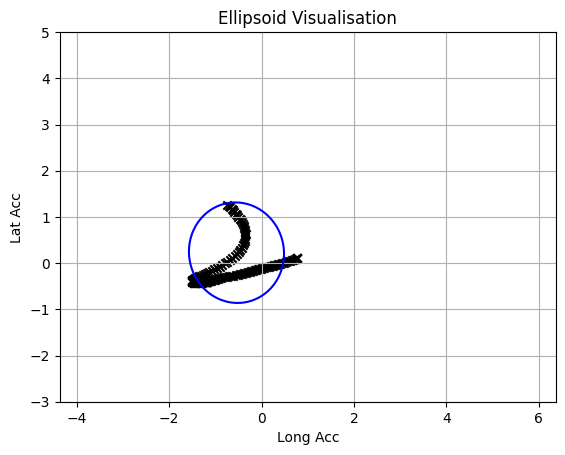

Optimal solution found!


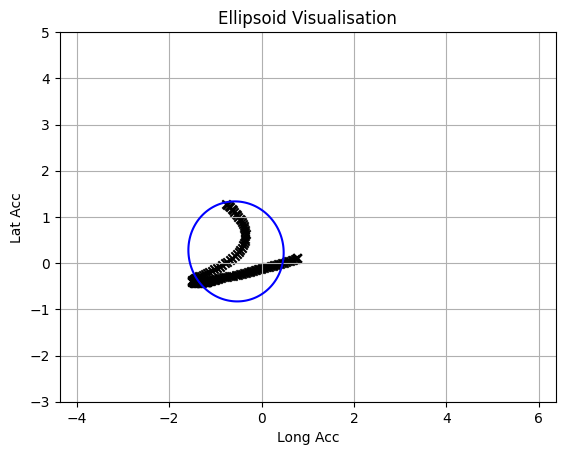

Optimal solution found!


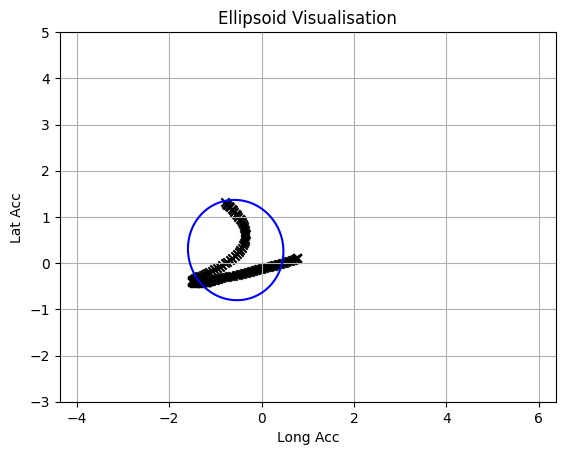

Optimal solution found!


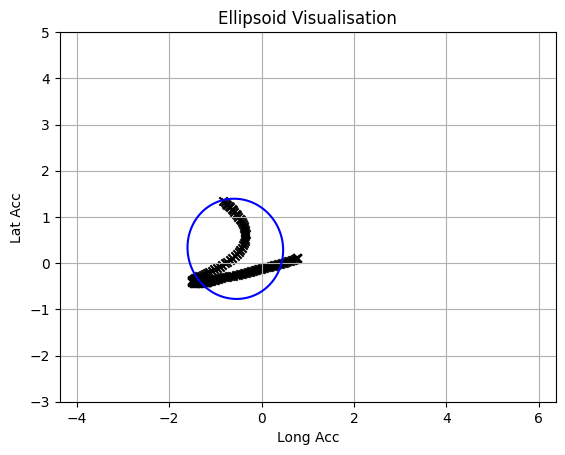

Optimal solution found!


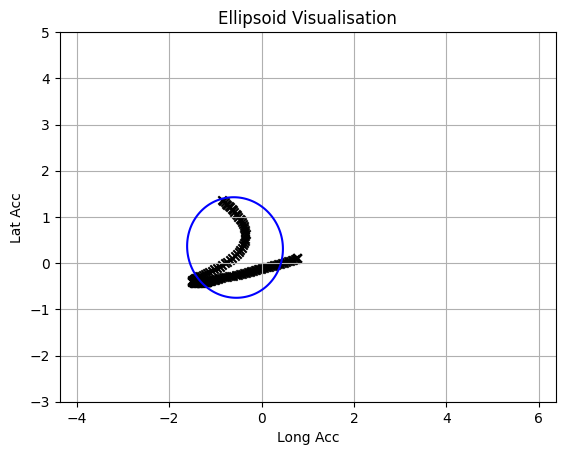

Optimal solution found!


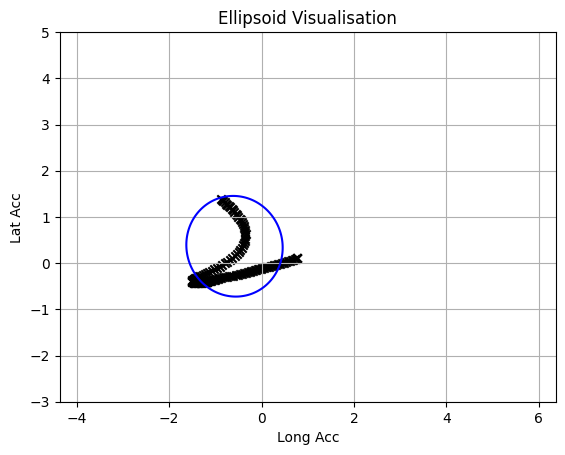

Optimal solution found!


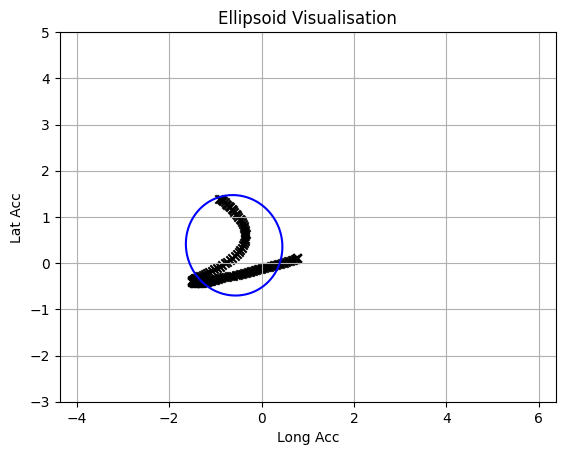

Optimal solution found!


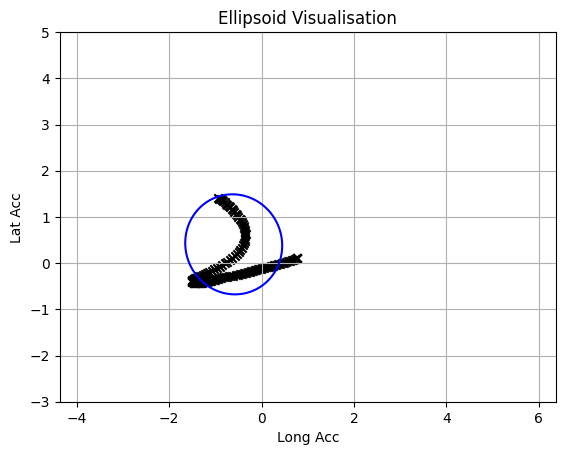

Optimal solution found!


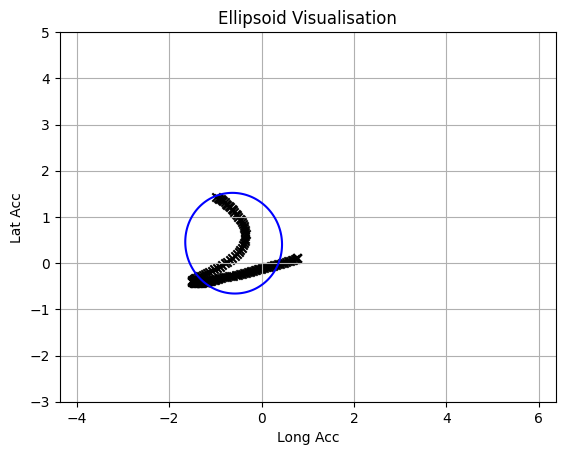

Optimal solution found!


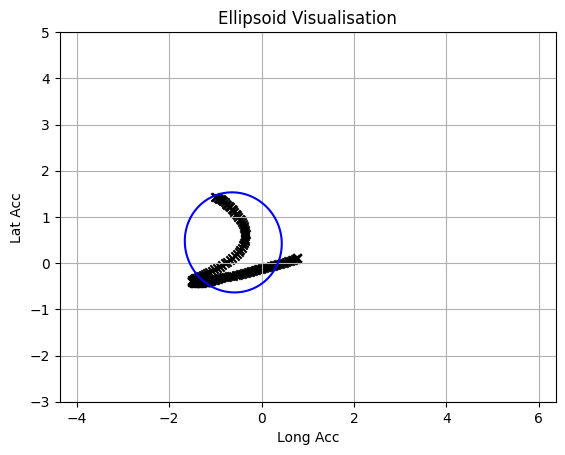

Optimal solution found!


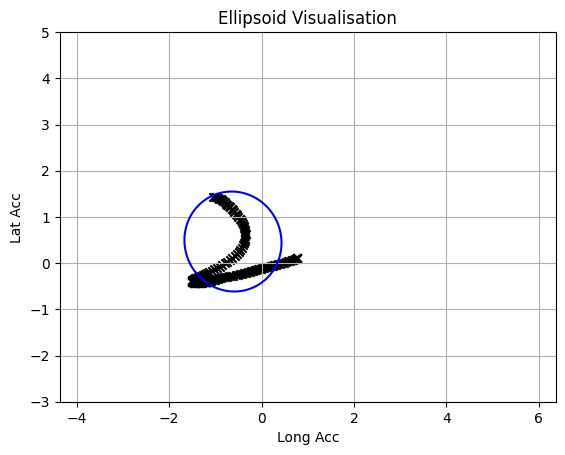

Optimal solution found!


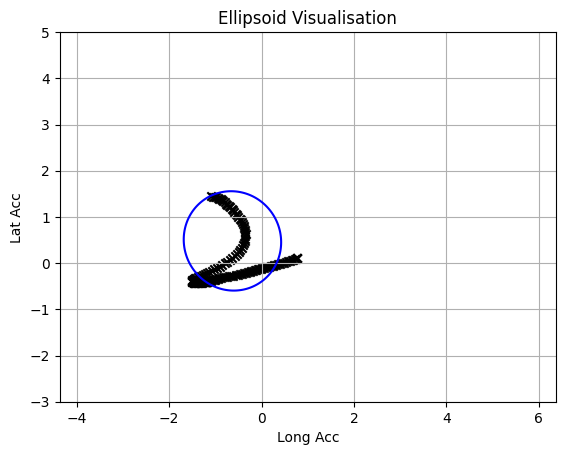

Optimal solution found!


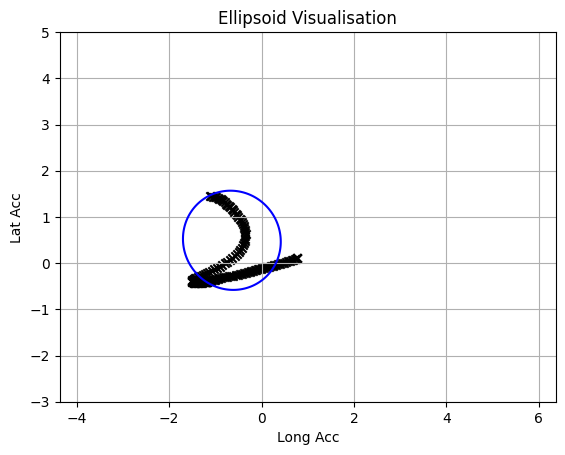

Optimal solution found!


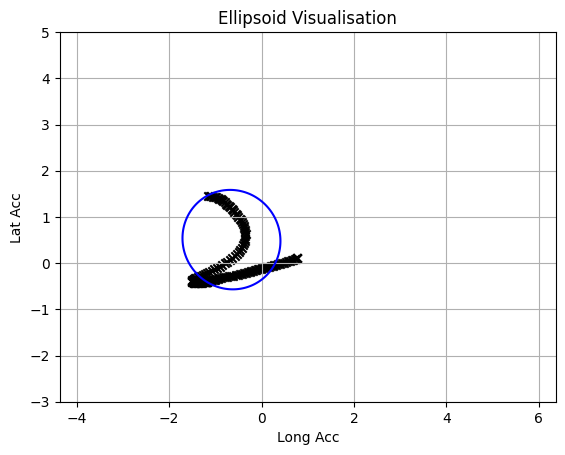

Optimal solution found!


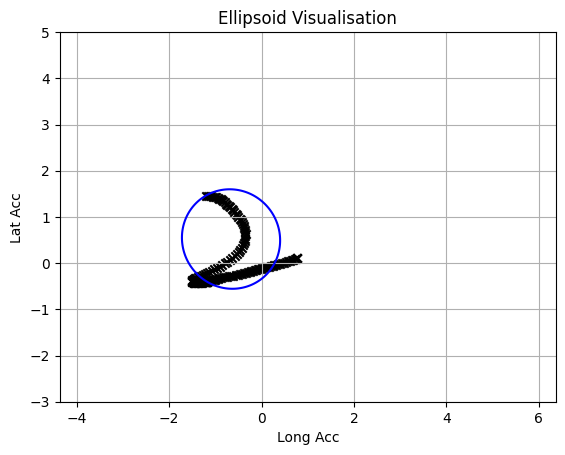

Optimal solution found!


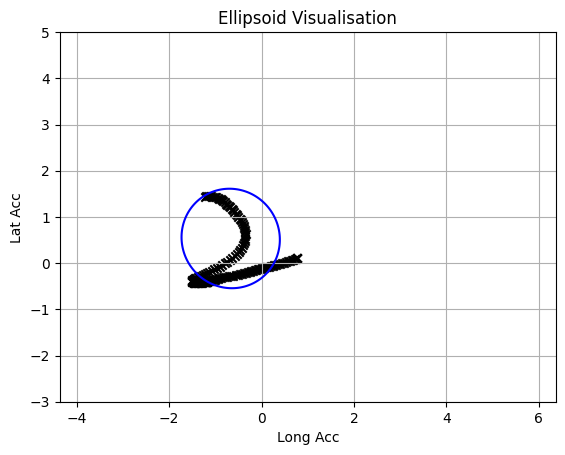

Optimal solution found!


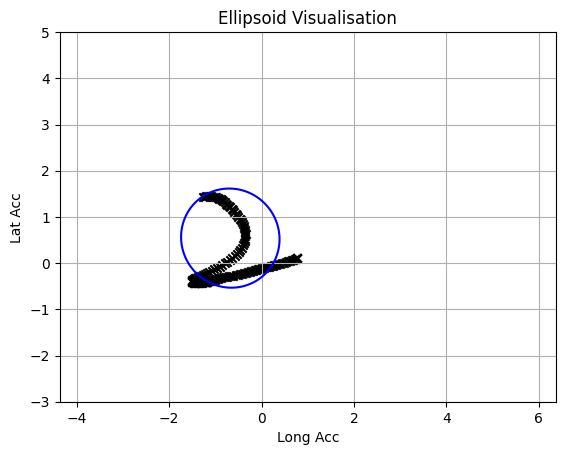

Optimal solution found!


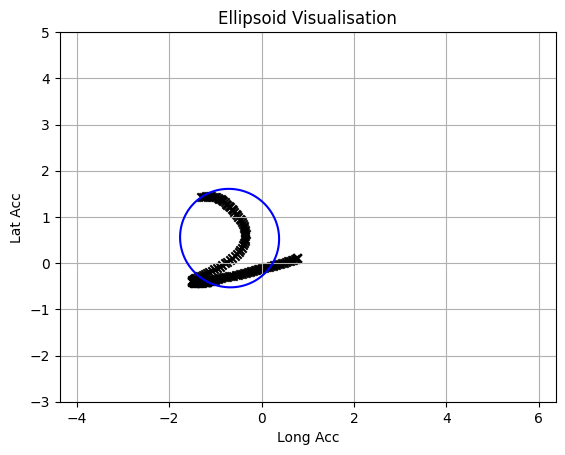

Optimal solution found!


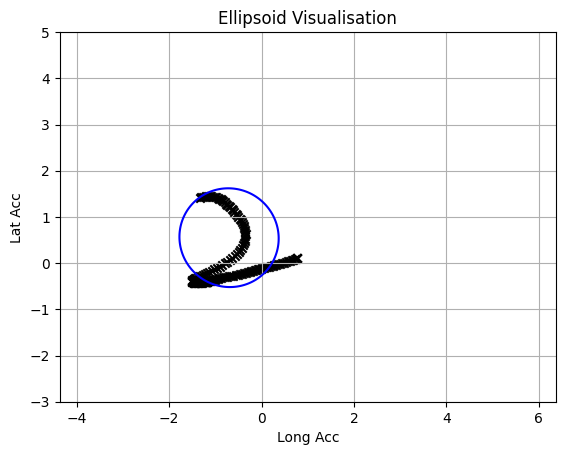

Optimal solution found!


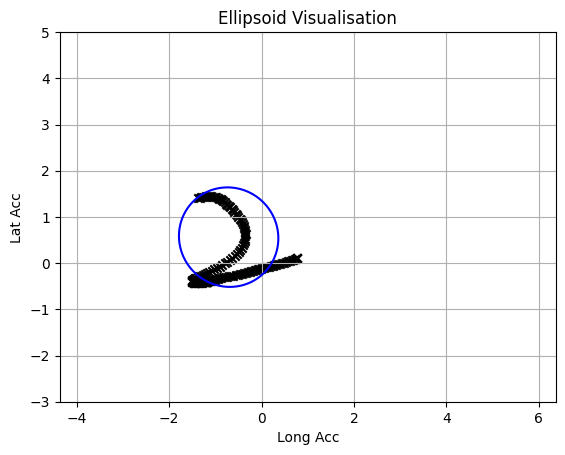

Optimal solution found!


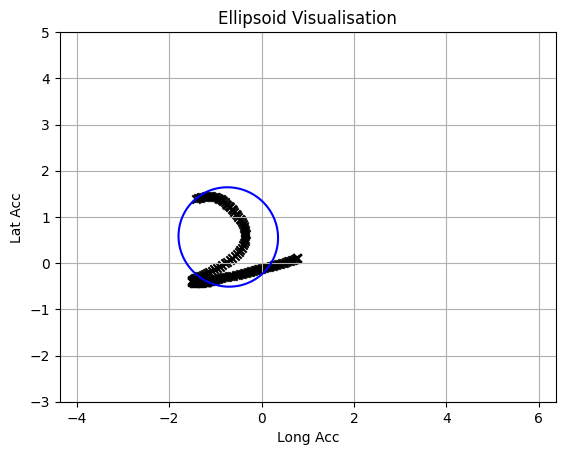

Optimal solution found!


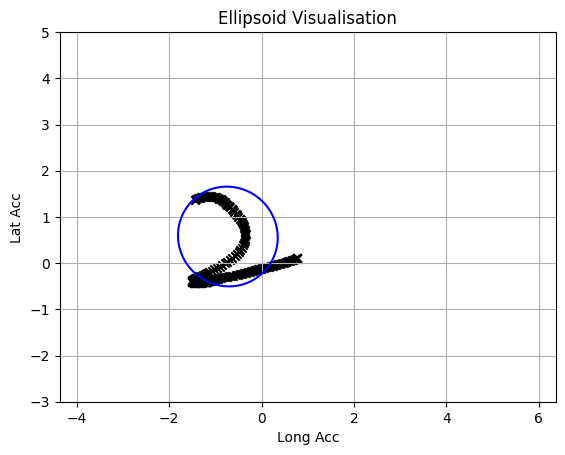

Optimal solution found!


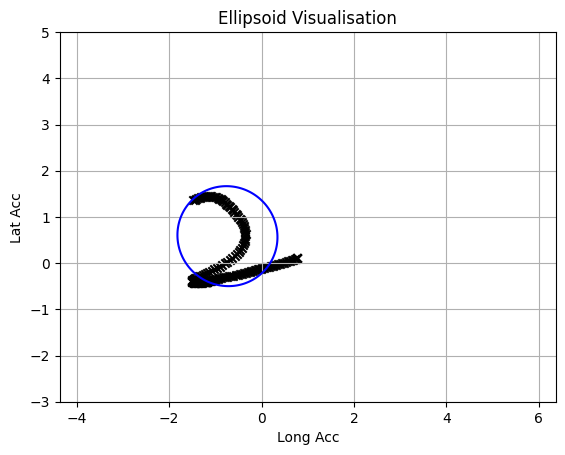

Optimal solution found!


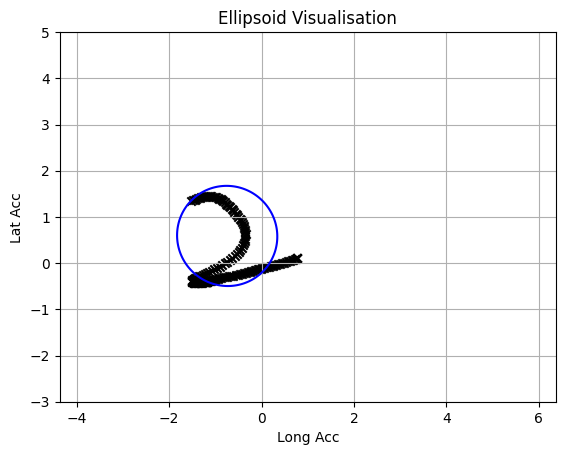

Optimal solution found!


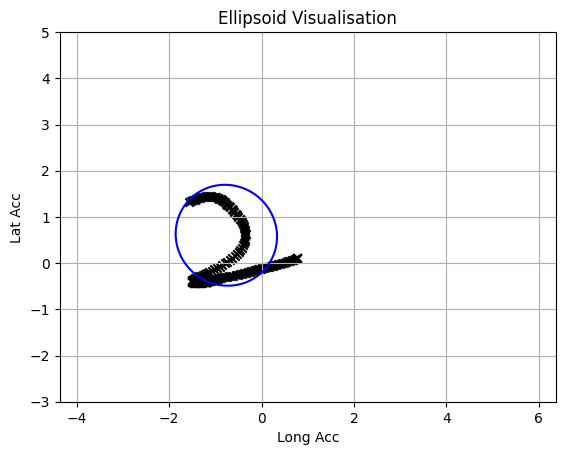

Optimal solution found!


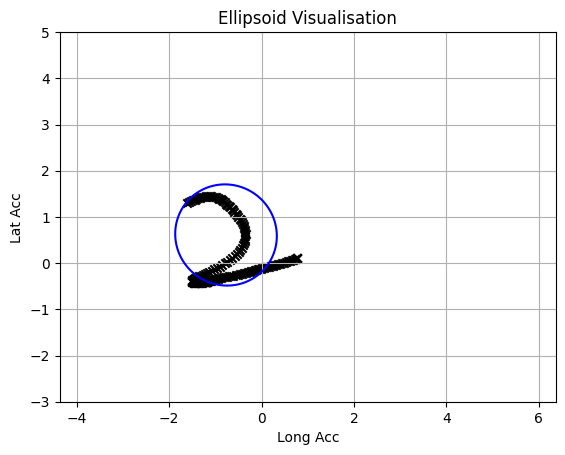

Optimal solution found!


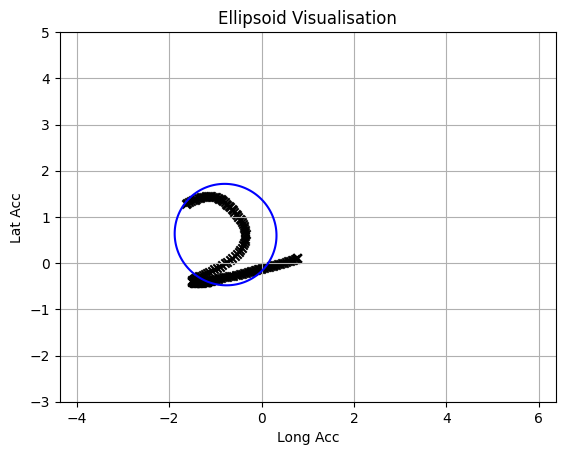

Optimal solution found!


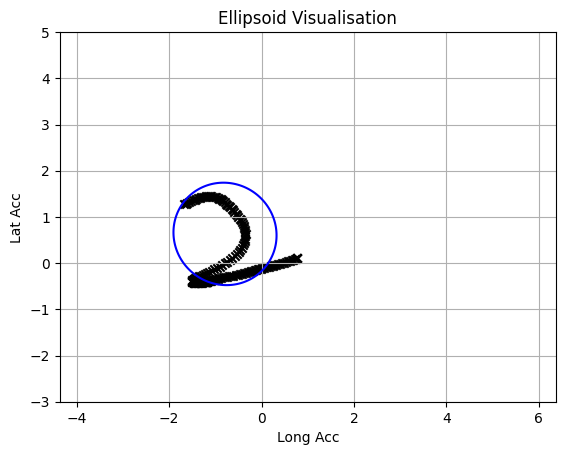

Optimal solution found!


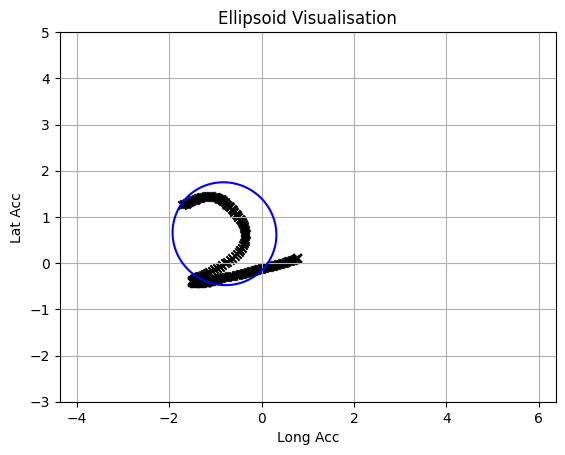

Optimal solution found!


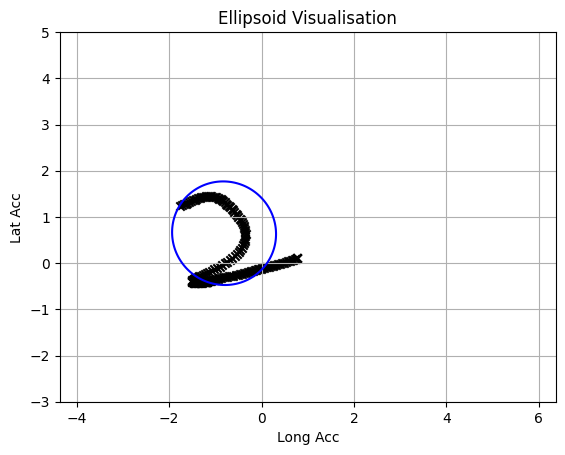

Optimal solution found!


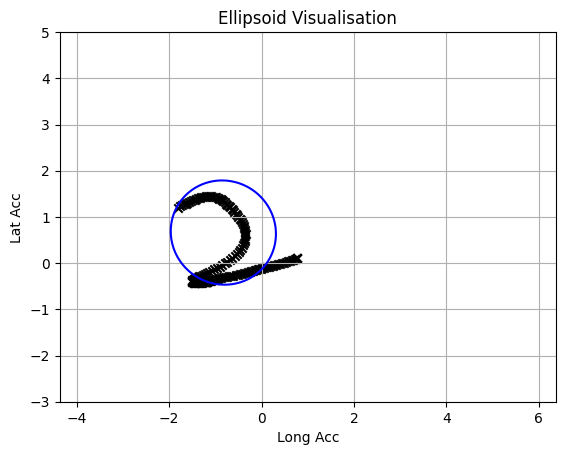

Optimal solution found!


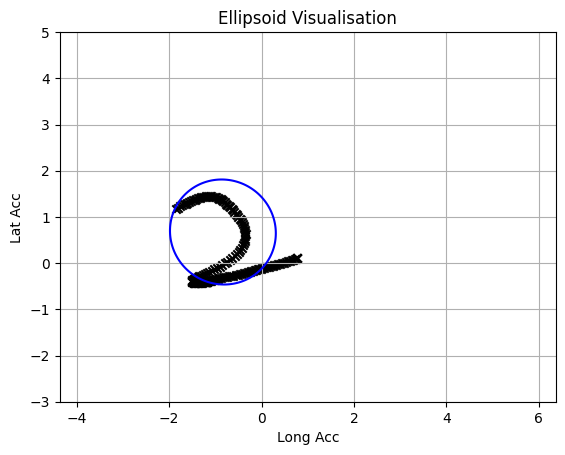

Optimal solution found!


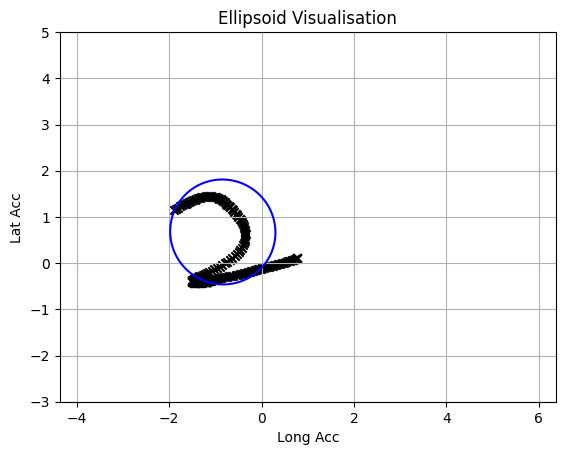

Optimal solution found!


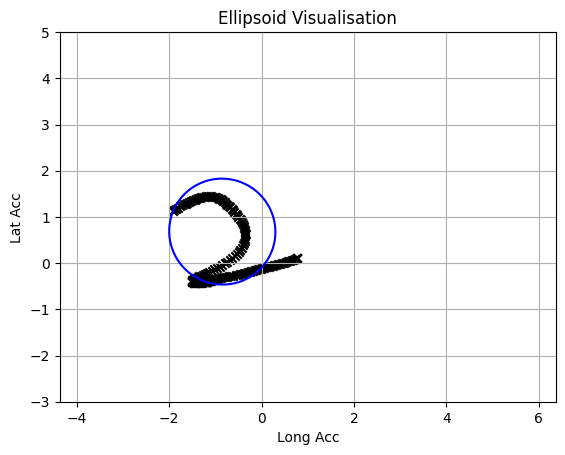

Optimal solution found!


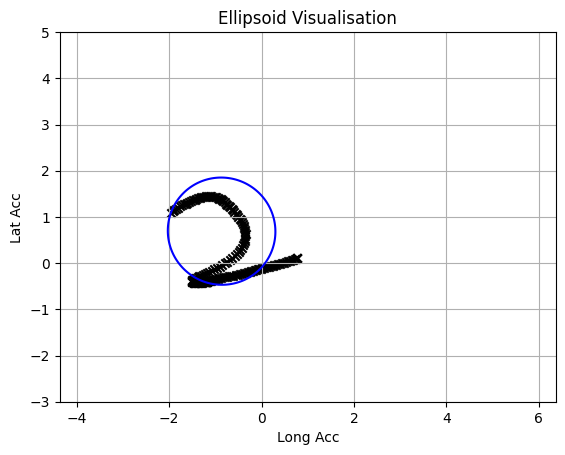

Optimal solution found!


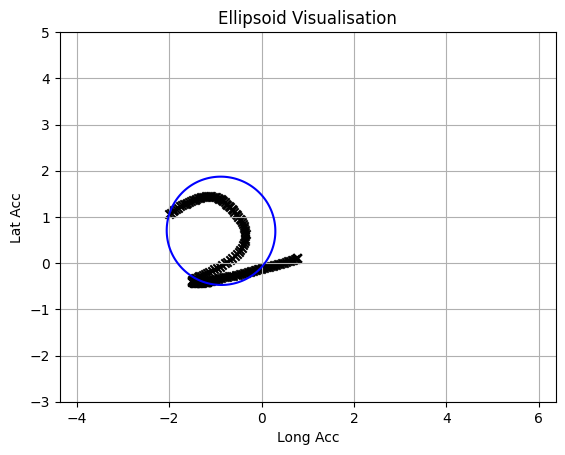

Optimal solution found!


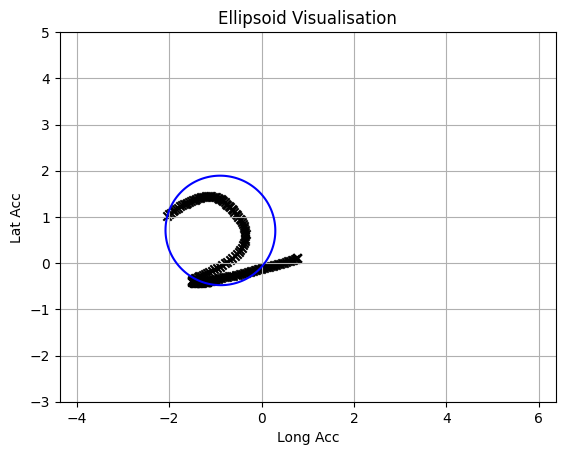

Optimal solution found!


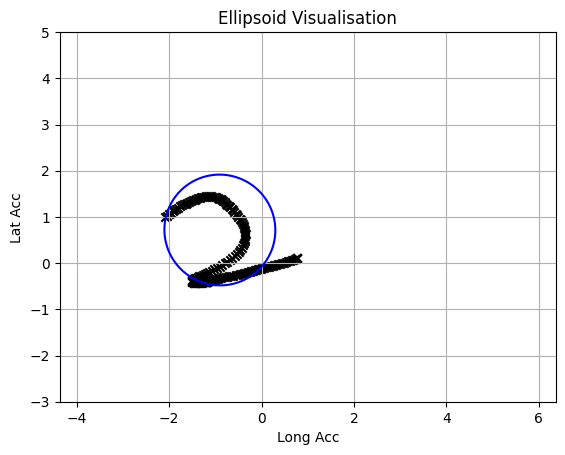

Optimal solution found!


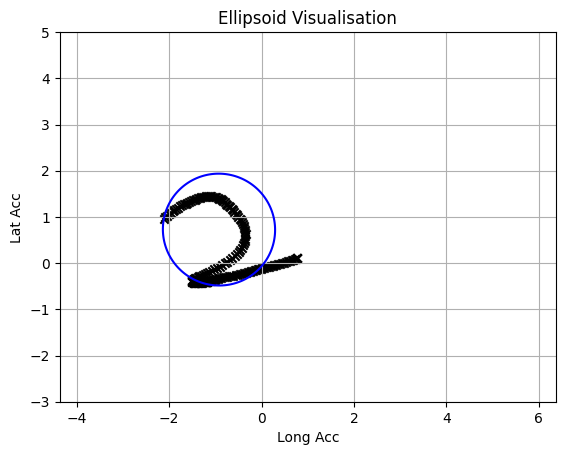

Optimal solution found!


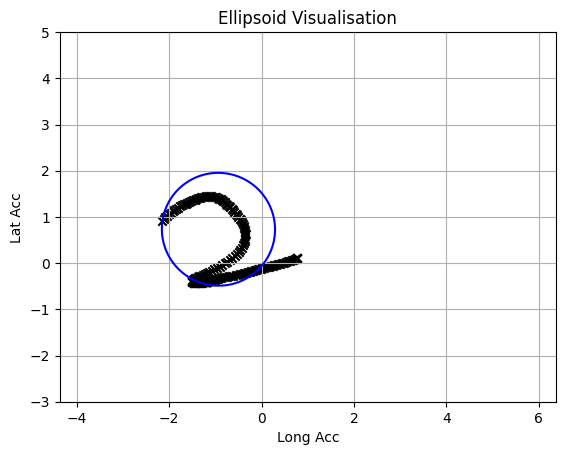

Optimal solution found!


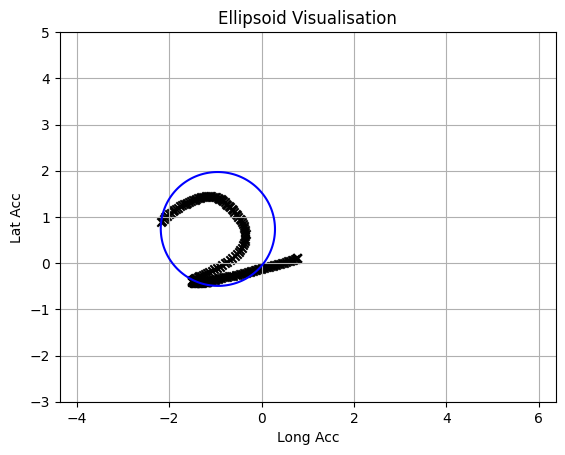

Optimal solution found!


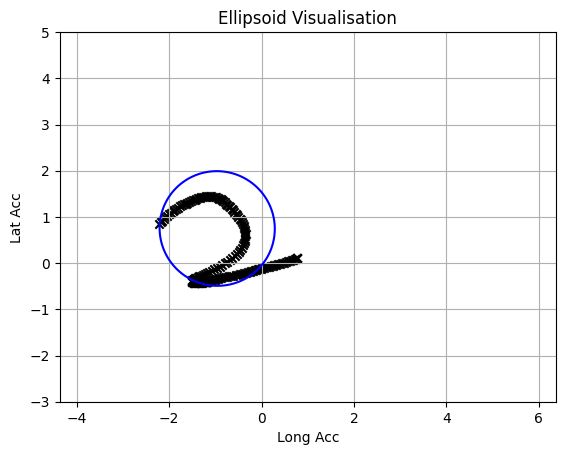

Optimal solution found!


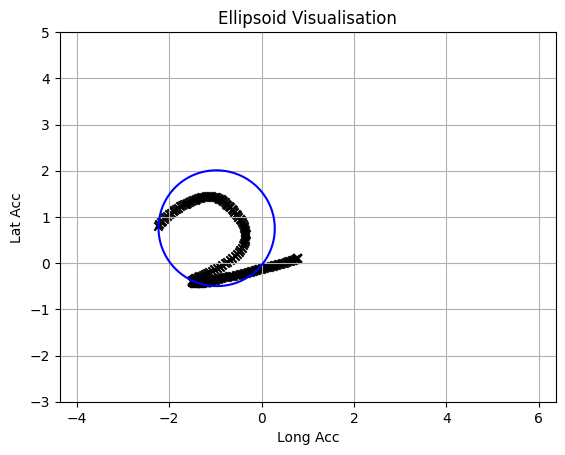

Optimal solution found!


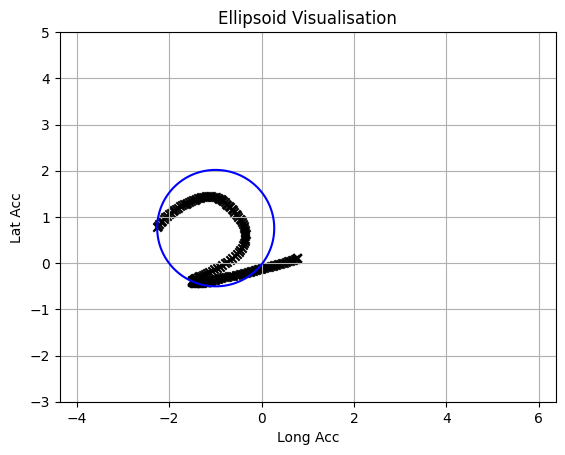

Optimal solution found!


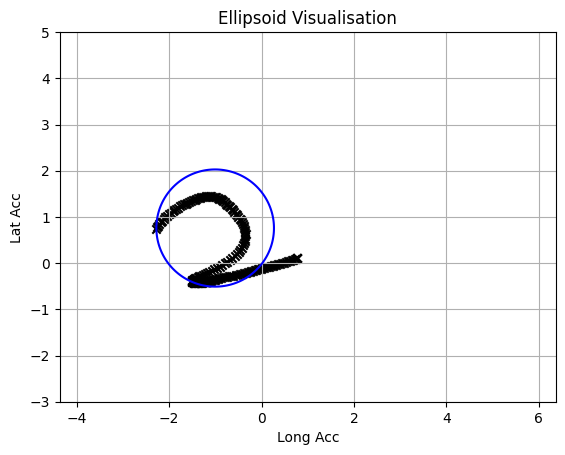

Optimal solution found!


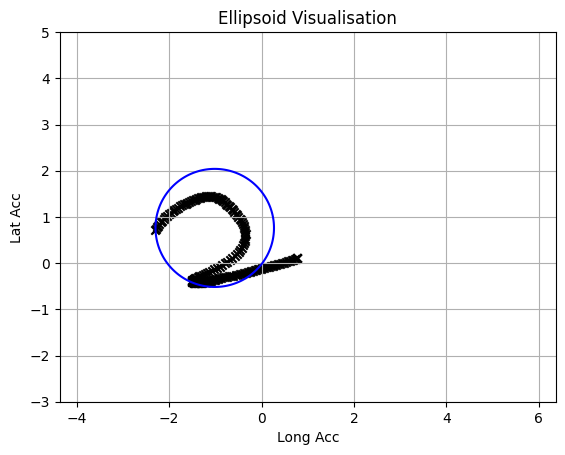

Optimal solution found!


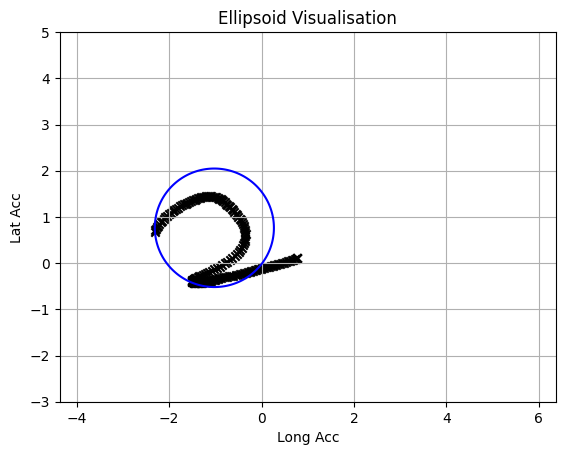

Optimal solution found!


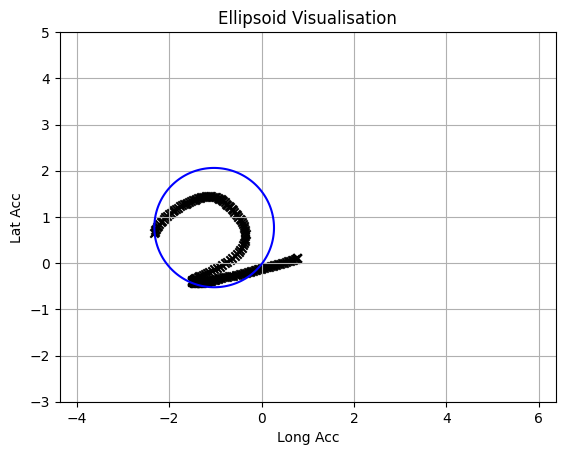

Optimal solution found!


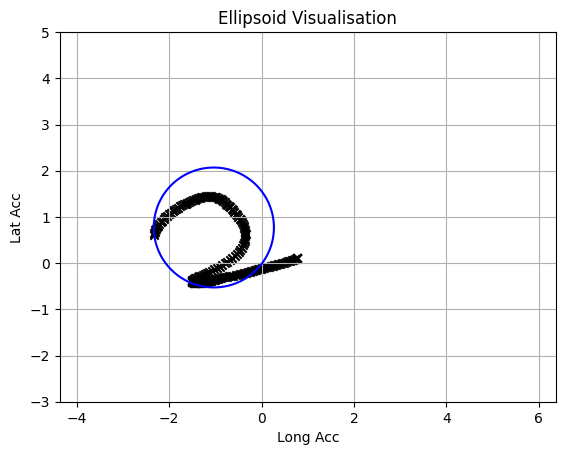

Optimal solution found!


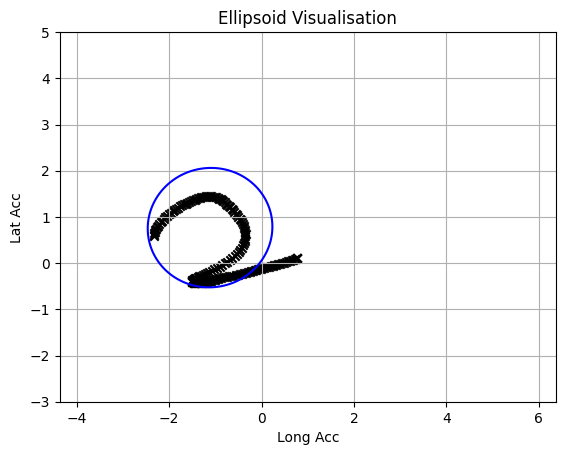

Optimal solution found!


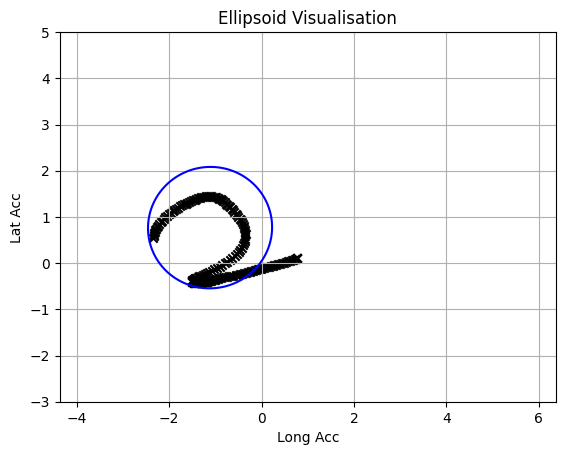

Optimal solution found!


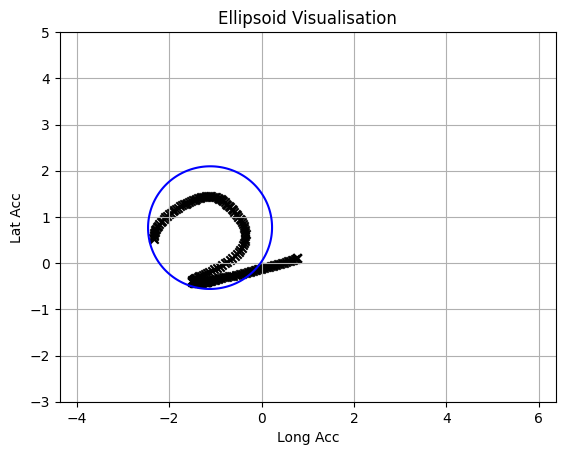

Optimal solution found!


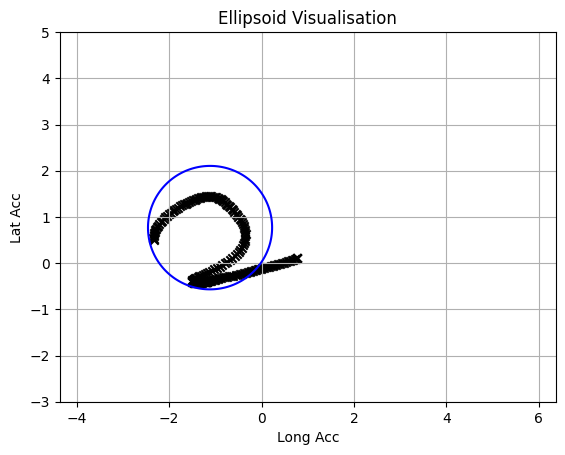

Optimal solution found!


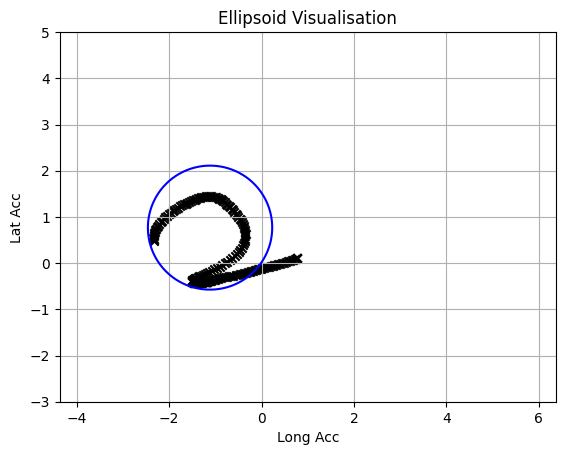

Optimal solution found!


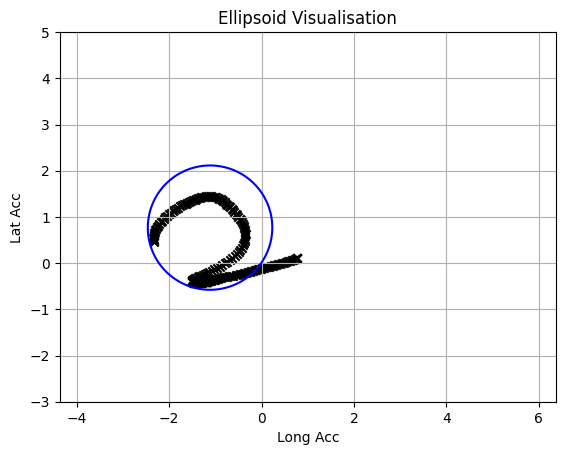

Optimal solution found!


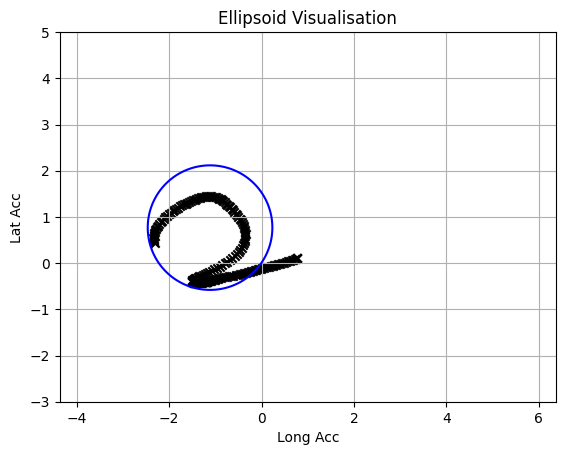

Optimal solution found!


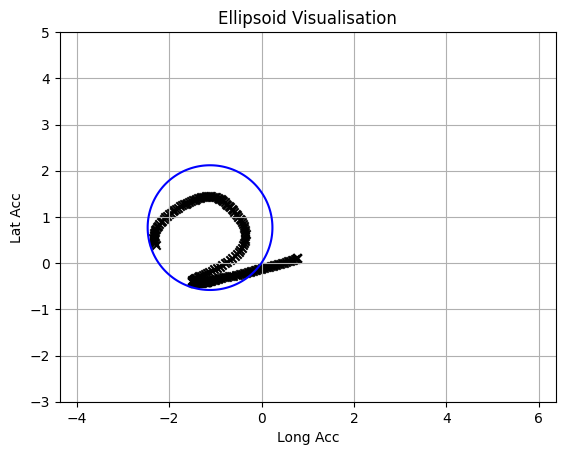

Optimal solution found!


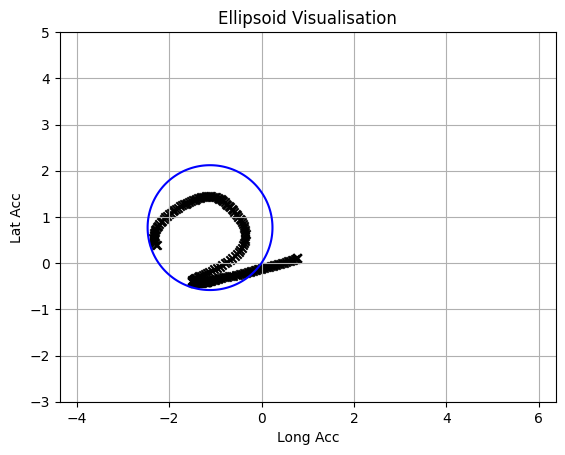

Optimal solution found!


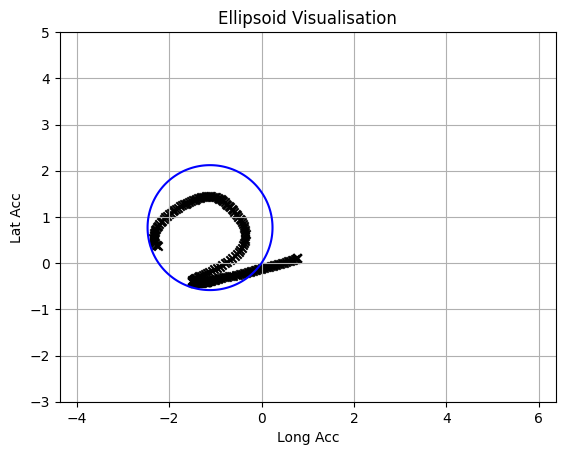

Optimal solution found!


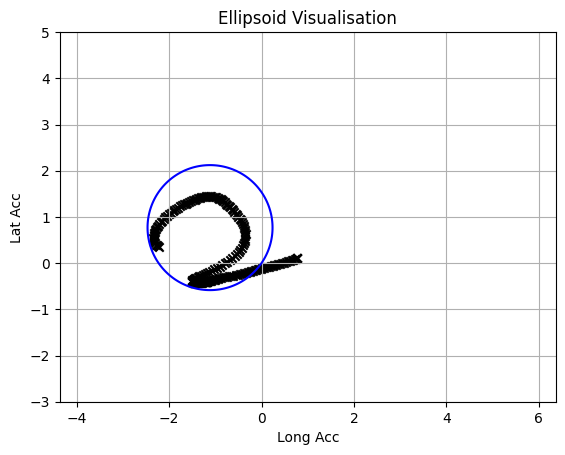

Optimal solution found!


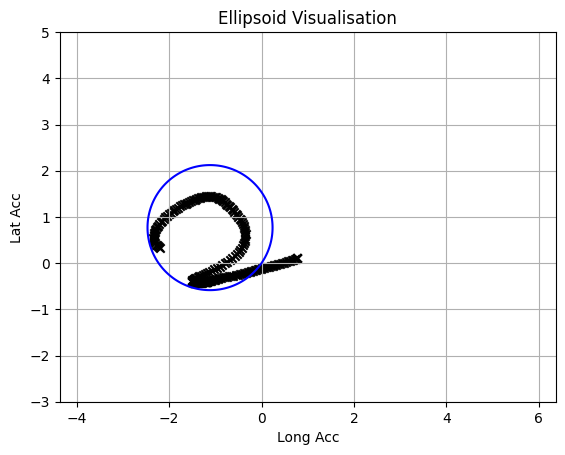

Optimal solution found!


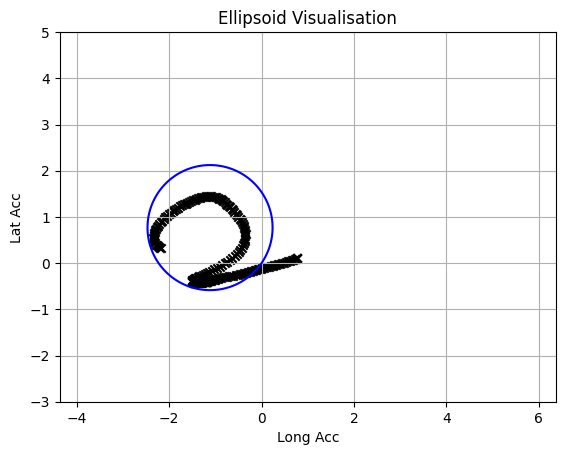

Optimal solution found!


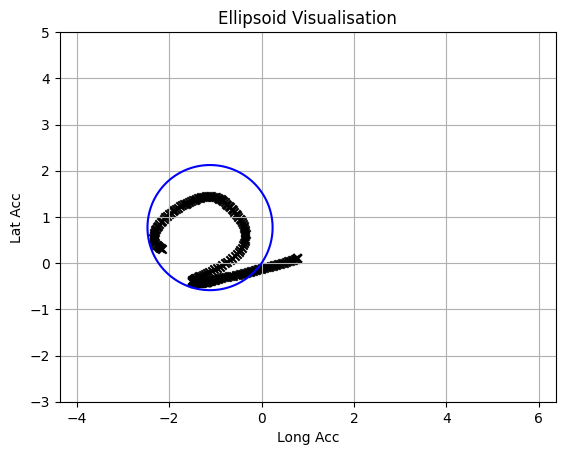

Optimal solution found!


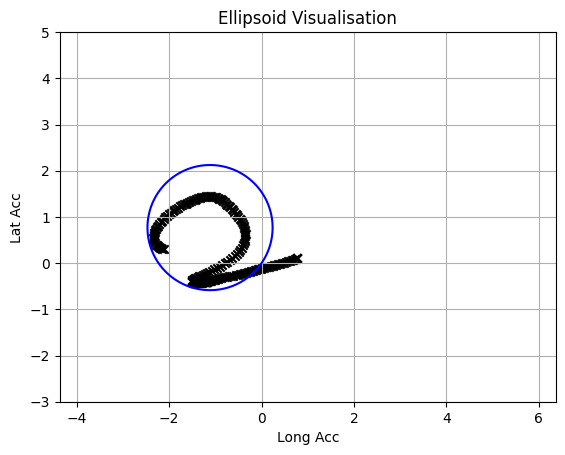

Optimal solution found!


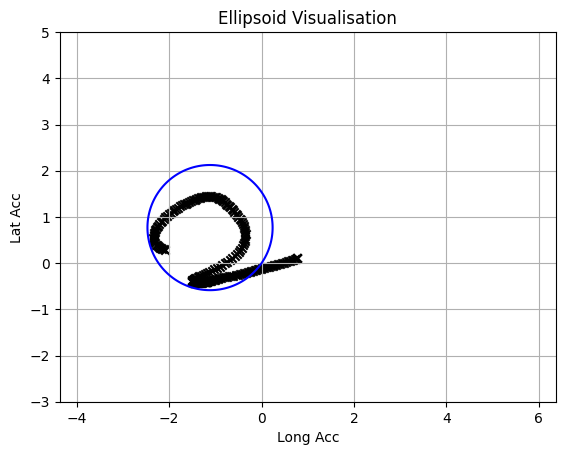

Optimal solution found!


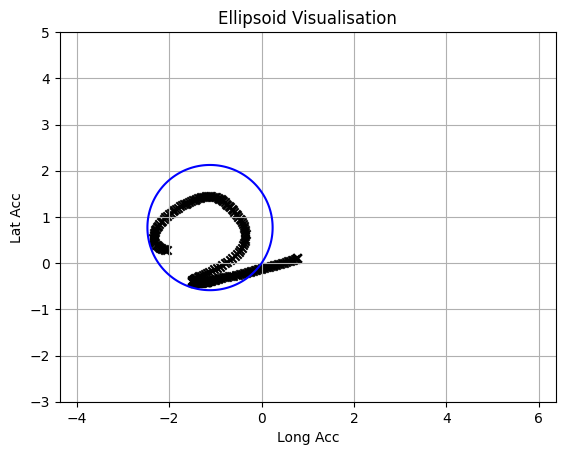

Optimal solution found!


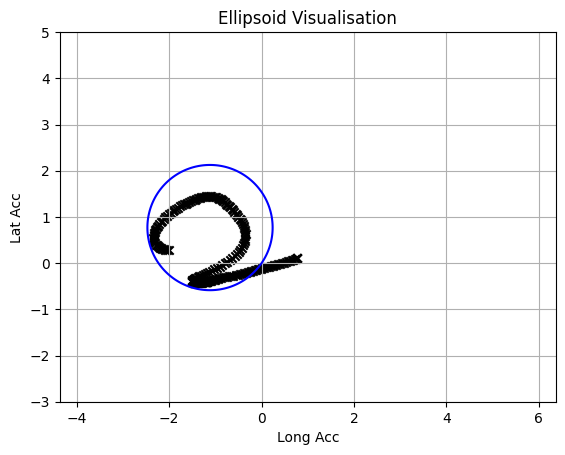

Optimal solution found!


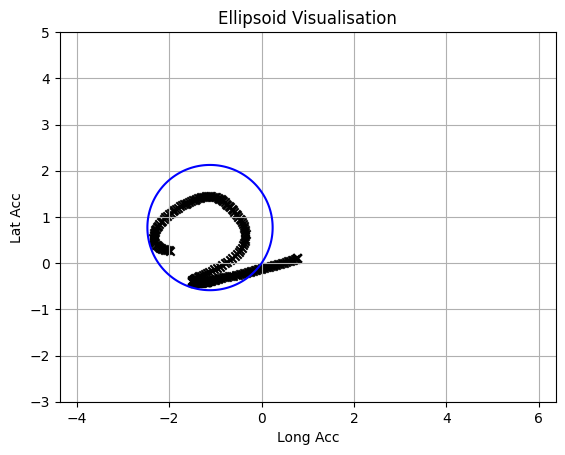

Optimal solution found!


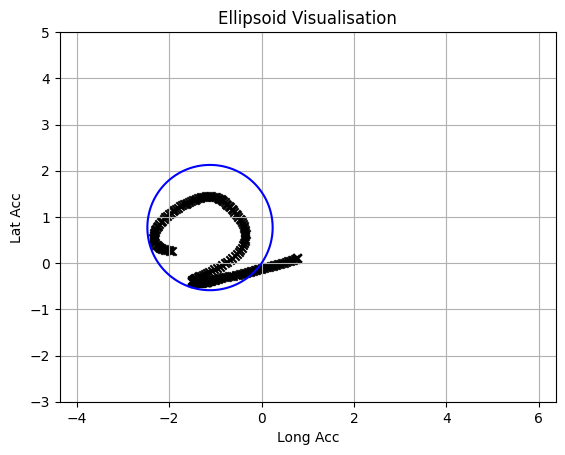

Optimal solution found!


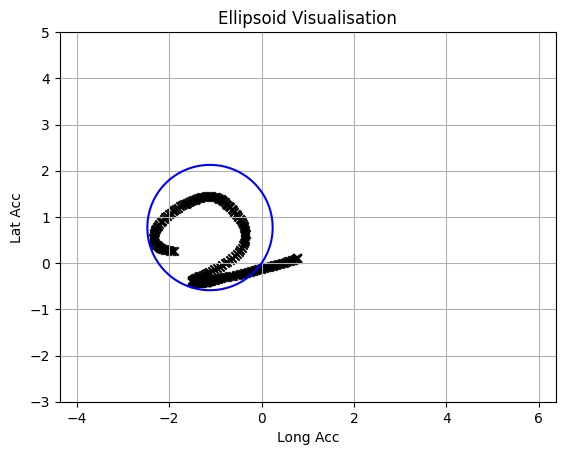

Optimal solution found!


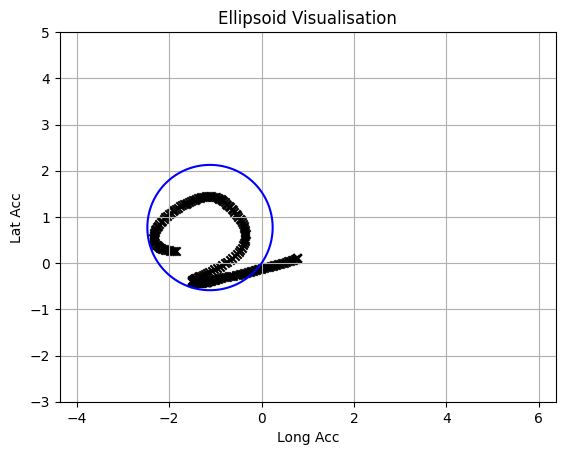

Optimal solution found!


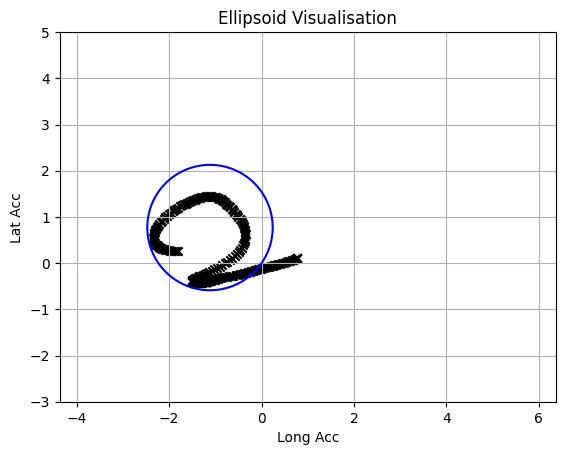

Optimal solution found!


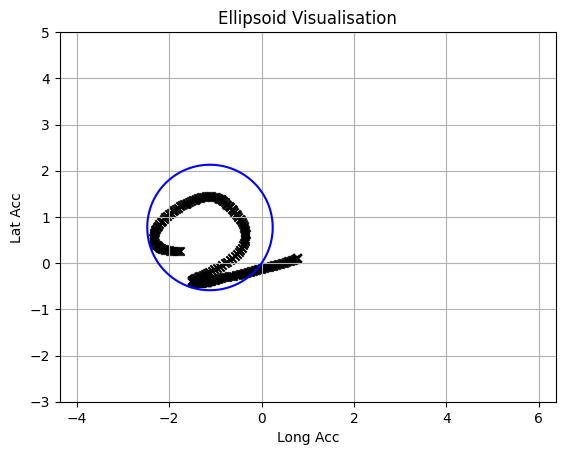

Optimal solution found!


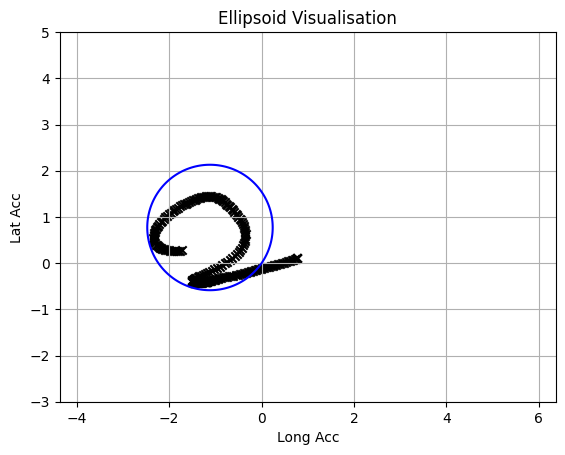

Optimal solution found!


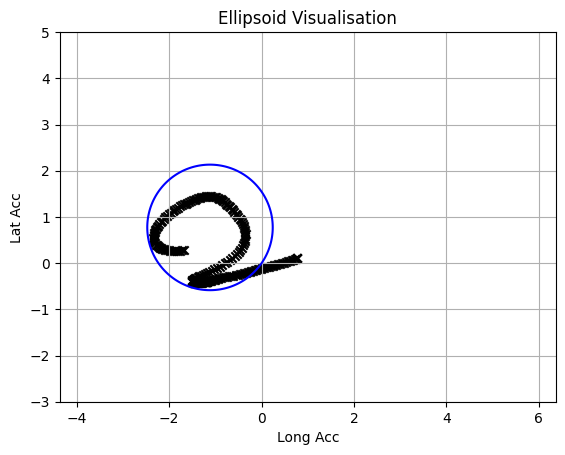

Optimal solution found!


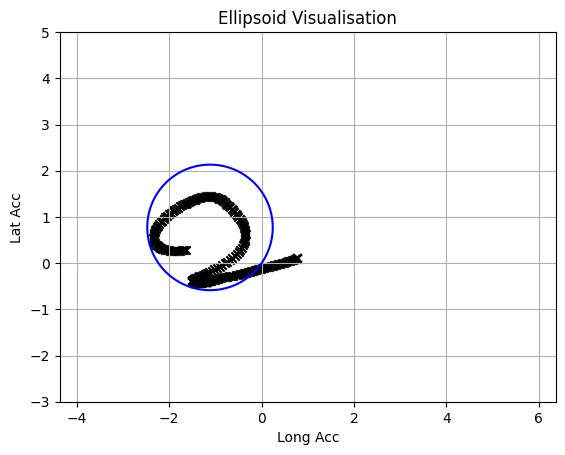

Optimal solution found!


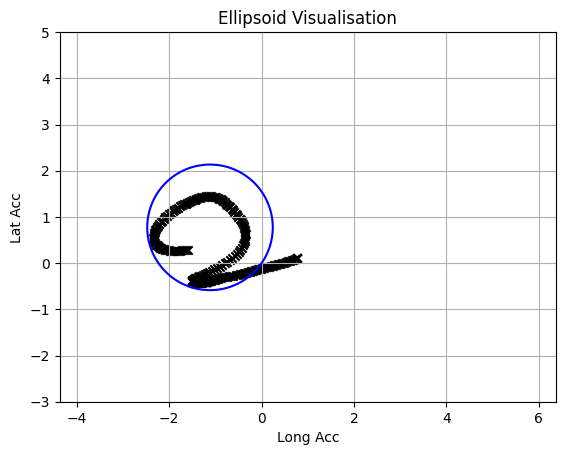

Optimal solution found!


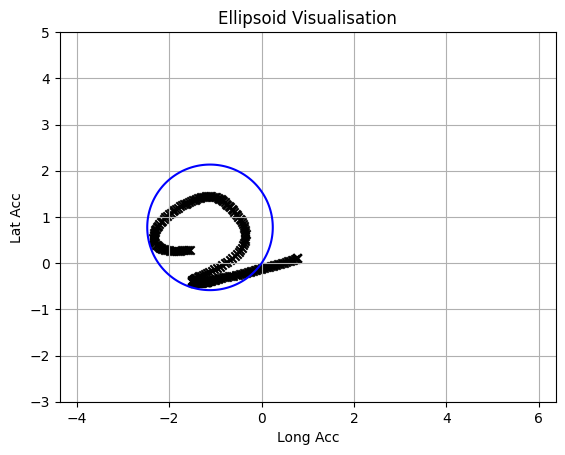

Optimal solution found!


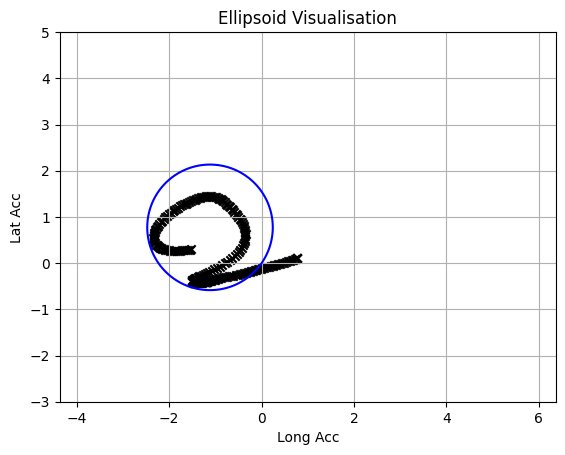

Optimal solution found!


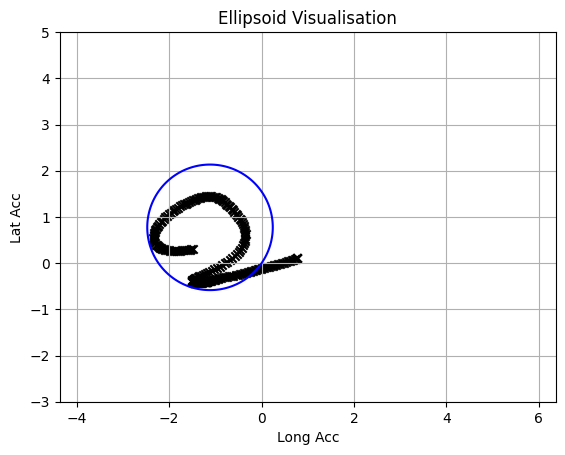

Optimal solution found!


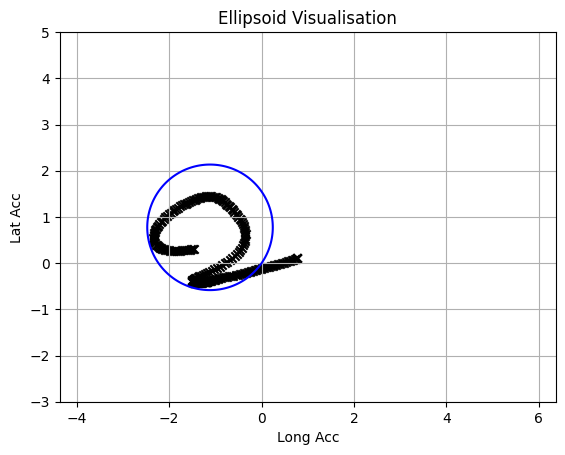

Optimal solution found!


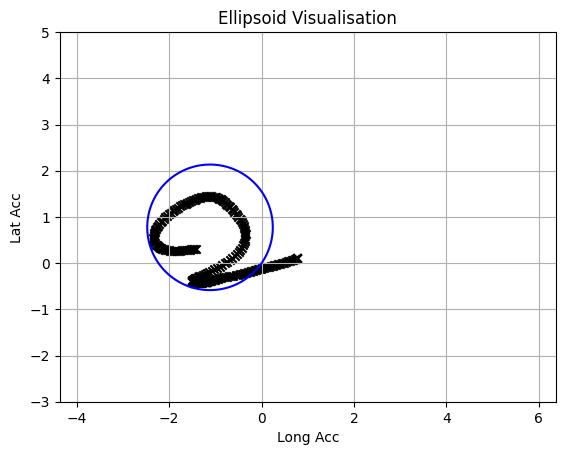

Optimal solution found!


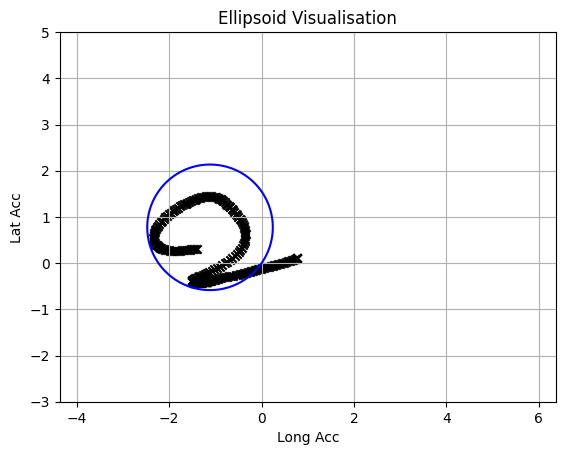

Optimal solution found!


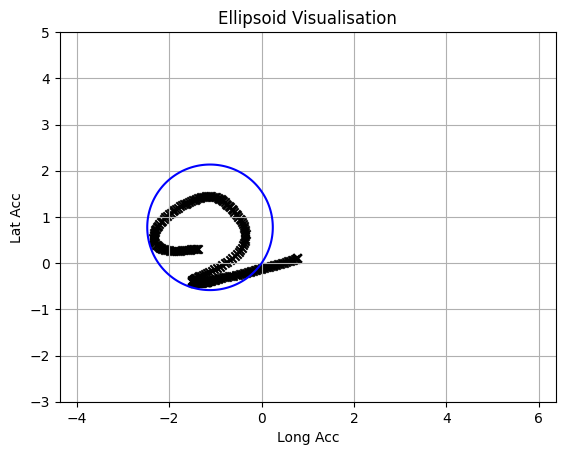

Optimal solution found!


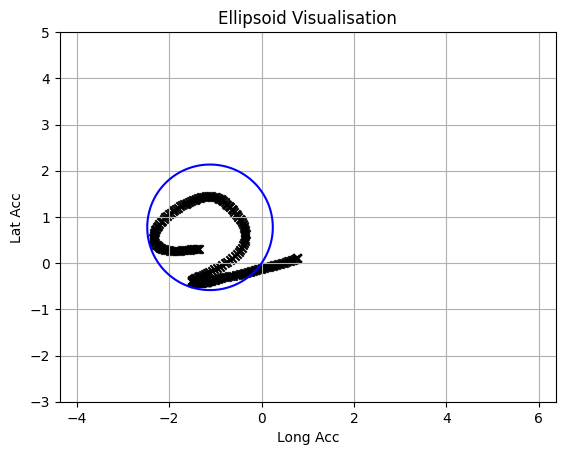

Optimal solution found!


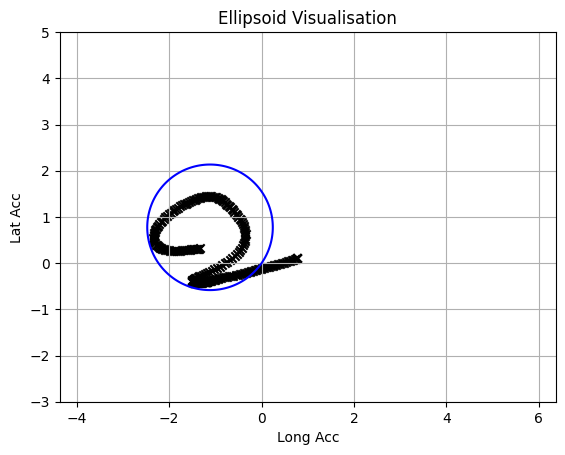

Optimal solution found!


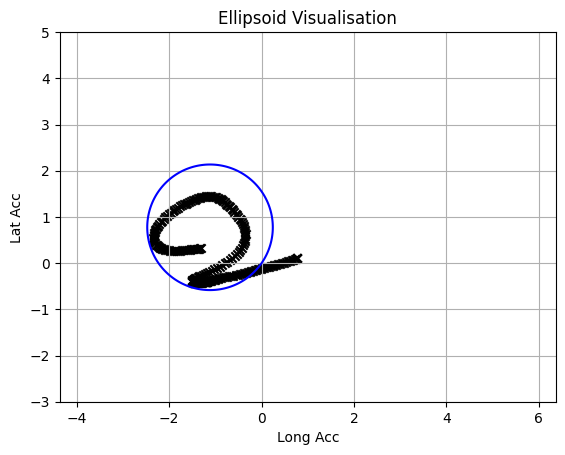

Optimal solution found!


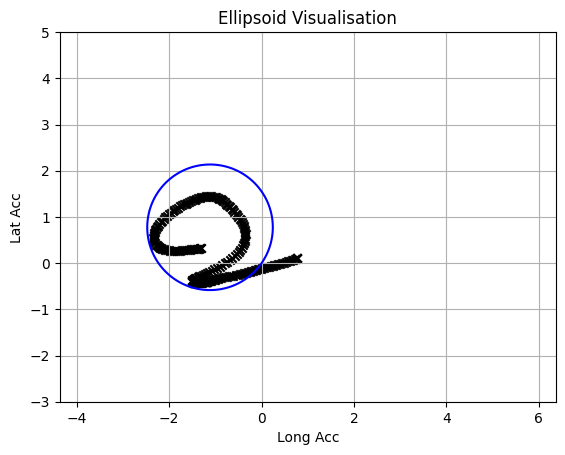

Optimal solution found!


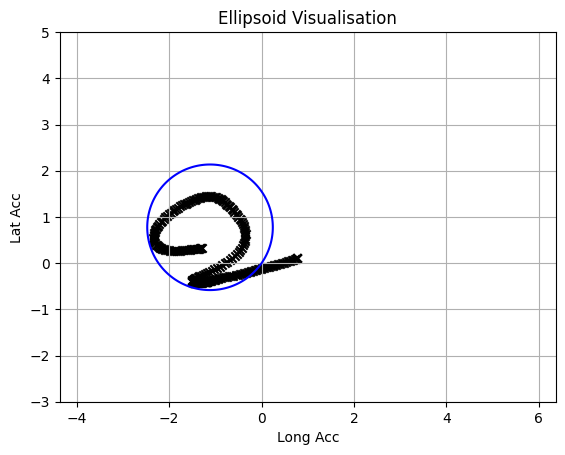

Optimal solution found!


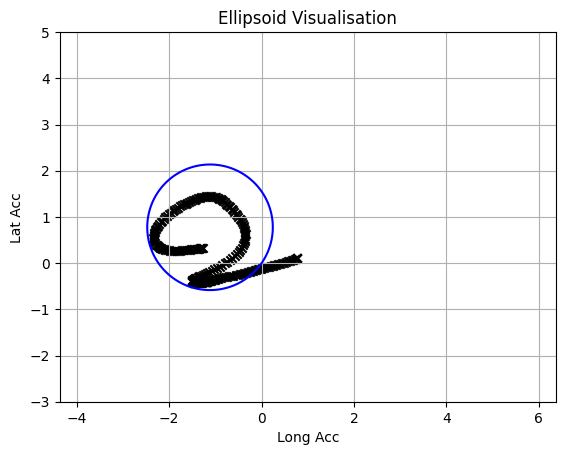

Optimal solution found!


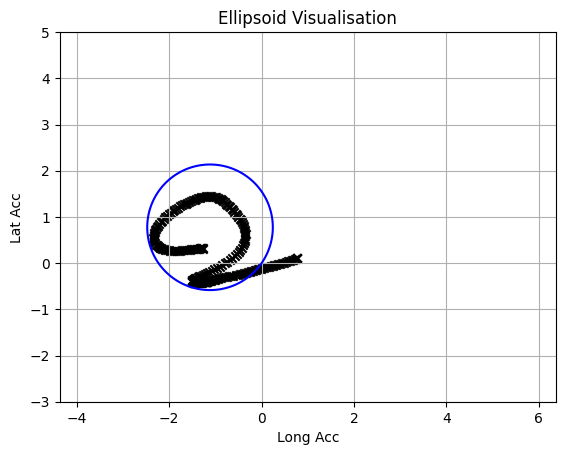

Optimal solution found!


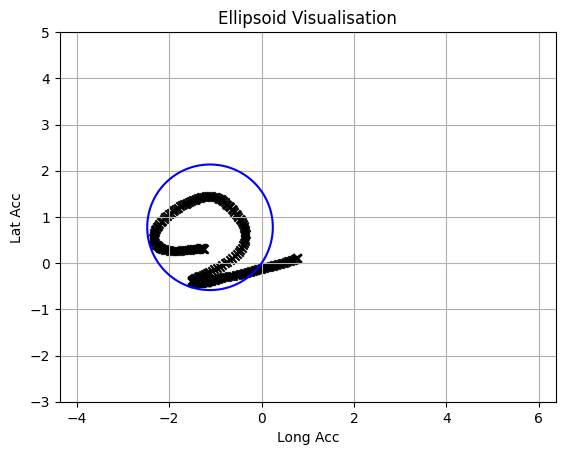

Optimal solution found!


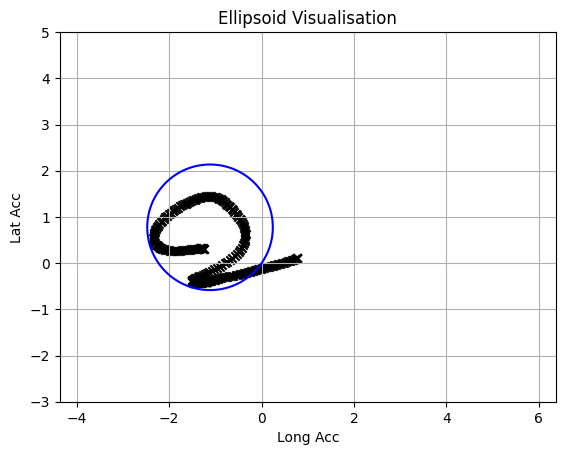

Optimal solution found!


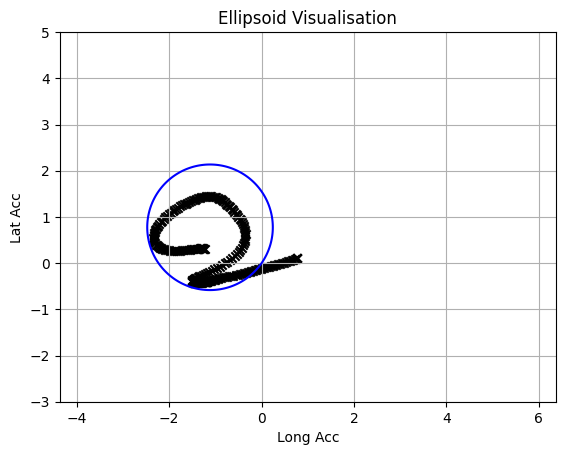

Optimal solution found!


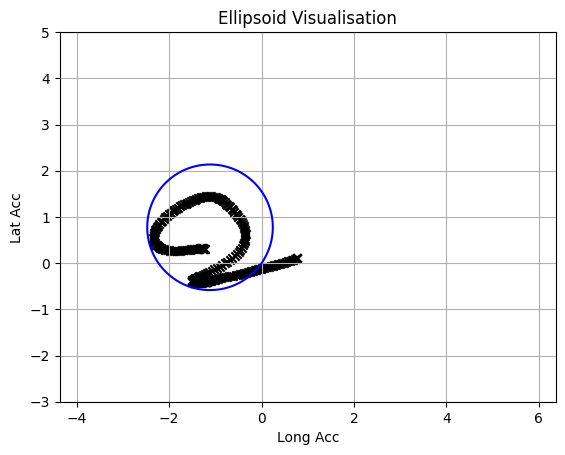

Optimal solution found!


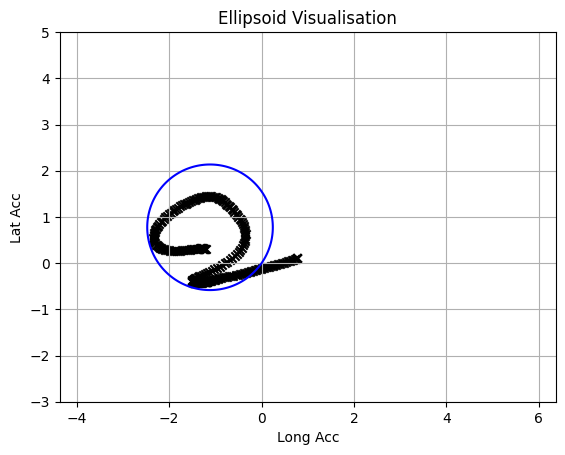

Optimal solution found!


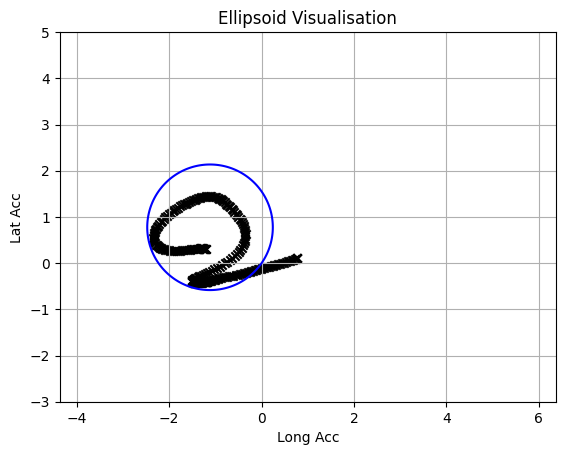

Optimal solution found!


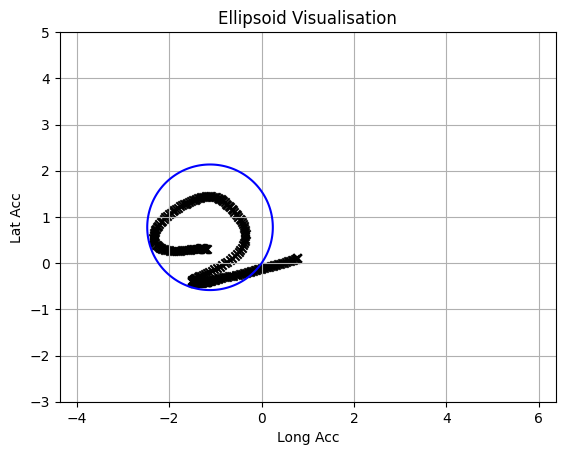

Optimal solution found!


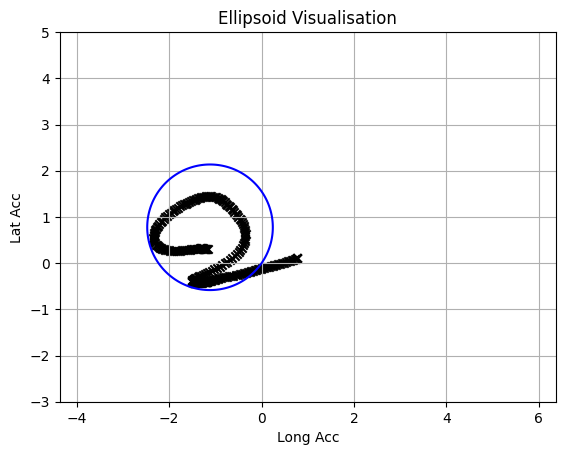

Optimal solution found!


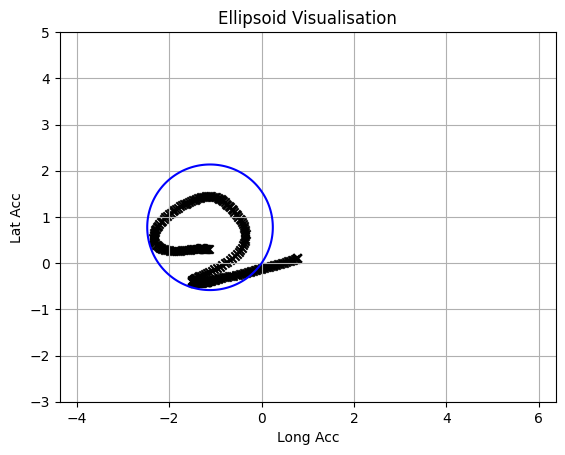

Optimal solution found!


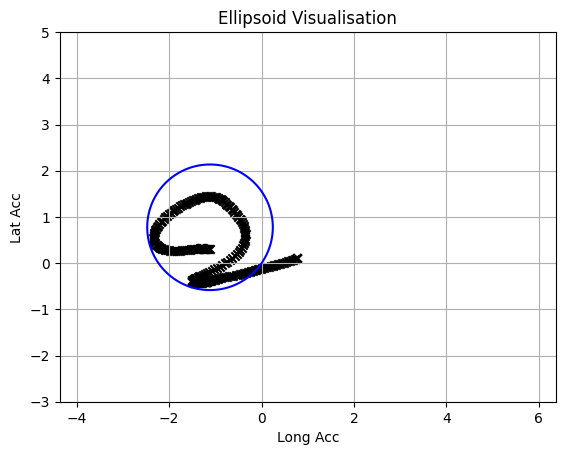

Optimal solution found!


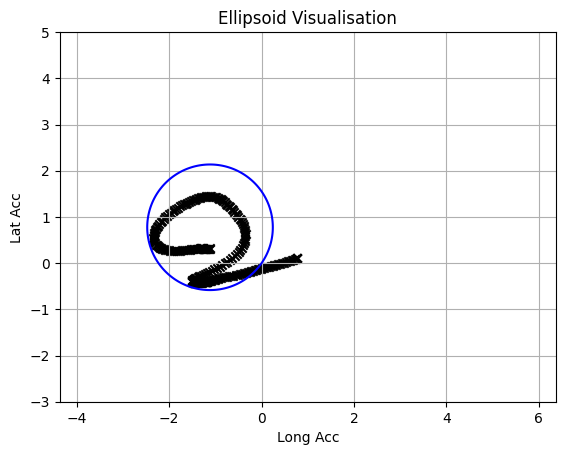

Optimal solution found!


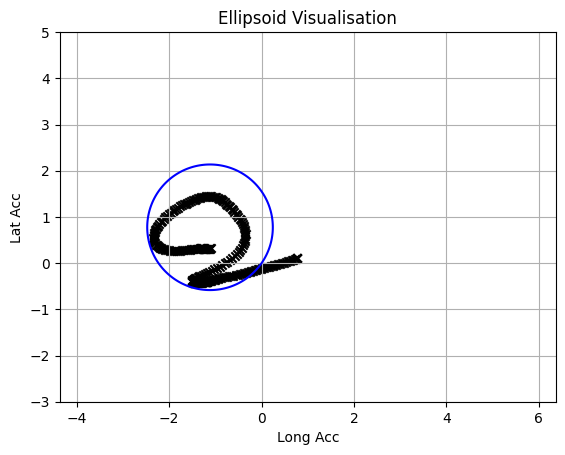

Optimal solution found!


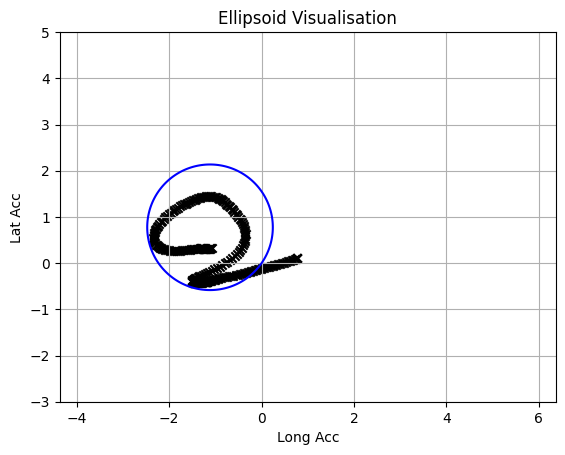

Optimal solution found!


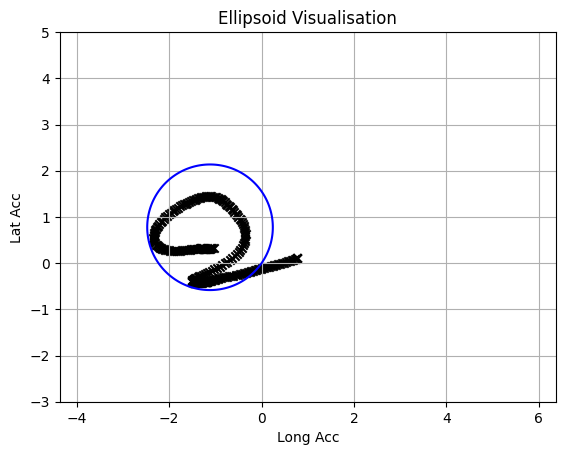

Optimal solution found!


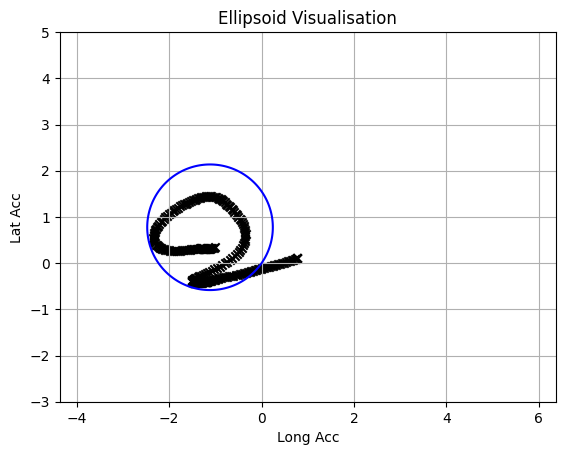

Optimal solution found!


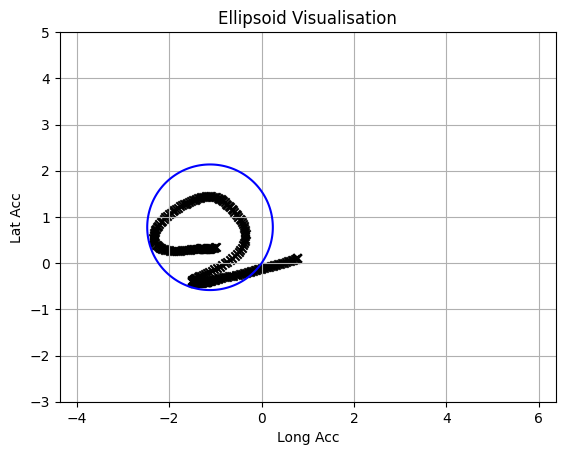

Optimal solution found!


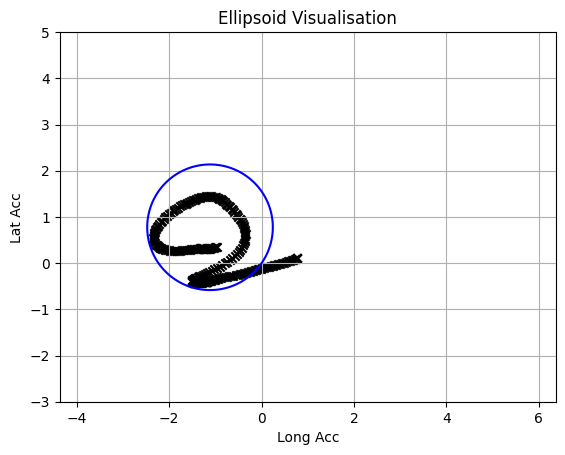

Optimal solution found!


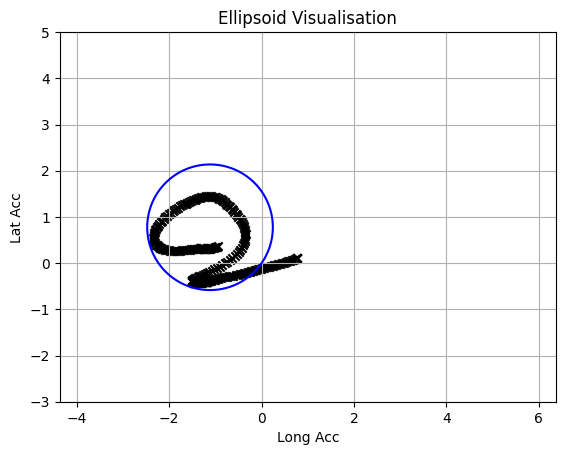

Optimal solution found!


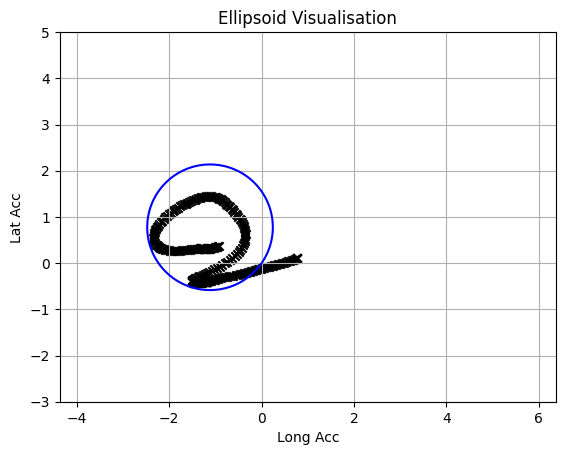

Optimal solution found!


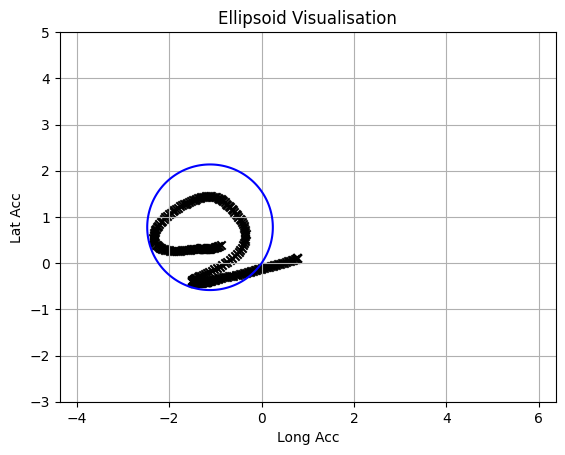

Optimal solution found!


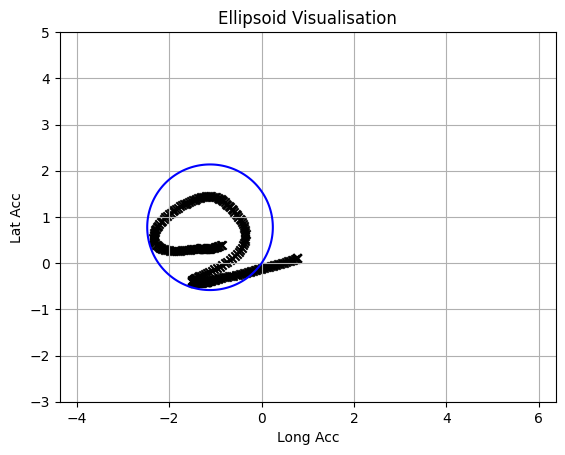

Optimal solution found!


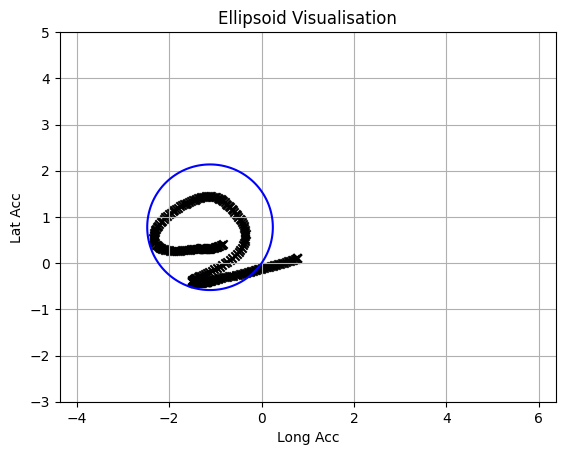

Optimal solution found!


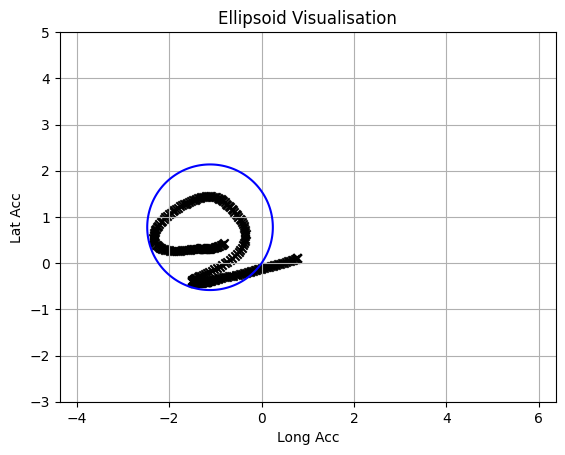

Optimal solution found!


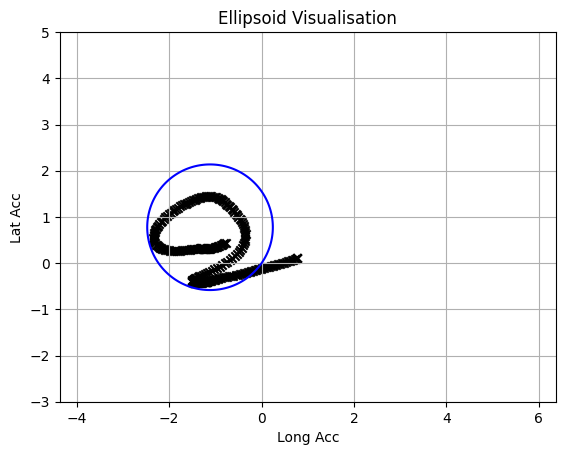

Optimal solution found!


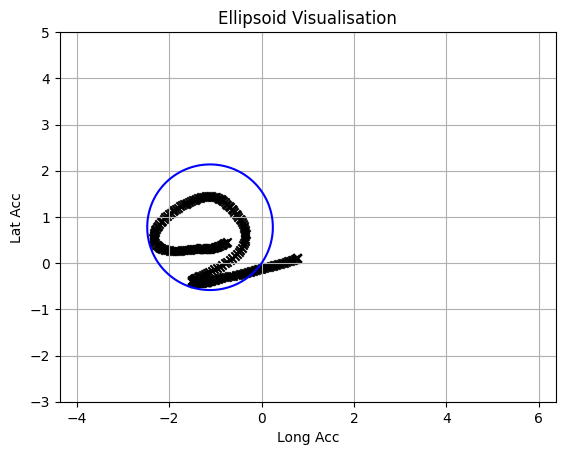

Optimal solution found!


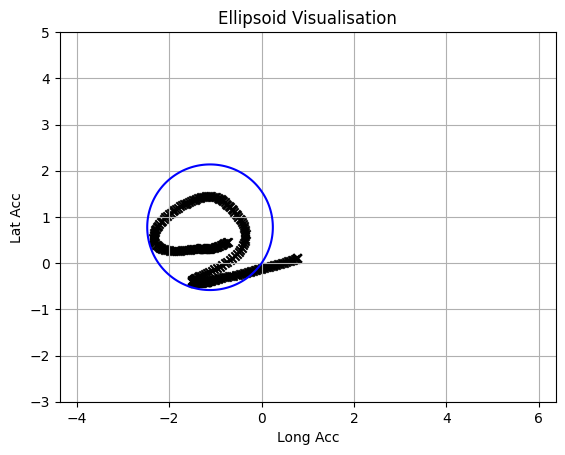

Optimal solution found!


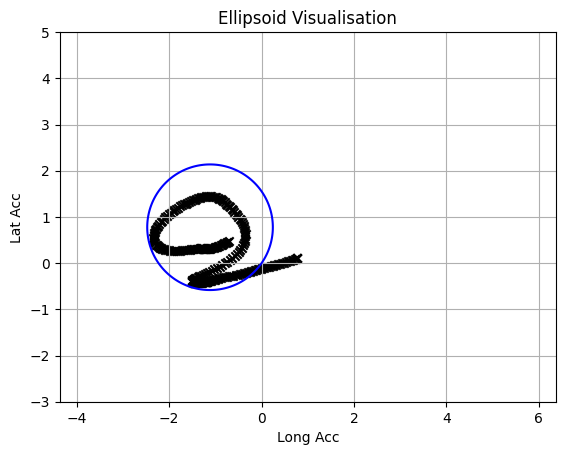

Optimal solution found!


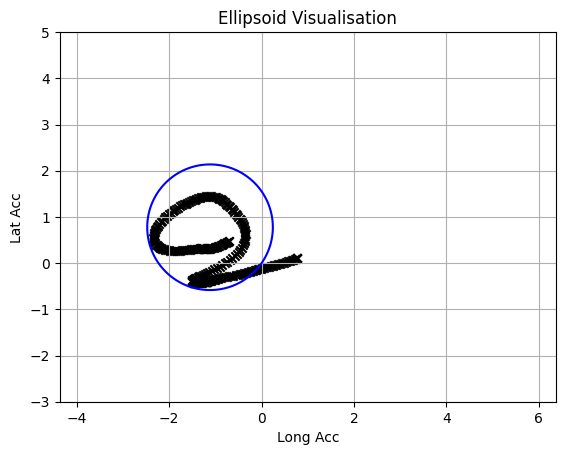

Optimal solution found!


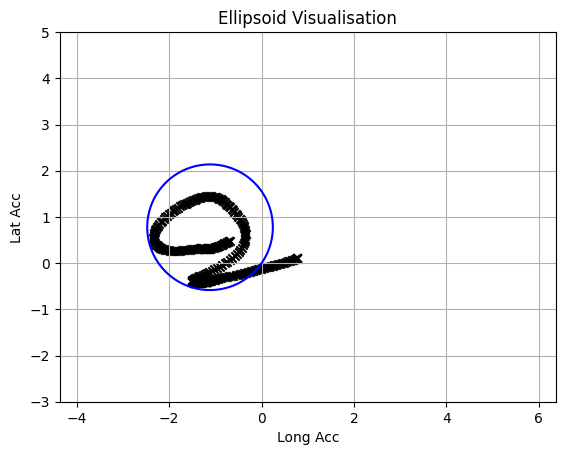

Optimal solution found!


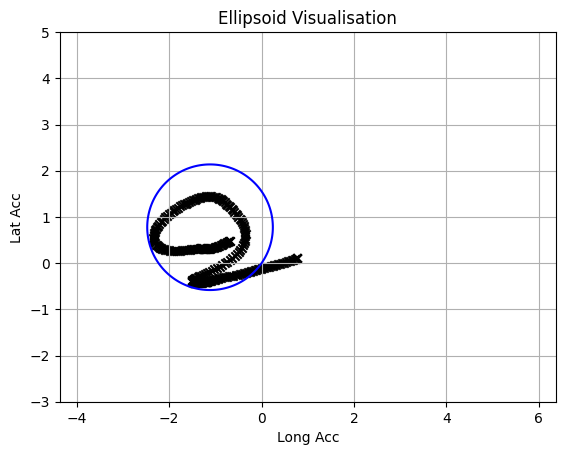

Optimal solution found!


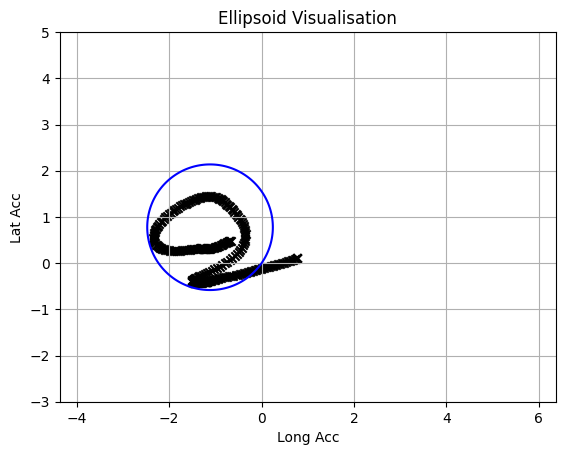

Optimal solution found!


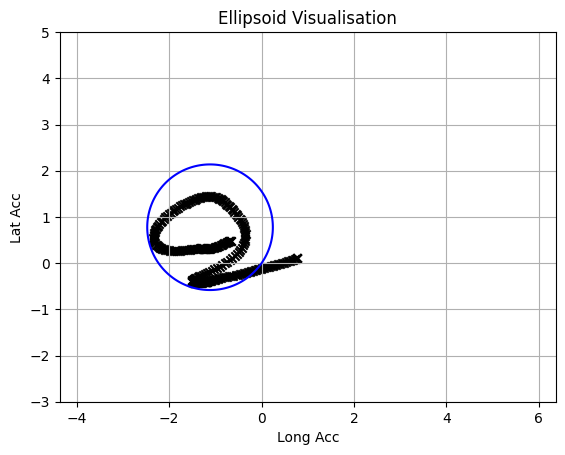

Optimal solution found!


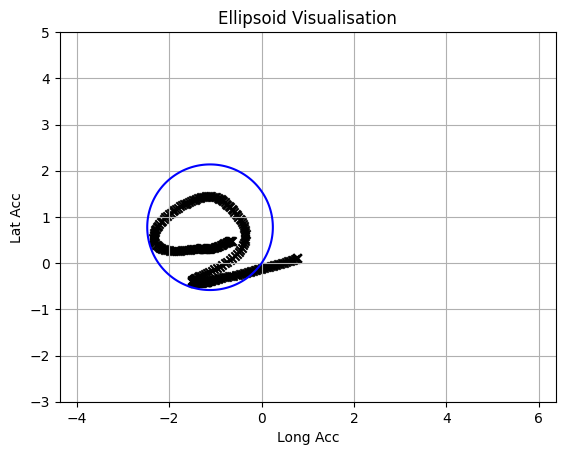

Optimal solution found!


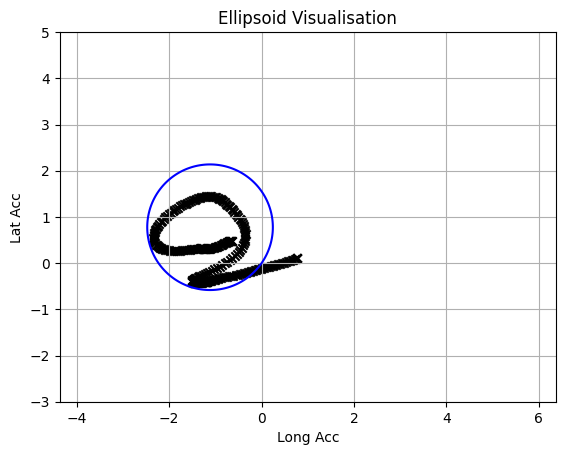

Optimal solution found!


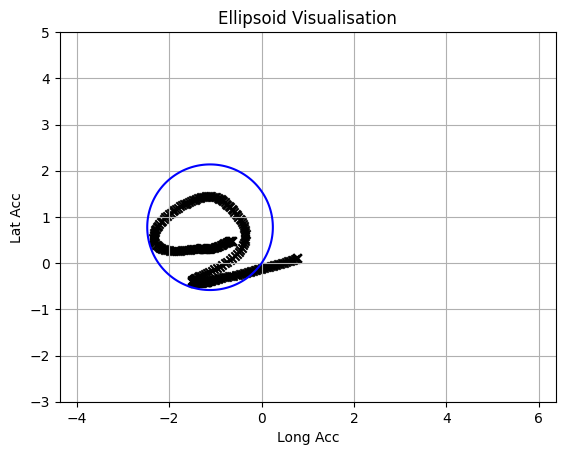

Optimal solution found!


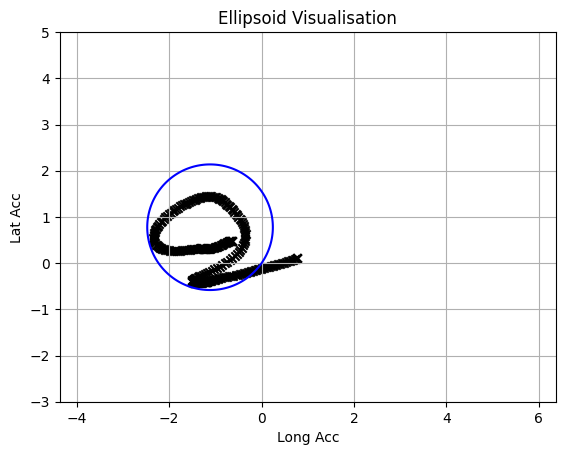

Optimal solution found!


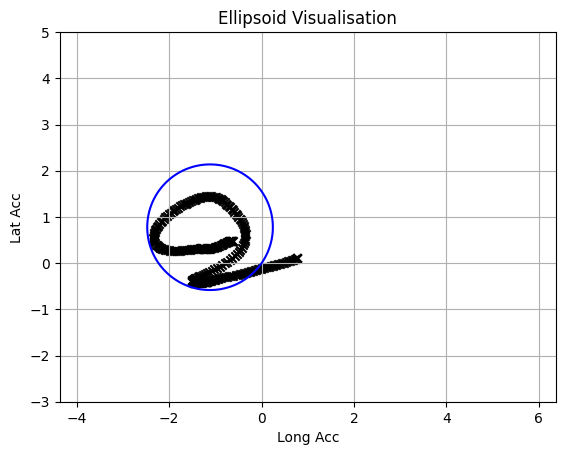

Optimal solution found!


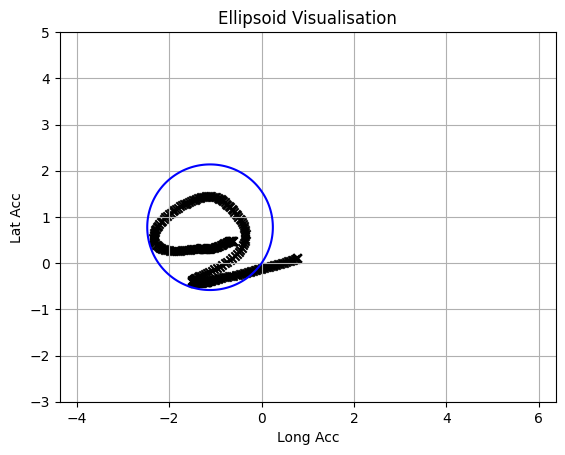

Optimal solution found!


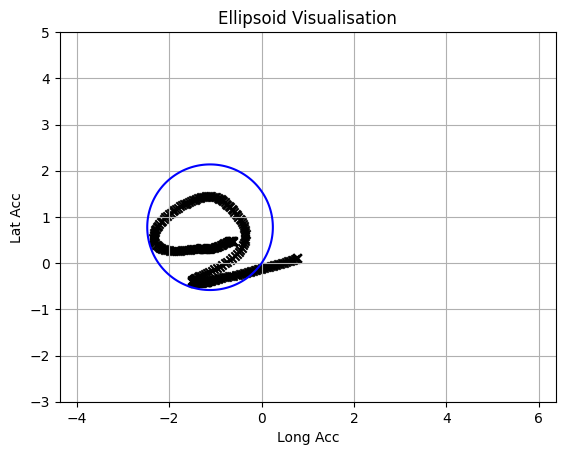

Optimal solution found!


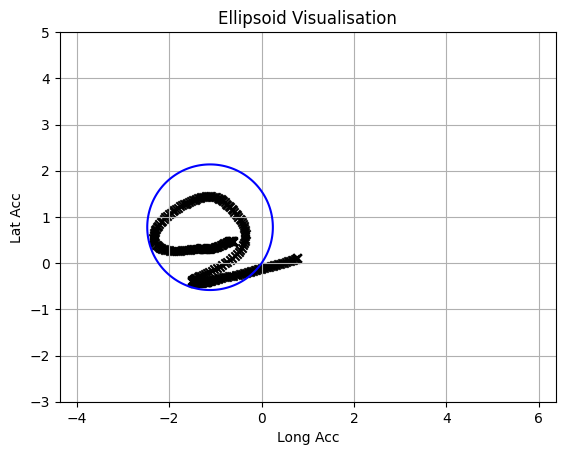

Optimal solution found!


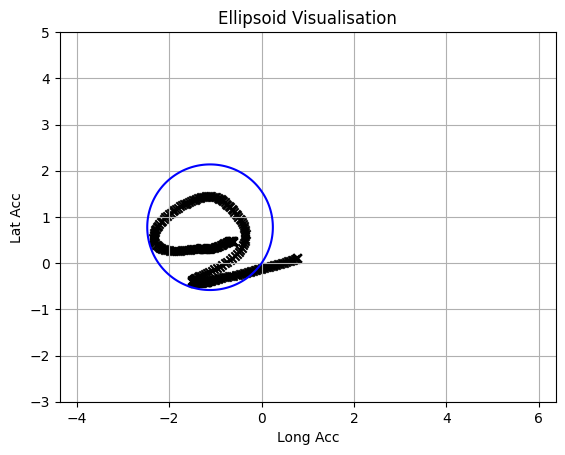

Optimal solution found!


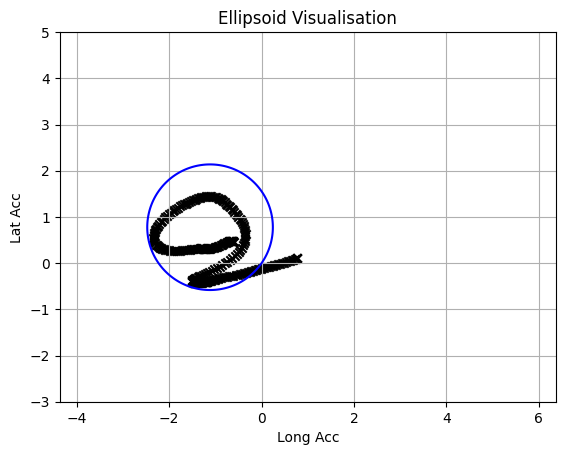

Optimal solution found!


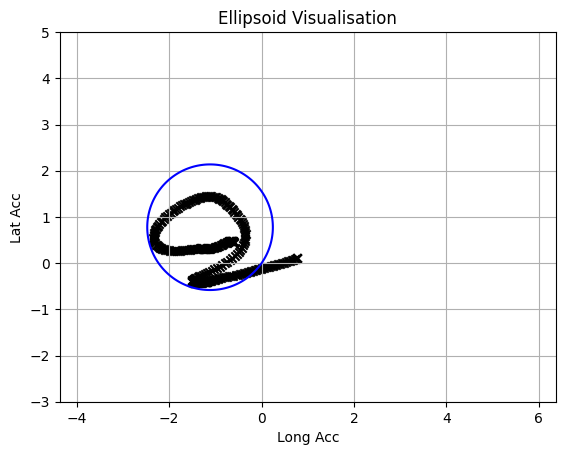

Optimal solution found!


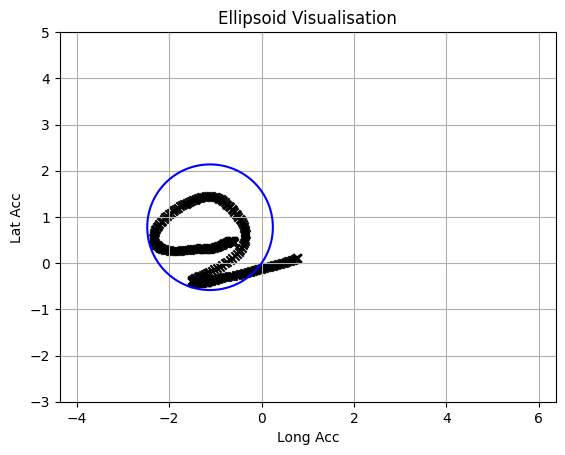

Optimal solution found!


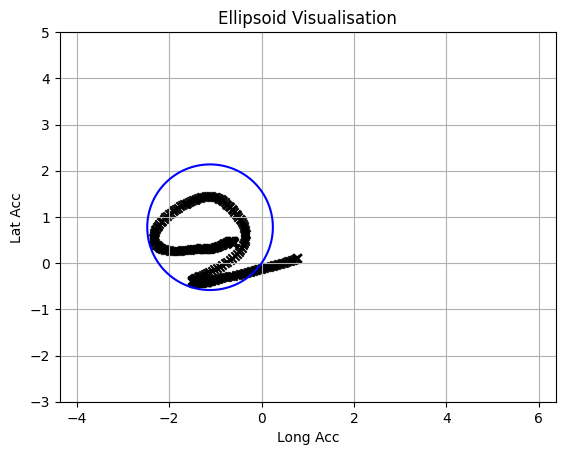

Optimal solution found!


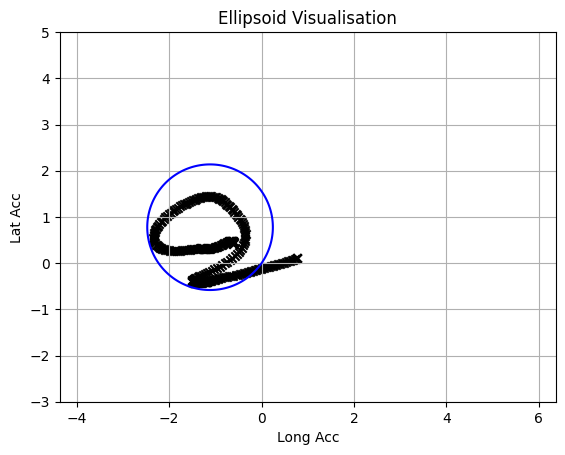

Optimal solution found!


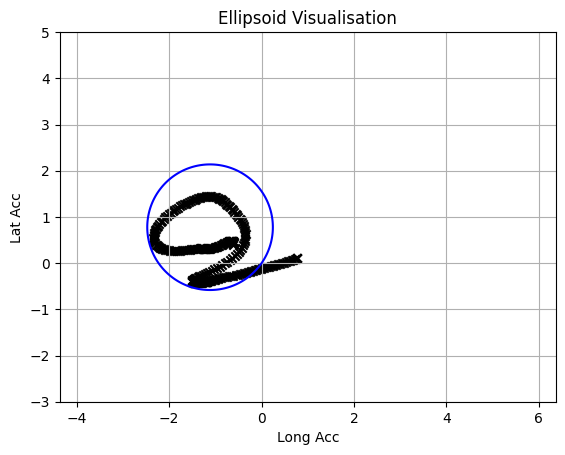

Optimal solution found!


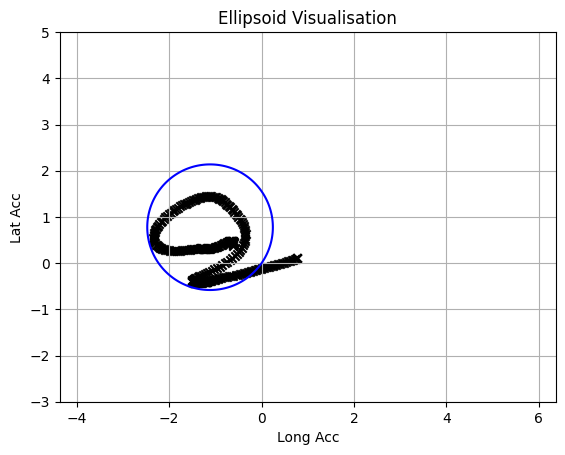

Optimal solution found!


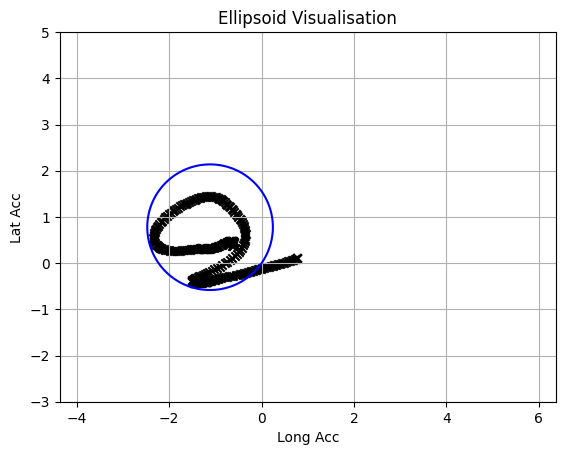

Optimal solution found!


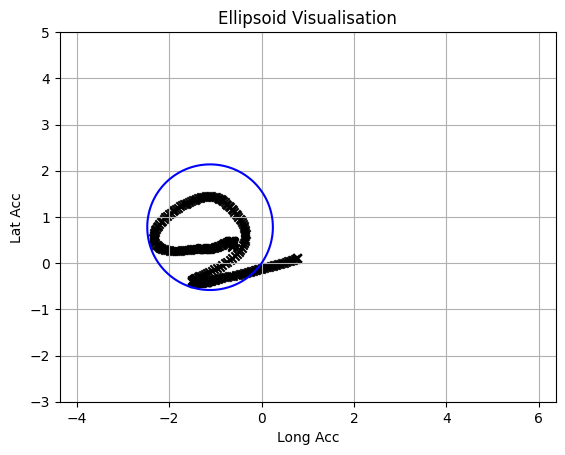

Optimal solution found!


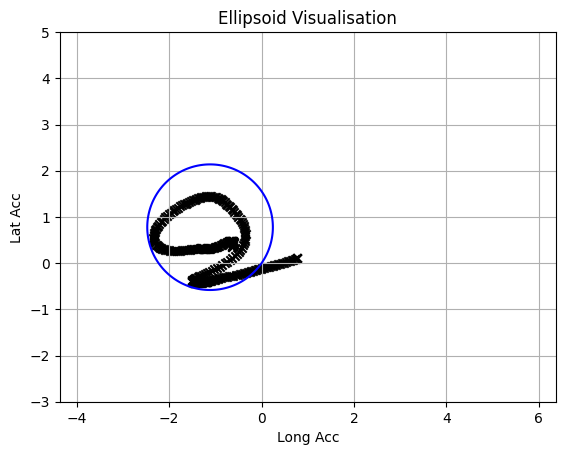

Optimal solution found!


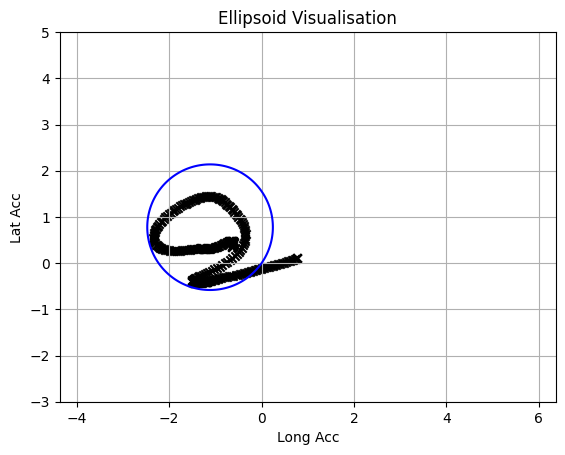

Optimal solution found!


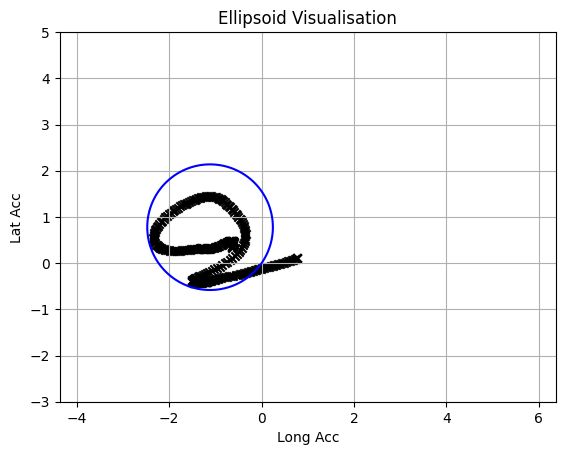

Optimal solution found!


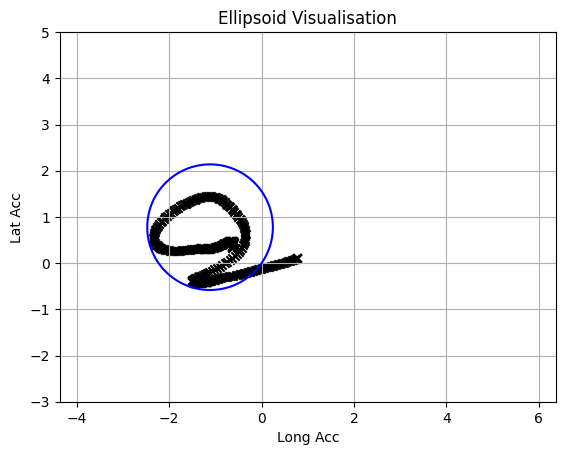

Optimal solution found!


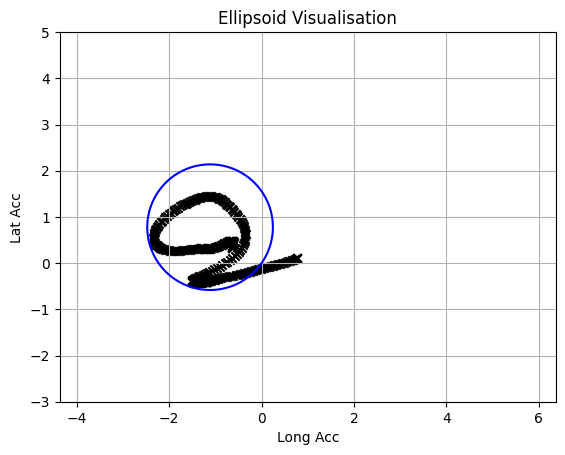

Optimal solution found!


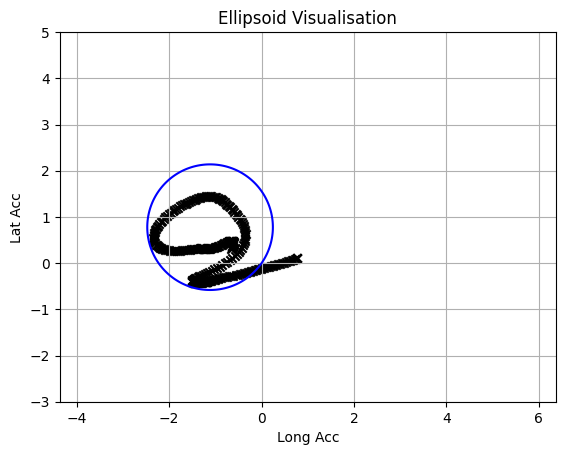

Optimal solution found!


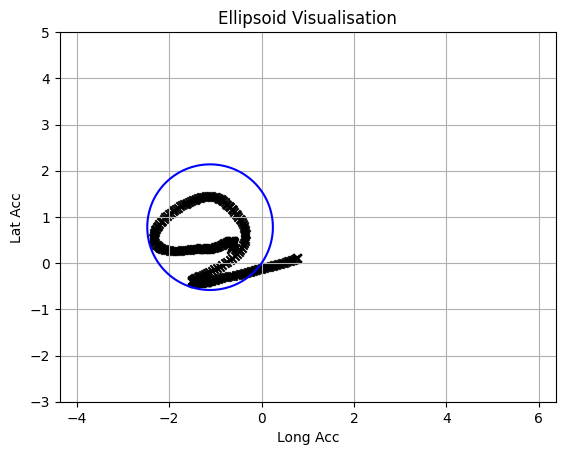

Optimal solution found!


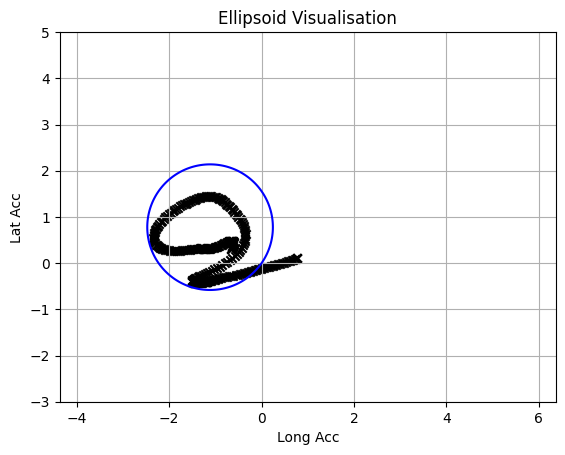

Optimal solution found!


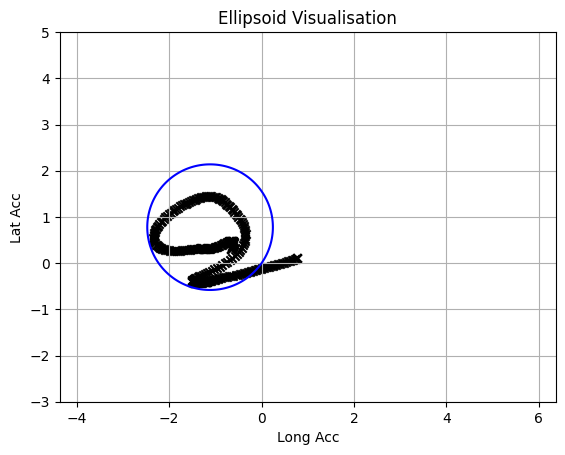

Optimal solution found!


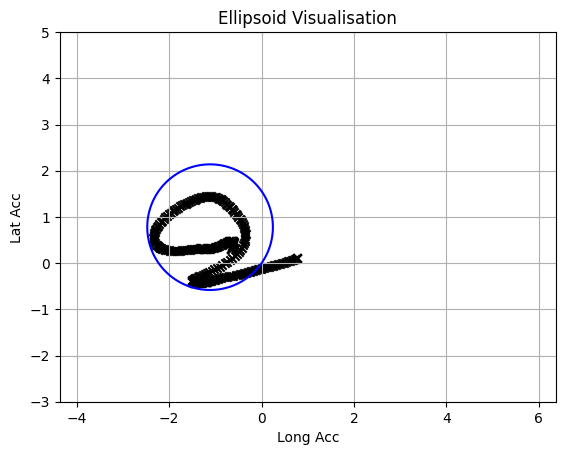

Optimal solution found!


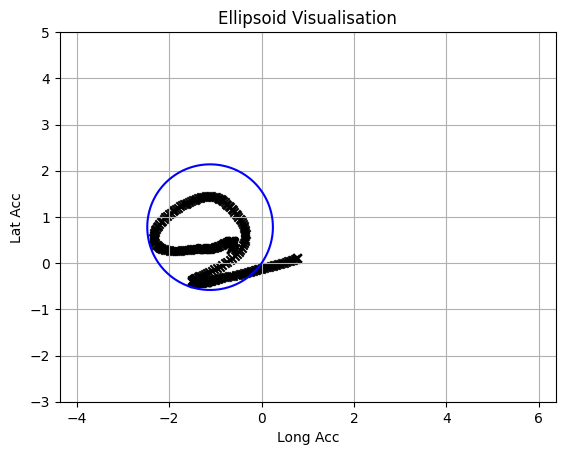

Optimal solution found!


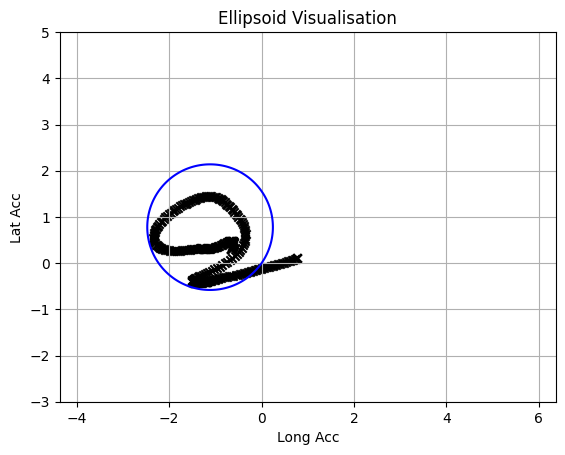

Optimal solution found!


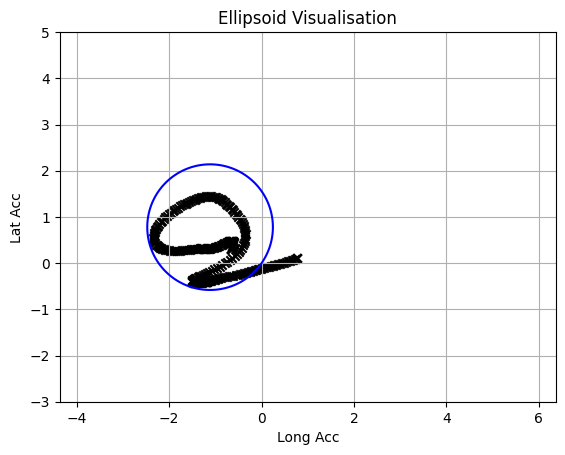

In [13]:

B_pre, b_tilde_pre = opti_SDP_lemma(nu,A_init,b_init,c_init,b_init)
A_pre = np.linalg.inv(np.linalg.inv(np.linalg.cholesky(B_pre)))
b_pre = A_pre@b_tilde_pre


for i in range(N_Sam):
    c_pre = b_pre.T@b_pre-1
    u_pre = np.array([[random_vals[0,i]],[random_vals[1,i]]])
    B_pre, b_tilde_pre = opti_SDP_lemma(nu,A_pre,b_pre,c_pre,u_pre)
    A_pre = sqrtm(B_pre)
    b_pre = np.linalg.inv(A_pre)@b_tilde_pre
    plot_el(A_pre,b_pre,i)